Étude de la stabilité et calcul automatique de CFL
===

Nous nous intéressons ici à résoudre un problème de transport du type :

$$
  u_t + u_x = 0
$$

avec $x\in[0,1]$ et $t>0$, ainsi que la condition initiale $u_0$ donnée. Les méthodes que nous allons présentées s'étendent à des problèmes de transport non linéaire : $u_t + f_x(u) = 0$, mais la seule généralisation qui nous intéressera sera une équation de transport à vitesse constante $a$ : $u_t + au+x = 0$.

La discrétisation en espace se concentrera sur des méthodes WENO, ou des différences finies centrées d'ordre 2 ; la discrétisation en temps se concentrera sur des méthodes de type Runge-Kutta. Par la suite, pour effectuer un lien avec l'équation de Vlasov-Poisson, nous nous intéresserons à un problème généralisé du type :

$$
  u_t = Lu + N(u)
$$

où $L$ représentera la partie linéaire de notre problème et $N$ la partie non linéaire. Ce problème nous permettra d'étudier la résolution en temps avec des schémas exponentiels.

In [1]:
"""
global import, and define common symbols
"""

import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from IPython.display import display
sp.init_printing()

from sympy import I

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
x,y = sp.symbols("x y",real=True)
z   = sp.symbols("z")

class Data(object):
  """
    dummy class to store data
  """
  def __str__(self):
    return "\n".join([ "{} : {}".format(k,v) for k,v in self.__dict__.items()])

default = Data()
default.figsize = plt.rcParams['figure.figsize']

import matplotlib.colors as mcolors # for mcolors.TABLEAU_COLORS
default.palette = list(mcolors.TABLEAU_COLORS)

In [2]:
# if need to reimport `plt` during a working session
from importlib import reload
plt = reload(plt)

In [3]:
def reim(Z):
  """
    function to split into 2 arrays real part and imaginary part of complex array
  """
  complex_to_tuple = lambda z:(z.real,z.imag)
  return tuple(map(list,zip(*map(complex_to_tuple,Z))))

def plot(expr,x,I,*args,**kwargs):
  """
    just plot a SymPy expression `expr` of variable `x` on the interval `I`
  """
  X = np.linspace(I[0],I[1],500)
  F = sp.lambdify(x,expr,'numpy')
  plt.plot(X,F(X),*args,**kwargs)

# just to store grid
data = Data()
# phi array to store angle where evaluate ztilde(phi)
data.phi = np.linspace(0,2.0*np.pi,1000)

# 1. Discrétisations en espace

Pour étudier les schémas en espace nous allons utiliser l'analyse de *von Neumann*, pour cela introduisons quelques fonctions.

In [4]:
"""
  we will use von Neumann analysis to study WENO schemes
  this functions are helpers to write numerical flux of WENO and apply von Neumann analysis with sympy
"""

def f(k):
  """
    return $f_{i+k}$
  """
  if k==0:
    return sp.symbols("f_j")
  return sp.symbols("f_j%+d"%k)
  
def stencil(i_min,i_max) :
  """
    stencil
    return dictionary of (i,f_i) value between `i_min` and `i_max`
  """
  return dict(enumerate( [ f(i) for i in range(i_min,i_max+1) ] , start=i_min ))
f_stencil = stencil(-3,3) # stencil (-3,3) is the size of WENO5 stencil for hight order scheme need to grow up this one

def symbols_to( stencil , func ):
  """
    symbols_to
    convert dictionary `stencil` of `int => sp.Symbols` to dictionary of`sp.Symbols => sp.Symbols`
    useful to replace all $f_i$ symbols by an other value in expression
  """
  return { f:func(j,f) for j,f in stencil.items() }

def symbols_to_vonNeumann( stencil ):
  """
    symbols_to_vonNeumann
    convert all $f_i$ symbols to equivalent in von Neumann analysis with exponential
    $\phi$ symbol need to be initialized
  """
  return symbols_to( stencil , lambda j,_:sp.exp(I*j*phi) )

## 1.1 Méthodes d'ordre 1 et 2

Dans un premier temps nous allons présenter la méthode d'analyse sur le schéma *upwind* ou les différences finies centrées d'ordre 2.

Nous cherchons à discrétiser un problème du type :

$$
  \partial_t u + a\partial_x u = 0
$$

Après une semi-discrétisation en espace, le schéma *upwind* s'écrit :

$$
  \frac{\mathrm{d}u_j}{\mathrm{d}t} = -\frac{a^+}{\Delta x}\left(u_{j}-u_{j-1}\right)-\frac{a^-}{\Delta x}\left(u_{j+1}-u_{j}\right)
$$

où $u_j(t)\approx u(t,x_j)$, $j=0,\dots,N$, $a^+=\max(a,0)$ et $a^-=\min(a,0)$.

Après une semi-discrétisation en espace, le schéma des différences finies centrées d'ordre 2 s'écrit :

$$
  \frac{\mathrm{d}u_j}{\mathrm{d}t} = -\frac{a}{2\Delta x}\left(u_{j+1}-u_{j-1}\right)
$$

où $u_j(t)\approx u(t,x_j)$, $j=0,\dots,N$.

In [5]:
def upwind_flux () :
  return f(0) - f(-1)

upwind = Data()
upwind.name = "upwind"
upwind.flux = upwind_flux()

del upwind_flux

def cd2_flux () :
  return (f(1) - f(-1))/2

cd2 = Data()
cd2.name = "CD2"
cd2.flux = cd2_flux()

del cd2_flux

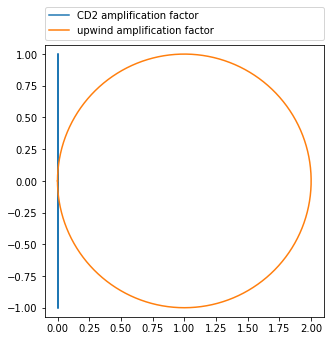

In [6]:
upwind.func = sp.lambdify(phi,upwind.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
upwind.data = upwind.func(data.phi)

cd2.func = sp.lambdify(phi,cd2.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
cd2.data = cd2.func(data.phi)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(*reim(cd2.data),label=cd2.name+" amplification factor")
plt.plot(*reim(upwind.data),label=upwind.name+" amplification factor")
plt.axis('equal')
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

La courbe pour le schéma *upwind* est orienté vers une partie réelle positive car il s'agit de l'approximation de $+\partial_xu$ or les méthodes Runge-Kutta que nous allons étudier par la suite s'applique à un problème écrit sous la forme $\dot{u} = L(t,u)$ donc il sera nécessaire d'approximer $-\partial_xu$.

On peut maintenant mettre en place les fonctions nécessaires pour la résultion numérique d'un problème de transport à vitesse constante (positive) :

$$
  u_t + u_x = 0
$$

avec des conditions aux bords périodiques et une condition initiale $u(t=0,x) = u_0(x)$ donnée.

In [7]:
def _upwind(u_i,dx):
  """
    upwind
    return the upwind approximation of $\partial_x u$
  """
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])

  return (u_i-u_im1)/dx

def _cd2(u_i,dx):
  """
    cd2
    return the centred differiencies of order 2 of $\partial_x u$
  """
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])

  return (u_ip1-u_im1)/(2.0*dx)

upwind.func = _upwind
cd2.func = _cd2

del _upwind,_cd2

def rk33_iter(un,L,dt,*config):
  """
    rk33_iter
    return the one iteration of Runge-Kutta approximation of
    $\dot{u} = L(u,config)$ with initial condtion `un`
  """
  u1 = un + dt*L(un,*config)
  u2 = 0.75*un + 0.25*u1 + 0.25*dt*L(u1,*config)
  return (1./3.)*un + (2./3.)*u2 + (2./3.)*dt*L(u2,*config)

In [8]:
def transport(u0,rk,L,Tf,dt):
  r"""
    transport
    use `rk` method with `L` discretisation in space to solve :
    $u_t = L(u),\ u(t=0)=\texttt{u0}$,
    to the time `Tf`, with time step `dt`, $x\in[0,1]$ so length
    of `u0` gives the space step.
  """
  N = len(u0)
  u = u0
  dx = 1./N

  niter = 0
  while niter*dt < Tf :
    u = rk(u,L,dt,dx)
    niter += 1
  
  return u

class error:
  """
    error
    compute and store error between an exact solution and an approximation solution
    errors are computed in norm 1, 2 and infinity
  """
  def __init__(self,u,v,dx=None):
    diff = np.array(u-v)
    if dx is None:
      dx = 1./(len(u))
    self.n1 = np.sum(np.abs(diff))*dx
    self.n2 = np.sqrt(np.sum(np.square(diff)))*dx
    self.noo = np.max(np.abs(diff))
  
  def __str__(self):
    return """{} {} {}""".format(self.n1,self.n2,self.noo)
  def __repr__(self):
    return "error<{},{},{}>".format(self.n1,self.n2,self.noo)
  def __getitem__(self,i):
    return [self.n1,self.n2,self.noo][i]

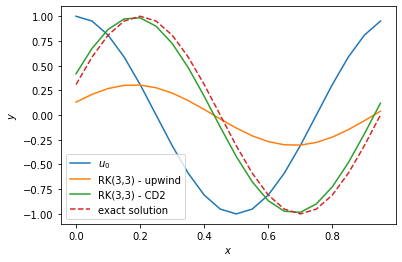


error in norm 1, 2 and infinity
upwind error          : 0.44355874753534724 0.11027849747336503 0.6963822168584866
centred differencies 2: 0.07726113977357323 0.01911555252994856 0.11982562564685197



In [9]:
num_param = Data()

num_param.N = 20
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
num_param.u_0 = np.cos(2.*np.pi*num_param.X)

num_param.Tf = 1.2
num_param.dt = 1./num_param.N # = dx; a classical CFL

u_upwind = transport(num_param.u_0,rk33_iter,lambda u,dx:-upwind.func(u,dx),num_param.Tf,num_param.dt)
u_cd2    = transport(num_param.u_0,rk33_iter,lambda u,dx:-cd2.func(u,dx)   ,num_param.Tf,num_param.dt)
u_exact  = np.cos(2.*np.pi*(num_param.X - num_param.Tf))

plt.plot(num_param.X,num_param.u_0,label="$u_0$")
plt.plot(num_param.X,u_upwind,label="RK(3,3) - "+upwind.name)
plt.plot(num_param.X,u_cd2,label="RK(3,3) - "+cd2.name)
plt.plot(num_param.X,u_exact,"--",label="exact solution")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

del num_param

print("""
error in norm 1, 2 and infinity
upwind error          : {}
centred differencies 2: {}
""".format( error(u_upwind,u_exact) , error(u_cd2,u_exact)) )
del u_exact,u_upwind,u_cd2

Maintenant, on effectue une mesure d'ordre, sur le même problème de transport avec comme condition initiale $u_0(x) = \cos(2\pi x)$.

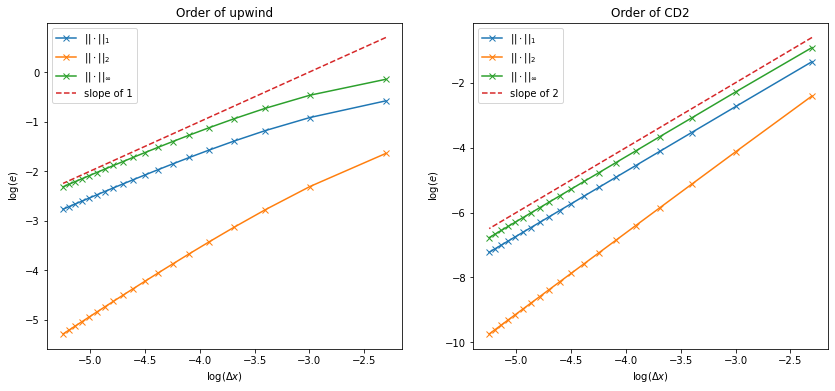

In [10]:
num_param = Data()
num_param.dt = 1./400.
num_param.Tf = 1.

errors_uw  = []
errors_cd2 = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_fuw  = transport(u_0,rk33_iter,lambda u,dx:-upwind.func(u,dx),num_param.Tf,num_param.dt)
    u_fcd2 = transport(u_0,rk33_iter,lambda u,dx:-cd2.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_uw.append( (N,error(u_fuw,u_e)) )
    errors_cd2.append( (N,error(u_fcd2,u_e)) )

del N,num_param,u_0,u_e,u_fuw,u_fcd2

space_steps = np.array([ 1./e[0] for e in errors_uw ])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.set_title("Order of "+upwind.name)
ax1.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_uw ] , "x-" , label = r"$||\cdot||_{1}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_uw ] , "x-" , label = r"$||\cdot||_{2}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_uw ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax1.plot( np.log(space_steps) , 1*np.log(space_steps)+3 , "--" , label = "slope of 1")
ax1.set_xlabel(r"$\log(\Delta x)$")
ax1.set_ylabel(r"$\log(e)$")
ax1.legend()

ax2.set_title("Order of "+cd2.name)
ax2.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_cd2 ] , "x-" , label = r"$||\cdot||_{1}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_cd2 ] , "x-" , label = r"$||\cdot||_{2}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_cd2 ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax2.plot( np.log(space_steps) , 2*np.log(space_steps)+4 , "--" , label = "slope of 2")
ax2.set_xlabel(r"$\log(\Delta x)$")
ax2.set_ylabel(r"$\log(e)$")
ax2.legend()

plt.show()

del fig,ax1,ax2,space_steps,errors_uw,errors_cd2

Maintenant mettons en place ces outils pour le schéma WENO et ses variantes.

## 1.2 Présentation de la méthode WENO5

La méthode WENO est une famille de schémas aux différences finies (il existe une interprétation en terme de volumes finis) d'ordre potentiellement élevé, essentiellement non oscillante à l'aide de différentes approximations pondérées. De manière générale, la méthode WENO peut être utilisée pour discrétiser la dérivée spatiale dans un problème de transport du type :

$$
  \partial_t u + \partial_x f(u) = 0
$$

Après une semi-discrétisation en espace, la méthode WENO consiste à approximer les flux numériques tels que :

$$
  \frac{\mathrm{d}u_j}{\mathrm{d}t} = -\frac{1}{\Delta x}\left( \hat{f}_{j_\frac{1}{2}} - \hat{f}_{j-\frac{1}{2}} \right)
$$

où $u_j(t) \approx u(t,x_j),\ j=0,\dots,N$. La méthode WENO, qui est une méthode *up-wind*, nécessite de *splitter* le flux entre sa partie positive et négative :

$$
  f(u) = f^+(u) + f^-(u)
$$

tel que $\frac{\mathrm{d}f^+}{\mathrm{d}u} \geq 0$ et $\frac{\mathrm{d}f^-}{\mathrm{d}u} \leq 0$. Nous noterons par la suite $f^\pm_j$ l\ approximation de $f^\pm(u(x_j))$ où $x_j$ est un point du maillage.

La méthode WENO consiste ensuite à estimer des poids en fonctions d'indicateurs de continuité (*indicators of smoothness*) $\beta_i^\pm$ (parfois noté $IS_i^\pm$), qui sont des combinaisons des carrés des approximations des dérivées successives en $x_j$ (sur des *stencils* potentiellement décentrés). Les coefficients $\beta_i^\pm$ permettent d'estimer des poids $w_i^\pm$, pondérant différentes estimations de la solution toujours en $x_j$ sur les différents *stencils*.

Pour le schéma *standard* WENO d'ordre 5 (aussi appelé WENO-JS pour [[G.-S. Jiang et C.-W. Shu (1996)]](http://doi.org/10.1006/jcph.1996.0130)) il y a 3 estimations sur 3 *stencils* différents :

$$
  \begin{aligned}
    \beta_0^+ &= \frac{13}{12}(\underbrace{f^+_{j-2} - 2f^+_{j-1} + f^+_{j}  }_{\Delta x^2(f''_j + \mathcal{O}(\Delta x))}))^2 + \frac{1}{4}( \underbrace{f^+_{j-2} - 4f^+_{j-1} + 3f^+_{j}}_{2\Delta x( f'_j + \mathcal{O}(\Delta x^2))}  )^2 \\
    \beta_1^+ &= \frac{13}{12}( \underbrace{f^+_{j-1} - 2f^+_{j}   + f^+_{j+1}}_{\Delta x^2(f''_j + \mathcal{O}(\Delta x^2))} )^2 + \frac{1}{4}( \underbrace{f^+_{j-1} -  f^+_{j+1}}_{2\Delta x f'_j + \mathcal{O}(\Delta x^2))})^2 \\
    \beta_2^+ &= \frac{13}{12}( \underbrace{f^+_{j}   - 2f^+_{j+1} + f^+_{j+2}}_{\Delta x^2(f''_j + \mathcal{O}(\Delta x))} )^2 + \frac{1}{4}(\underbrace{3f^+_{j}   - 4f^+_{j+1} +  f^+_{j+2}}_{-2\Delta x( f'_j + \mathcal{O}(\Delta x^2))})^2 \\
  \end{aligned}
$$

et de manière similaire :

$$
  \begin{aligned}
    \beta_0^- &= \frac{13}{12}(f^-_{j+1} - 2f^-_{j+2} + f^-_{j+3})^2 + \frac{1}{4}(3f^-_{j+1} - 4f^-_{j+2} +  f^-_{j+3})^2 \\
    \beta_1^- &= \frac{13}{12}(f^-_{j}   - 2f^-_{j+1} + f^-_{j+2})^2 + \frac{1}{4}( f^-_{j}   -  f^-_{j+2})^2 \\
    \beta_2^- &= \frac{13}{12}(f^-_{j-1} - 2f^-_{j}   + f^-_{j+1})^2 + \frac{1}{4}( f^-_{j-1} - 4f^-_{j}   + 3f^-_{j+1})^2 \\
  \end{aligned}
$$

Ensuite nous calculons les poids non normalisés :

$$
  \alpha_i^\pm = \frac{\gamma_i}{(\varepsilon + \beta_i^\pm)^2},\quad i=0,1,2
$$
où $\varepsilon$ est un paramètre numérique pour assurer la non nullité du dénominateur, il sera pris à $10^{-6}$ ; et vaec $\gamma_0=\frac{1}{10}$, $\gamma_1=\frac{6}{10}$ et $\gamma_2=\frac{3}{10}$. La normalisation des poids s'effectue comme suit :

$$
  w_i^\pm = \frac{\alpha_i^\pm}{\sum_m \alpha_m^\pm},\quad i=0,1,2
$$

Nous pouvons ensuite calculer les flux numériques pour WENO5, donnés par :


$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^+   =\ & w_0^+\left(  \frac{2}{6}f^+_{j-2} - \frac{7}{6}f^+_{j-1} + \frac{11}{6}f^+_{j}   \right)
                                +    w_1^+\left( -\frac{1}{6}f^+_{j-1} + \frac{5}{6}f^+_{j}   +  \frac{2}{6}f^+_{j+1} \right) \\
                                +  & w_2^+\left(  \frac{2}{6}f^+_{j}   + \frac{5}{6}f^+_{j+1} -  \frac{1}{6}f^+_{j+2} \right)
  \end{aligned}
$$

et

$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^-   =\ & w_2^-\left( -\frac{1}{6}f^-_{j-1} + \frac{5}{6}f^-_{j}   + \frac{2}{6}f^-_{j+1} \right)
                                +    w_1^-\left(  \frac{2}{6}f^-_{j}   + \frac{5}{6}f^-_{j+1} - \frac{1}{6}f^-_{j+2} \right) \\
                                +  & w_0^-\left( \frac{11}{6}f^-_{j+1} - \frac{7}{6}f^-_{j+2} + \frac{2}{6}f^-_{j+3} \right)
  \end{aligned}
$$

La méthode WENO5 prend la forme finale :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}\left[ \left(\hat{f}_{j+\frac{1}{2}}^+ - \hat{f}_{j-\frac{1}{2}}^+ \right) + \left(\hat{f}_{j+\frac{1}{2}}^- - \hat{f}_{j-\frac{1}{2}}^- \right) \right]
$$

Pour l'étude de la stabilité nous ne prendrons que le cas $f^+(u) = u$ et $f^-(u) =0$

### 1.2.1 Linéarisation du schéma WENO5

Le schéma WENO n'étant pas linéaire, son étude est en dehors du cadre classique de l'analyse de von Neumann. L'étude de la stabilité du schéma WENO avec différents schémas en temps, initié dans [[R. Wang and R. J. Spiteri (2007)]](https://doi.org/10.1137/050637868) et repris dans [[M. Motamed and C. B. Macdonald and S. J. Ruuth (2010)]](https://doi.org/10.1007/s10915-010-9423-9) s'effectue à partir d'une linéarisation du schéma WENO, le calcul complet y est présenté, nous utiliserons ici que le résultat, issu d'un développement limité des poids non linéaire de la méthode WENO. Le développement limité nous donne une linéarisation des poids en :

$$
  \alpha_i^{\pm} = \gamma_i + \mathcal{O}(\Delta x^2)
$$

les poids $w_i^{\pm}$ s'écrivent alors :

$$
  w_i^{\pm} = \gamma_i + \epsilon_i^{\pm}
$$

avec $\epsilon_i = \mathcal{O}(\Delta x^2)$. Le coefficient d'amplification du schéma WENO linarisé s'écrit :

$$
  \lambda^{\ell W}(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i^{\pm}\}_i,\phi)
$$

où $\tilde{z}$ correspond à la partie linéarie de WENO5 et $M$, dépendant de la famille des $\{\epsilon_i\}_i$, la partie non linéaire. Wang et Spiteri montrent qu'il est possible de majorer $M$ en remarquant que $M(\{\epsilon_i^{\pm}\}_i,\phi) = \mathcal{O}(\max_i(\epsilon_i))$. La fonction $\tilde{z}$ étant linéaire, il est possible d'effectuer son analyse de stabilité à l'aide de l'analyse de von Neumann.

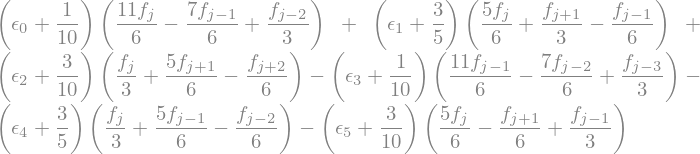

In [11]:
"""
linearized WENO method
"""
weno5l = Data()
weno5l.name = "linearized WENO5"

ei = sp.symbols("\\epsilon_0:6",real=True)

def weno5l_flux () :
  w0 = sp.Rational(1,10) + ei[0]
  w1 = sp.Rational(6,10) + ei[1]
  w2 = sp.Rational(3,10) + ei[2]
  
  w3 = sp.Rational(1,10) + ei[3]
  w4 = sp.Rational(6,10) + ei[4]
  w5 = sp.Rational(3,10) + ei[5]
  
  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({ei[0]:ei[3],ei[1]:ei[4],ei[2]:ei[5]})
  
  return fjp12 - fjm12

weno5l.flux = weno5l_flux()
del weno5l_flux
display(weno5l.flux)



Le flux de WENO5 non linéarisé fait intervenir les $\epsilon_i$ dont la contribution est difficilement quantifiable. On réécrit $\lambda^{\ell W} = \tilde{z} + \mathcal{O}(\Delta x^2)$, et on néglige tous les termes d'ordre $\Delta x^2$ et suppérieur.

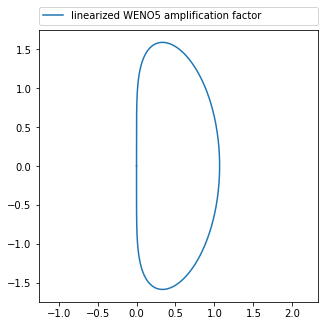

In [12]:
weno5l.ztilde = Data()

weno5l.ztilde.flux = weno5l.flux.expand().subs([(e,0) for e in ei])
weno5l.ztilde.func = sp.lambdify(phi,weno5l.ztilde.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
weno5l.ztilde.data = weno5l.ztilde.func(data.phi)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(*reim(weno5l.ztilde.data),label=weno5l.name+" amplification factor")
plt.axis('equal')
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

On retrouve ainsi la courbe en *haricot* décrite dans [[M. Motamed and C. B. Macdonald and S. J. Ruuth (2010)]](https://doi.org/10.1007/s10915-010-9423-9) ou [[D. Ketcheson and C. B. Macdonald and S. J. Ruuth (2013)]](https://doi.org/10.1137/130906258).

On peut maintenant s'intéresser aux non linéarités $M(\{\epsilon_i^\pm\}_i)$

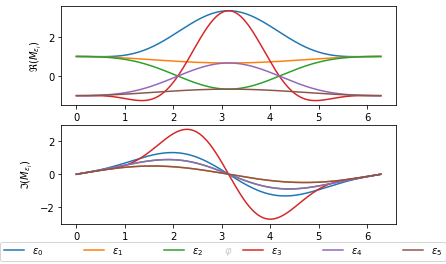

In [13]:
weno5l.M = Data()

weno5l.M.flux = (weno5l.flux.expand() - weno5l.ztilde.flux).collect(ei)
weno5l.M.func = [ sp.lambdify(phi,arg.subs([(e,1) for e in ei]),'numpy')
                  for arg in weno5l.M.flux.subs(symbols_to_vonNeumann(f_stencil)).args ]
weno5l.M.data = [ fun(data.phi) for fun in weno5l.M.func ]

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xlabel("$\\varphi$"); ax1.set_ylabel("$\\Re(M_{\\epsilon_i})$")
ax2.set_xlabel("$\\varphi$"); ax2.set_ylabel("$\\Im(M_{\\epsilon_i})$")

for i,dat in enumerate(weno5l.M.data):
  ax1.plot(data.phi,dat.real,label="$\\epsilon_{}$".format(i))
  ax2.plot(data.phi,dat.imag,label="$\\epsilon_{}$".format(i))

handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc=(0.,0.01),ncol=len(weno5l.M.data),mode="expand",borderaxespad=0.)
plt.show()

del fig,ax1,ax2,i,dat,handles,labels

En réalité la valeur des différentes composantes de $M$ nous importent peu. Ce qu'il faut remarquer est la forme général de chaque composante, prenons comme exemple la composante $\epsilon_0$ :

$$
  \begin{aligned}
    \Re \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Re}|\epsilon_0| \\
    \Im \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Im}|\epsilon_0|
  \end{aligned}
$$

avec $c_0^{\Re|\Im}$ des constantes positives. Dans [[Wang R. and Spiteri R. J. (2007)]](https://doi.org/10.1137/050637868), une estimation de $c_0^{\Re}=\frac{10}{3}$ est prise comme exemple. On majore ainsi toutes les composantes en $\epsilon_i$ de $M$, on se retrouve alors avec :

$$
  \begin{aligned}
    \left|\Re\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Re}\max_{0\leq m \leq 5}|\epsilon_m| \\
    \left|\Im\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Im}\max_{0\leq m \leq 5}|\epsilon_m|
  \end{aligned}
$$

avec $\Gamma^{\Re|\Im}$ des constantes postives ne dépendant que de la taille du *stencil* considéré. Cela permet de justifier $M = \mathcal{O}(\Delta x^2)$.

On peut vérifier quelques propriétés de ce schéma WENO linéarisé. Ce schéma correspond à l'approximation des poids $w_i^\pm = \gamma_i$, c'est-à-dire que les *indicators of smoothness* valent tous 1, ce qui se justifie avec une fonction suffisamment régulière.

On implémente dans un premier temps nos schémas en espace :

* `weno` : le schéma WENO classique d'ordre 5,
* `weno_lin` : le schéma WENO d'ordre 5 linéarisé, que l'on souhaite tester,
* `cd2` : le schéma de différences finies centrées d'ordre 2, qui nous sert plus pour débugger.

Puis le schéma en temps, on se contentera d'un schéma de type Runge-Kutta d'ordre 3 à 3 étages : RK(3,3) (avec la fonction `rk33`). Ce schéma est d'ordre inférieur en temps, l'erreur sattuera donc rapidement en $\Delta t^3$.

In [14]:
def _weno(u_i,dx):
  """
    weno
    return the WENO approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  b0 = 13./12.*np.square( u_im2 - 2.*u_im1 + u_i   ) + 0.25*np.square(    u_im2 - 4.*u_im1 + 3.*u_i   )
  b1 = 13./12.*np.square( u_im1 - 2.*u_i   + u_ip1 ) + 0.25*np.square(    u_im1            -    u_ip1 )
  b2 = 13./12.*np.square( u_i   - 2.*u_ip1 + u_ip2 ) + 0.25*np.square( 3.*u_i   - 4.*u_ip1 +    u_ip2 )
  alpha  = [ g_i/np.square(b_i+1e-6) for b_i,g_i in zip((b0,b1,b2),(0.1,0.6,0.3)) ]
  sum_alpha = sum(alpha)
  w0,w1,w2 = [ a_i/sum_alpha for a_i in alpha ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

def _weno_lin(u_i,dx):
  """
    weno_lin
    return the linearized WENO approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])

  w0,w1,w2 = [ g_i for g_i in (0.1,0.6,0.3) ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

weno5 = Data()
weno5.name = "WENO5"
weno5.func = _weno

weno5l.func = _weno_lin

del _weno,_weno_lin

On teste nos schémas avec un problème de transport :

$$
  \begin{cases}
    u_t + u_x = 0 \\
    u(t=0,x) = u_0(x) = \cos(x)
  \end{cases}
$$

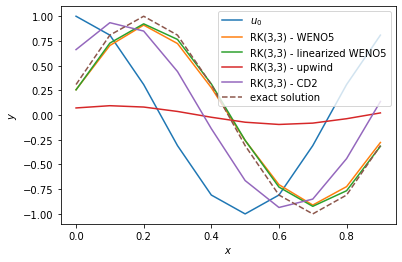


error in norm 1, 2 and infinity
WENO error            : 0.0727358076583417 0.024515017107707204 0.10507133395404789
linearized WENO error : 0.052196889534167935 0.018565045399276857 0.08064862959784924
centred differencies 2: 0.28880497730726834 0.09982004218314151 0.4462282302400852



In [15]:
num_param = Data()

num_param.N = 10
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
num_param.u_0 = np.cos(2.*np.pi*num_param.X)

num_param.Tf = 1.2
num_param.dt = 1./num_param.N # = dx; a classical CFL

u_uw    = transport(num_param.u_0,rk33_iter,lambda u,dx:-upwind.func(u,dx),num_param.Tf,num_param.dt)
u_cd2   = transport(num_param.u_0,rk33_iter,lambda u,dx:-cd2.func(u,dx)   ,num_param.Tf,num_param.dt)
u_weno  = transport(num_param.u_0,rk33_iter,lambda u,dx:-weno5.func(u,dx) ,num_param.Tf,num_param.dt)
u_wenol = transport(num_param.u_0,rk33_iter,lambda u,dx:-weno5l.func(u,dx),num_param.Tf,num_param.dt)
u_exact = np.cos(2.*np.pi*(num_param.X - num_param.Tf))

plt.plot(num_param.X,num_param.u_0,label="$u_0$")
plt.plot(num_param.X,u_weno,label="RK(3,3) - "+weno5.name)
plt.plot(num_param.X,u_wenol,label="RK(3,3) - "+weno5l.name)
plt.plot(num_param.X,u_uw,label="RK(3,3) - "+upwind.name)
plt.plot(num_param.X,u_cd2,label="RK(3,3) - "+cd2.name)
plt.plot(num_param.X,u_exact,"--",label="exact solution")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

del num_param

print("""
error in norm 1, 2 and infinity
WENO error            : {}
linearized WENO error : {}
centred differencies 2: {}
""".format( error(u_weno,u_exact) , error(u_wenol,u_exact) , error(u_cd2,u_exact)) )
del u_exact,u_weno,u_wenol,u_cd2

On peut maintenant calculer l'ordre de la méthode sur ce problème de transport, en calculant la solution pour différents $\Delta x$ (on choisit différentes tailles de vecteur en entré), jusqu'au temps $T_f=1$ avec un pas de temps $\Delta t = \frac{1}{400}$ qui correspond environ à $\Delta t \leq \frac{1}{2}\Delta x_{\text{min}}$, pour minimiser l'erreur en temps.

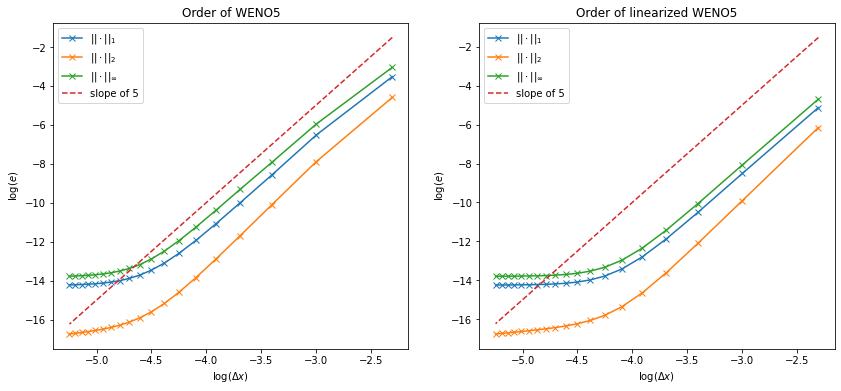

In [16]:
num_param = Data()
num_param.dt = 1./400.
num_param.Tf = 1.

errors_wenol = []
errors_weno  = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_fl = transport(u_0,rk33_iter,lambda u,dx:-weno5l.func(u,dx),num_param.Tf,num_param.dt)
    u_f  = transport(u_0,rk33_iter,lambda u,dx:-weno5.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_wenol.append( (N,error(u_fl,u_e)) )
    errors_weno.append( (N,error(u_f,u_e)) )

del N,num_param,u_0,u_e,u_fl,u_f

space_steps = np.array([ 1./e[0] for e in errors_weno ])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.set_title("Order of "+weno5.name)
ax1.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_weno ] , "x-" , label = r"$||\cdot||_{1}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_weno ] , "x-" , label = r"$||\cdot||_{2}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_weno ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax1.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
ax1.set_xlabel(r"$\log(\Delta x)$")
ax1.set_ylabel(r"$\log(e)$")
ax1.legend()

ax2.set_title("Order of "+weno5l.name)
ax2.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_wenol ] , "x-" , label = r"$||\cdot||_{1}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_wenol ] , "x-" , label = r"$||\cdot||_{2}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_wenol ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax2.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
ax2.set_xlabel(r"$\log(\Delta x)$")
ax2.set_ylabel(r"$\log(e)$")
ax2.legend()

plt.show()

del fig,ax1,ax2,space_steps,errors_weno,errors_wenol

On remarque bien une pente d'ordre 5 avec le schéma WENO linéarisé.

La linéarisation du schéma WENO suppose que la à dériver est suffisamment régulière. On peut donc chercher à étudier son comportement face à une discontinuité, en transportant à vitesse 1 une fonction test.

Le cas test de Shu est donné par la condtion initiale suivante :

$$
  u_0(x) = \begin{cases}
    \frac{1}{6}\left( G(x,\beta,z-\delta) + G(x,\beta,z+\delta) + 4G(x,\beta,z) \right) & -0.8 \leq x \leq -0.6 \\
    1  & -0.4 \leq x \leq -0.2 \\
    1 - \left| 10(x-0.1) \right| & 0 \leq x \leq 0.2 \\
    \frac{1}{6}\left( F(x,\alpha,a-\delta) + F(x,\alpha,a+\delta) + 4F(x,\alpha,a) \right) & 0.4 \leq x \leq 0.6 \\
    0 & \text{sinon}
  \end{cases}
$$

avec :
$$G(x,\beta,z) = e^{-\beta(x-z)^2}$$
$$F(x,\alpha,a) = \sqrt{\max(1-\alpha^2(x-a)^2,0)}$$
et les constantes sont données par $a = 0.5$, $z=-0.7$, $\delta = 0.005$, $\alpha=10$ et $\beta = \frac{\ln(2)}{36\delta^2}$

Ce cas test permet de tester la réponse d'un schéma face à différents profiles de fonctions. Il y a ainsi une fonction continue, lisse, mais relativement fine, une discontinuité, une discontinuité de gradient constant par morceaux, et une discontinuité de gradient avec un fort gradient.

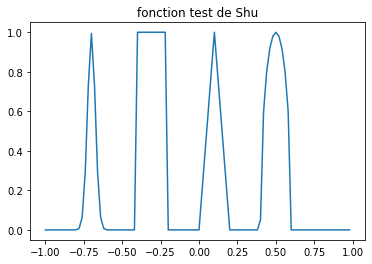

In [17]:
def u0_shu(x):
  x = (x-1)%2-1.0
  
  a = 0.5
  z = -0.7
  delta = 0.005
  alpha = 10.
  beta = np.log(2.)/(36.*delta**2)
  def G(x,beta,z):
    return np.exp(-beta*np.square(x-z))
  def F(x,alpha,a):
    return np.sqrt( max( 1.-alpha**2*np.square(x-a) , 0. ))
  if -0.8<=x and x<=-0.6:
    return (1./6.)*( G(x,beta,z-delta) + G(x,beta,z+delta) + 4.*G(x,beta,z) )
  elif -0.4<=x and x<=-0.2:
    return 1.
  elif 0.<=x and x<=0.2:
    return 1. - np.abs(10.*(x-0.1))
  elif 0.4<=x and x<=0.6:
    return (1./6.)*( F(x,alpha,a-delta) + F(x,alpha,a+delta) + 4.*F(x,alpha,a) )
  return 0.

X = np.linspace(-1.,1.,100,endpoint=False)
plt.plot(X,[ u0_shu(x) for x in X])
plt.title("fonction test de Shu")

del X

La simulation s'éffectue jusqu'au temps $T_f=1$ sur le domaine périodique $[-1,1]$, avec $N_x = 100$ le nombre de points de discrétisation, et la condition CFL est donnée par $\Delta t = 0.1\Delta x$, toujours avec le schéma Runge-Kutta d'ordre 3 RK(3,3).

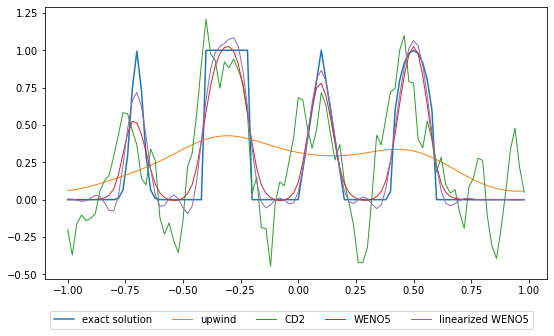

In [18]:
num_param = Data()
num_param.N = 100
num_param.X = np.linspace(-1.,1.,num_param.N,endpoint=False)
u_0 = np.array([u0_shu(x) for x in num_param.X])

num_param.Tf = 1.0
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (upwind,cd2,weno5,weno5l):
  print(scheme.name,end="\r")
  schemes_u[scheme] = transport(u_0,rk33_iter,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,5]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,linewidth=1,label=scheme.name)
plt.legend(loc='upper left',bbox_to_anchor=(0., -0.1),ncol=5)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u,scheme,u

On remarque de manière classique que le schéma *upwind* diffuse énormément, et que le schéma CD2 oscille face à une discontinuité et que celles-ci se propagent sur tout le domaine. Le schéma WENO5 linéarisé oscille lorsque la variation de gradient est importante ou que le gradient présente une dicontinuité, et diffuse peu. Le schéma WENO5 complet devient plus visqueux à l'aide des poids qui permettent d'effectuer une meilleure interpolation qu'une interpolation polynomiale de degré élevé induisant localement des oscillations, mais il diffuse légèrement plus que la version linéarisé. 

On peut étudier la réponse du schéma WENO linéarisé à un cosinus. La méthode servant à approximer une dérivée, on peut vérifier ce comportement, connaissant la solution exacte.

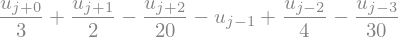

In [19]:
weno5l.ztilde.flux.subs(symbols_to(f_stencil,lambda j,_:sp.symbols(r"u_{j%+d}"%j)))

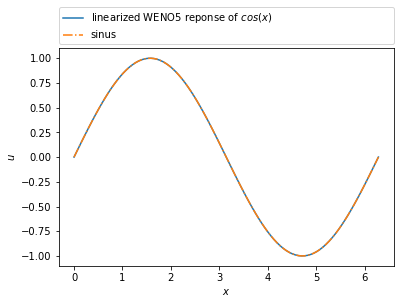

In [20]:
data.phi100 = np.linspace(0,2.0*np.pi,100)
data.deltaX = 2.*np.pi/data.phi100.size
weno5l.ztilde.sinapprox = -sp.lambdify(x,weno5l.ztilde.flux.subs(symbols_to(f_stencil,lambda j,_:sp.cos(x+j*dx))).subs(dx,data.deltaX)/data.deltaX,'numpy')(data.phi100)
plt.plot(data.phi100,weno5l.ztilde.sinapprox,label=weno5l.name+r" reponse of $cos(x)$")
plt.plot(data.phi100,np.sin(data.phi100),"-.",label="sinus")
plt.xlabel("$x$"); plt.ylabel("$u$")
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()

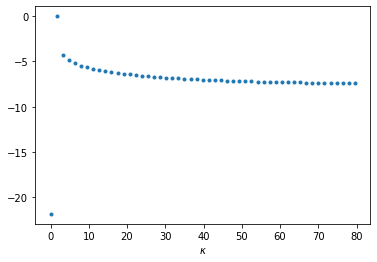

In [21]:
plt.plot( np.fft.rfftfreq(weno5l.ztilde.sinapprox.size,2.*np.pi/data.phi.size) ,
         np.log(np.abs(np.fft.rfft(weno5l.ztilde.sinapprox))*2./weno5l.ztilde.sinapprox.size) , "." )
plt.xlabel(r"$\kappa$")
plt.show()

Le résultat semble satisfaisant, regardons maintenant la différence entre les deux. L'erreur commise par WENO est de $10^{-8}$, avec un $\Delta x = \frac{2\pi}{100}$ (soit $\Delta x^{6}$ ce qui est attendu avec un schéma d'ordre 5).

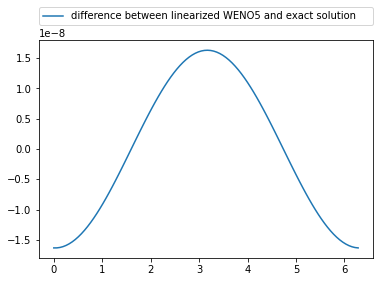

In [22]:
plt.plot(data.phi100,weno5l.ztilde.sinapprox-np.sin(data.phi100),label="difference between "+weno5l.name+" and exact solution")
plt.legend(loc=(0.,1.07),mode="expand",borderaxespad=0.)
plt.show()

In [23]:
(data.deltaX**5,max(weno5l.ztilde.sinapprox-np.sin(data.phi100),key=lambda x:np.abs(x)))

On trouve bien une différence pas très loin de l'ordre de $\Delta x^5$ ce qui nous permet, selon la définition de l'ordre, de considérer le schéma comme d'ordre 5.

L'étude se faisant automatiquement avec `sympy`, il est simple d'effectuer cette étude de coefficients de Fourier avec le schéma WENO standard non linéarisé. L'étude de l'analyse de von Neumann aussi mais il est impossible de justifier mathématiquement les résultats obtenus.

In [24]:
"""
  complet WENO method
"""
epsilon = sp.symbols("\\epsilon",real=True,positive=True)

def weno5_flux () :
  IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
  IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
  IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

  a0 = sp.Rational(1,10)*(1/(epsilon+IS0))**2
  a1 = sp.Rational(6,10)*(1/(epsilon+IS1))**2
  a2 = sp.Rational(3,10)*(1/(epsilon+IS2))**2
  
  s = a0 + a1 + a2
  w0 = a0 / s
  w1 = a1 / s
  w2 = a2 / s

  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  # we define fjm12 as fjp12 where f(j) is substitute by f(j-1)
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)
  
  return fjp12 - fjm12

weno5.flux = weno5_flux()
del weno5_flux

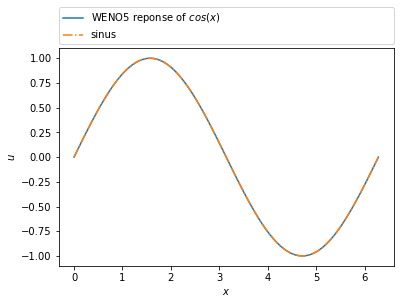

In [25]:
weno5.sinapprox = sp.lambdify(x,-(weno5.flux.subs(symbols_to(f_stencil,lambda j,_:sp.cos(x+j*dx)))).subs(epsilon,10**(-6)).subs(dx,data.deltaX)/data.deltaX,'numpy')(data.phi100)
plt.plot(data.phi100,weno5.sinapprox,label=weno5.name+r" reponse of $cos(x)$")
plt.plot(data.phi100,np.sin(data.phi100),"-.",label="sinus")
plt.xlabel("$x$"); plt.ylabel("$u$")
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()

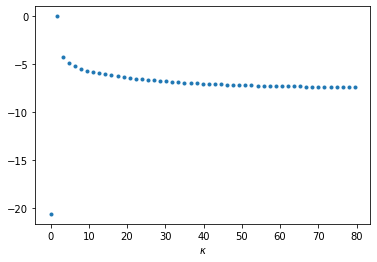

In [26]:
plt.plot( np.fft.rfftfreq(weno5.sinapprox.size,2.*np.pi/data.phi.size) ,
         np.log(np.abs(np.fft.rfft(weno5.sinapprox))*2./weno5.sinapprox.size) , '.' )
plt.xlabel(r"$\kappa$")
plt.show()

On peut maintenant tracer la différence entre les coefficients de Fourier des 2 résultats, entre WENO et WENO linéarisé.

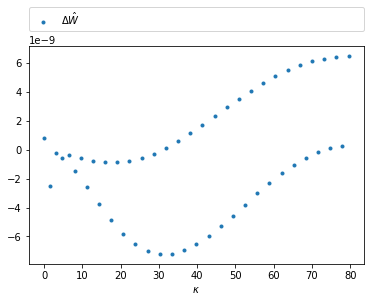

In [27]:
plt.plot( np.fft.rfftfreq(weno5.sinapprox.size,2.*np.pi/data.phi.size) ,
          np.abs(np.fft.rfft(weno5.sinapprox))*2./weno5.sinapprox.size - np.abs(np.fft.rfft(weno5l.ztilde.sinapprox))*2./weno5l.ztilde.sinapprox.size ,
         '.' , label=r"$\Delta \hat{W}$")
plt.xlabel(r"$\kappa$")
plt.legend(loc=(0.,1.07),mode="expand",borderaxespad=0.)
plt.show()

In [28]:
(data.deltaX**5,max(weno5.sinapprox-np.sin(data.phi100),key=lambda x:np.abs(x)))

## 1.3 Méthodes WENO modifiées

Il existe différentes méthodes de calcul des poids du schéma WENO d'ordre 5, qui ont été listées et comparées [ici](https://github.com/wme7/WENO5-X) par Manuel A. Diaz. Nous étudirons ici leur différents coefficients d'amplification.

La différence réside uniquement dans l'estimation des poids, les indicateurs de continuité $\beta_i$ ainsi que les coefficients $\gamma_i$ restent identique.

| Méthode     | Calcul des poids $w_i$ | Parmètres |
|-------------|------------------------|-----------|
| **WENO-JS** | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-6}$                              |
| **WENO-M**  | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \\ g_i &\gets w_i\left(\frac{\gamma_i + \gamma_i^2 - 3w_i\gamma_i + w_i^2}{\gamma_i^2+w_i(1-2\gamma_i)}\right) \\ w_i &\gets \frac{g_i}{\sum g_k} \end{aligned}$$ | $\epsilon = 10^{-6}$ |
| **WENO-Z**  | $$\begin{aligned}\alpha_i &\gets \gamma_i\left(1+\frac{\tau_5}{\epsilon + \beta_i}\right) \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-40}$, $\tau_5 = |\beta_0-\beta_2|$ |

La méthode WENO-JS est la méthode WENO *classique* de Jiang et Shu et sert juste pour la comparaison avec WENO-M (WENO avec une fonction de *mappage*) et WENO-Z. L'objectif de ces méthodes est de minimiser la perte d'ordre à l'approche d'une discontinuité, donc d'approter moins de viscosité numérique.

### 1.3.1 WENO-M

La méthode WENO-M fonctionnne à l'aide d'une fonction dite de *mappage* : $g_i$. Cette fonction est définie par :

$$
  g_i : w \mapsto w\left( \frac{\gamma_i + \gamma_i^2 - 3w\gamma_i + w^2}{\gamma_i^2 + w(1-2\gamma_i)} \right)
$$

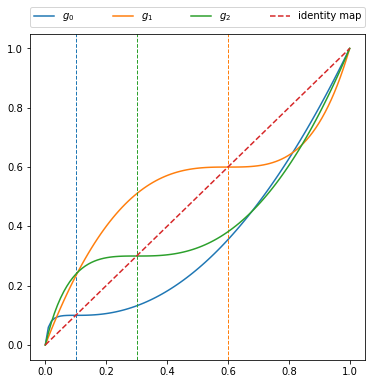

In [29]:
w,gamma_i = sp.symbols("w \\gamma_i",real=True)
g = w*(gamma_i+gamma_i**2-3*w*gamma_i+w**2)/(gamma_i**2+w*(1-2*gamma_i))

plt.rcParams['figure.figsize'] = [6,6]
linW = np.linspace(0,1.0,100)
for i,gi in enumerate([sp.Rational(1,10),sp.Rational(6,10),sp.Rational(3,10)]) :
  plt.plot(linW,sp.lambdify(w,g.subs(gamma_i,gi),'numpy')(linW),label="$g_{}$".format(i),color=default.palette[i])
  plt.axvline(gi,color=default.palette[i],linestyle='--',linewidth=1.)
plt.plot(linW,linW,"--",label="identity map",color=default.palette[3])
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.show()

display(sp.Eq( sp.symbols("g_i'(\\gamma_i)") , g.diff(w).subs(w,gamma_i).simplify() ))
del w,gamma_i,g,linW,i,gi
plt.rcParams['figure.figsize'] = default.figsize

Les fonctions $g_i$ n'ont besoin d'être définie que sur l'intervalle $[0,1]$ puisque les poids d'une méthode WENO vérifient $\sum_k w_k=1$ et $w_k\leq0\,\forall k$. Les points fixes de la fonction de *mappage* $g_i$ sont les 2 valeurs triviales 0 et 1, ainsi que $\gamma_i$ (la valeur linéarisé du poids). La fonction $g_i$ sera évaluée en $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$, ce qui nous intéresse est donc son évaluation en des points proches de $\gamma_i$. On remarque que la dérivée de $g_i$ est nulle (donc un plateau) en $\gamma_i$ et que $g_i(\gamma_i) = \gamma_i$, cela permet de forcer une certaine linéarisation des poids, sans pour autant faire apparaître des oscillations.

Pour une étude plus approfondie de cette méthode avec l'analyse de *von Neumann*, on peut remarquer que la linéarisation des poids donne toujours $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$. L'analyse qui en suit sera identique. On regardera donc son comportement sur une équation de transport avec comme condition initiale le test de Shu.

In [30]:
def _wenom(u_i,dx):
  """
    _wenom
    return the WENO-M approximation of $\partial_x u$
  """
  def g(gi,w):
    return w*(( gi + gi*gi - 3.*w*gi + w*w )/( gi*gi + w*(1.-2.*gi) ))

  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  b0 = 13./12.*np.square( u_im2 - 2.*u_im1 + u_i   ) + 0.25*np.square(    u_im2 - 4.*u_im1 + 3.*u_i   )
  b1 = 13./12.*np.square( u_im1 - 2.*u_i   + u_ip1 ) + 0.25*np.square(    u_im1            -    u_ip1 )
  b2 = 13./12.*np.square( u_i   - 2.*u_ip1 + u_ip2 ) + 0.25*np.square( 3.*u_i   - 4.*u_ip1 +    u_ip2 )
  alpha  = [ g_i/np.square(b_i+1e-6) for b_i,g_i in zip((b0,b1,b2),(0.1,0.6,0.3)) ]
  sum_alpha = sum(alpha)
  w0,w1,w2 = [ a_i/sum_alpha for a_i in alpha ]
  g_weights = [ g(gi,w) for gi,w in zip((0.1,0.6,0.3),(w0,w1,w2)) ]
  sum_g = sum(g_weights)
  w0,w1,w2 = [ g_i/sum_g for g_i in g_weights ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

weno5m = Data()
weno5m.name = "WENO5-M"
weno5m.func = _wenom
del _wenom

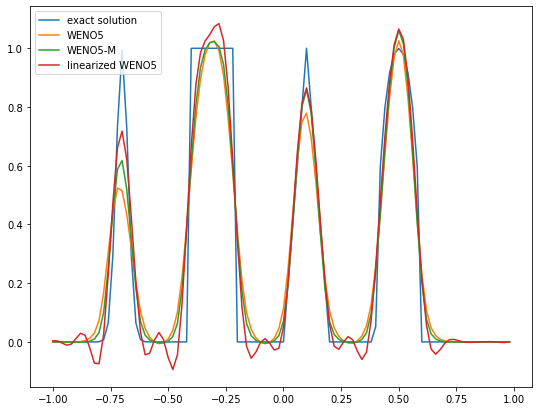

In [31]:
num_param = Data()
num_param.N = 100
num_param.X = np.linspace(-1.,1.,num_param.N,endpoint=False)
u_0 = np.array([ u0_shu(x) for x in num_param.X ])

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5l):
  schemes_u[scheme] = transport(u_0,rk33_iter,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u,scheme,u

On vérifie l'ordre de la méthode, qui est bien d'ordre 5.

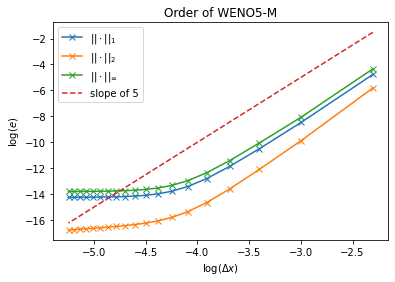

In [32]:
num_param = Data()
num_param.dt = 1./400
num_param.Tf = 1.

errors_wenom = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_f = transport(u_0,rk33_iter,lambda u,dx:-weno5m.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_wenom.append( (N,error(u_f,u_e)) )

space_steps = np.array([ 1./e[0] for e in errors_wenom ])

plt.title("Order of "+weno5m.name)
plt.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_wenom ] , "x-" , label = r"$||\cdot||_{1}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_wenom ] , "x-" , label = r"$||\cdot||_{2}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_wenom ] , "x-" , label = r"$||\cdot||_{\infty}$" )
plt.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
plt.xlabel(r"$\log(\Delta x)$")
plt.ylabel(r"$\log(e)$")
plt.legend()

del N,num_param,u_0,u_e,u_f,space_steps,errors_wenom

### 1.3.2 WENO-Z

La méthode WENO-Z consiste à minimiser la baisse d'ordre à l'approche d'une discontinuité. Dans le cadre de la simulation de plasmas, nous savons que nos fonctions de distribution seront continue, l'ordre élevé est nécessaire pour capturer correctement les forts gradients.

Pour l'analyse de stabilité, la linéarisation des poids donne aussi $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$, l'analyse de *von Neumann* du schéma linéarisé reste donc la même.

In [33]:
def _wenoz(u_i,dx):
  """
    _wenoz
    return the WENO-z approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  b0 = 13./12.*np.square( u_im2 - 2.*u_im1 + u_i   ) + 0.25*np.square(    u_im2 - 4.*u_im1 + 3.*u_i   )
  b1 = 13./12.*np.square( u_im1 - 2.*u_i   + u_ip1 ) + 0.25*np.square(    u_im1            -    u_ip1 )
  b2 = 13./12.*np.square( u_i   - 2.*u_ip1 + u_ip2 ) + 0.25*np.square( 3.*u_i   - 4.*u_ip1 +    u_ip2 )
  tau5 = np.abs(b0-b2)
  alpha  = [ g_i*(1. + tau5/(1e-40 + b_i)) for b_i,g_i in zip((b0,b1,b2),(0.1,0.6,0.3)) ]
  sum_alpha = sum(alpha)
  w0,w1,w2 = [ a_i/sum_alpha for a_i in alpha ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

weno5z = Data()
weno5z.name = "WENO5-Z"
weno5z.func = _wenoz
del _wenoz

On représente tous les schémas WENO d'ordre 5, ainsi que la version linéarisé pour les comparer. On effectue ce test sur le cas test de Shu, dont la condition initiale est donnée par :

$$
  u_0(x) = \begin{cases}
    \frac{1}{6}\left( G(x,\beta,z-\delta) + G(x,\beta,z+\delta) + 4G(x,\beta,z) \right) & -0.8 \leq x \leq -0.6 \\
    1  & -0.4 \leq x \leq -0.2 \\
    1 - \left| 10(x-0.1) \right| & 0 \leq x \leq 0.2 \\
    \frac{1}{6}\left( F(x,\alpha,a-\delta) + F(x,\alpha,a+\delta) + 4F(x,\alpha,a) \right) & 0.4 \leq x \leq 0.6 \\
    0 & \text{sinon}
  \end{cases}
$$

avec :
$$G(x,\beta,z) = e^{-\beta(x-z)^2}$$
$$F(x,\alpha,a) = \sqrt{\max(1-\alpha^2(x-a)^2,0)}$$
et les constantes sont données par $a = 0.5$, $z=-0.7$, $\delta = 0.005$, $\alpha=10$ et $\beta = \frac{\ln(2)}{36\delta^2}$

La simulation s'effectue jusqu'au temps $T_f=1$.

On remarque que la version linéarisé réagit très bien à la discontinuité du gradient mais oscille au niveau de la discontinuité. Le schéma WENO-Z est bien celui minimisant la perte d'ordre, donc la viscosité, sans osciller au niveau de la dicontinuité.

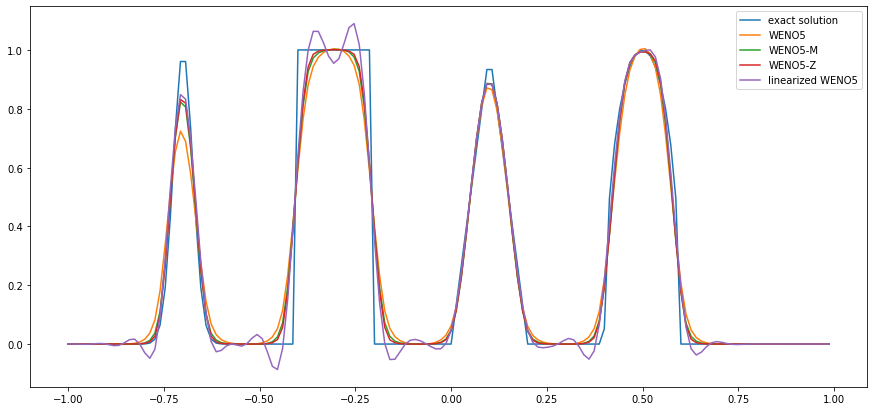

In [34]:
num_param = Data()
num_param.N = 150
num_param.X = np.linspace(-1.,1.,num_param.N,endpoint=False)
u_0 = np.array([ u0_shu(x) for x in num_param.X ])

num_param.Tf = 1.0
num_param.dt = 0.1/num_param.N # = 0.5*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5z,weno5l):
  schemes_u[scheme] = transport(u_0,rk33_iter,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [15,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u,scheme,u

Avant de faire des tests en temps long, nous allons vérifier l'ordre de la méthode WENO-Z.

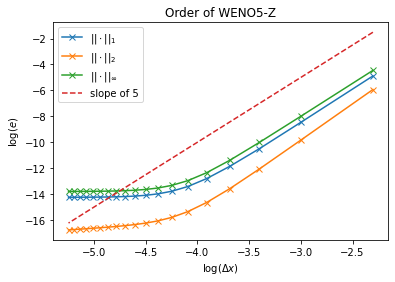

In [35]:
num_param = Data()
num_param.dt = 1./400
num_param.Tf = 1.

errors_wenoz = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_f = transport(u_0,rk33_iter,lambda u,dx:-weno5z.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_wenoz.append( (N,error(u_f,u_e)) )

space_steps = np.array([ 1./e[0] for e in errors_wenoz ])

plt.title("Order of "+weno5z.name)
plt.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_wenoz ] , "x-" , label = r"$||\cdot||_{1}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_wenoz ] , "x-" , label = r"$||\cdot||_{2}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_wenoz ] , "x-" , label = r"$||\cdot||_{\infty}$" )
plt.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
plt.xlabel(r"$\log(\Delta x)$")
plt.ylabel(r"$\log(e)$")
plt.legend()

del N,num_param,u_0,u_e,u_f,space_steps,errors_wenoz

Maintenant nous allons effectuer un test en temps long, $T_f=100$ avec le cas test de Shu, donné par la condtion initiale suivante :

$$
  u_0(x) = \begin{cases}
    \frac{1}{6}\left( G(x,\beta,z-\delta) + G(x,\beta,z+\delta) + 4G(x,\beta,z) \right) & -0.8 \leq x \leq -0.6 \\
    1  & -0.4 \leq x \leq -0.2 \\
    1 - \left| 10(x-0.1) \right| & 0 \leq x \leq 0.2 \\
    \frac{1}{6}\left( F(x,\alpha,a-\delta) + F(x,\alpha,a+\delta) + 4F(x,\alpha,a) \right) & 0.4 \leq x \leq 0.6 \\
    0 & \text{sinon}
  \end{cases}
$$

avec :
$$G(x,\beta,z) = e^{-\beta(x-z)^2}$$
$$F(x,\alpha,a) = \sqrt{\max(1-\alpha^2(x-a)^2,0)}$$
et les constantes sont données par $a = 0.5$, $z=-0.7$, $\delta = 0.005$, $\alpha=10$ et $\beta = \frac{\ln(2)}{36\delta^2}$


Le deuxième test s'effectue sur une fonction chapeau, en temps court celle-ci ne présente pas de réel intérêt, en temps plus long on y voit apparaître les défauts des différents schémas dans des conditions plus favorable d'un créneau.

$$
  u(t=0,x) = u_0(x) = \begin{cases}
     4x-1 & \text{si } x\in[\frac{1}{4},\frac{1}{2}] \\
    -4x+3 & \text{si } x\in[\frac{1}{2},\frac{3}{4}] \\
    0     & \text{sinon}
  \end{cases}
$$

WENO5
WENO5-M
WENO5-Z
linearized WENO5


<ipython-input-36-76675663be76>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


WENO5 324
WENO5-M 325
WENO5-Z 325
linearized WENO5 325


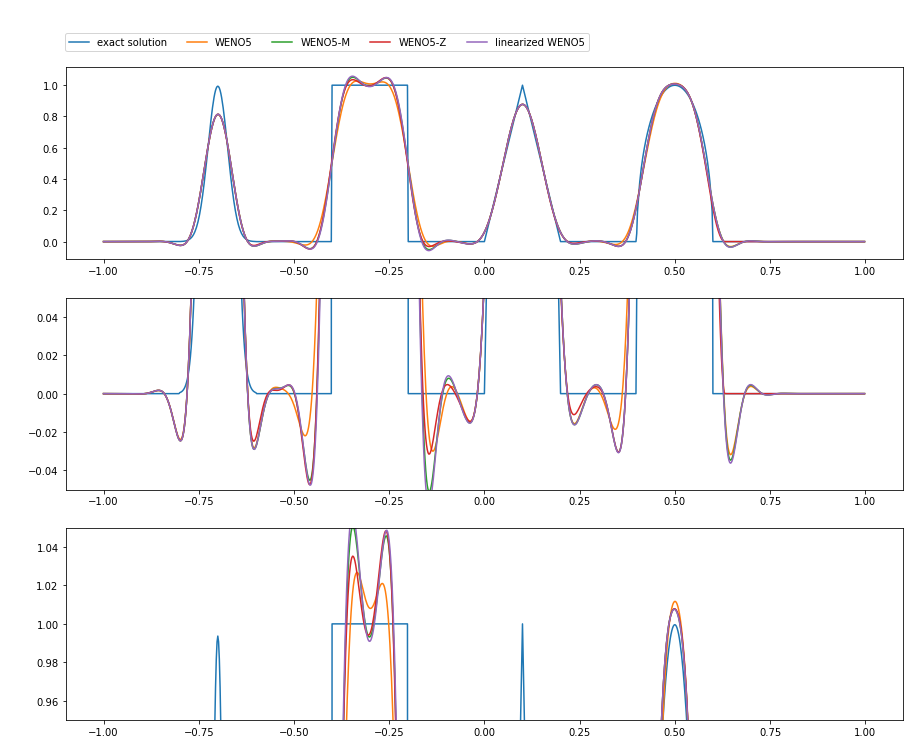

In [36]:
num_param = Data()
num_param.N = 1000
num_param.X = np.linspace(-1.,1.,num_param.N,endpoint=False)
u_0 = np.array([ u0_shu(x) for x in num_param.X ])

num_param.Tf = 100.
num_param.dt = 1./num_param.N # = dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5z,weno5l):
  print(scheme.name)
  schemes_u[scheme] = transport(u_0,rk33_iter,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,12))
ax1.plot(num_param.X,u_0,label="exact solution",color=default.palette[0])
ax2.plot(num_param.X,u_0,color=default.palette[0])
ax3.plot(num_param.X,u_0,color=default.palette[0])
i=0
for scheme,u in schemes_u.items():
  ax1.plot(num_param.X,u,label=scheme.name,color=default.palette[(i+1)%len(default.palette)])
  ax2.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  ax3.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  i+=1

ax2.set_ylim([-0.05,0.05])
ax3.set_ylim([0.95,1.05])
fig.legend(loc=(0.071,0.93),ncol=len(schemes_u)+1)
fig.show()

for scheme,u in schemes_u.items():
  print(scheme.name,sum(u<0))

del u_0,fig,ax1,ax2,ax3,num_param,schemes_u,scheme,u,i

## 1.4 B-WENO

[[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) est proposé une modification du schéma WENO plus intéressante pour l'étude de l'équation de Vlasov. Nous étudierons ici la présentation effectuée dans la seconde publication. Dans la continuation des schémas d'ordre élevé en espace, nous nous intéresserons au schéma BWENO d'ordre 6 présenté.

L'idée de ce schéma reste similaire à celle du WENO dans l'esprit du calcul de poids non linéaire s'adaptant aux irrégularités de la fonction. Le nombre de poids est en revanche limité à 2, et ceux-ci ne sont plus des polynôme en $\left(f_{i+k}^4\right)_{k\in [\![ -3,3 ]\!]}$ mais seulement de degré 2 : $\left(f_{i+k}^2\right)_{k\in [\![ -3,3 ]\!]}$. Cette diminution du nombre de multiplication peut rendre ce schéma compétitif au niveau du temps de calcul. Les solutions attendues dans la simulation de plasmas avec l'équation de Vlasov-Poisson sont régulières, l'ordre élevé des schémas sert à capturer les forts gradients de la solution qui peuvent apparaître lors de la filamentation.

Le flux $\hat{u}^{(B)}_{j-\frac{1}{2}}$ du schéma BWENO d'ordre $p$ s'obtient par l'addition pondéré de 2 interpolations $L$ et $R$, d'ordre $p-1$. Nous ne nous intéresserons ici qu'à la méthode d'ordre 6, nous nous abstiendrons donc d'indiquer l'ordre.

$$
  \hat{u}^{(B)}_{j-\frac{1}{2}} = w^{(L)}_{j-\frac{1}{2}}u^{(L)}_{j-\frac{1}{2}} + w^{(R)}_{j-\frac{1}{2}}u^{(R)}_{j-\frac{1}{2}}
$$

L'écriture du schéma commence par l'estimation des indicateurs de continuité :

$$
  \begin{aligned}
      \beta(u_i) = (\Delta^1_4u_i)\left( (\Delta^1_4u_i) + (\Delta^2_4u_i) + \frac{1}{3}(\Delta^3_2u_i) + \frac{1}{12}(\Delta^4_2u_i) \right) \\
      + (\Delta^2_4u_i)\left( \frac{4}{3}(\Delta^2_4u_i) + \frac{5}{4}(\Delta^3_2u_i) + \frac{2}{5}(\Delta^4_2u_i) \right) \\
      + (\Delta^3_2u_i)\left( \frac{83}{60}(\Delta^3_2u_i) + \frac{23}{18}(\Delta^4_2u_i) \right) \\
      + \frac{437}{315}(\Delta^4_2u_i)^2
  \end{aligned}
$$

où les $(\Delta^d_pu_i)$ sont des approximations d'ordre $p$ de la dérivée d'ordre $d$ :

$$
  \begin{aligned}
    (\Delta^1_4u_i) &= \frac{1}{12}\left( -u_{j+2} +  8u_{j+1}           -  8u_{j-1} + u_{j-2} \right) \\
    (\Delta^2_4u_i) &= \frac{1}{12}\left( -u_{j+2} + 16u_{j+1} - 30u_{j} + 16u_{j-1} - u_{j-2} \right) \\
    (\Delta^3_2u_i) &=  \frac{1}{2}\left(  u_{j+2} -  2u_{j+1}           +  2u_{j-1} - u_{j-2} \right) \\
    (\Delta^4_2u_i) &=             \left(  u_{j+2} -  4u_{j+1} +  6u_{j} -  4u_{j-1} + u_{j-2} \right) \\
  \end{aligned}
$$

Nous prendrons $\beta^{(L)}_{j-\frac{1}{2}} = \beta(u_{j-1})$ et $\beta^{(R)}_{j-\frac{1}{2}} = \beta(u_j)$ comme indicateurs de continuité respectivement à gauche et à droite.

Les 2 poids non normalisés sont :

$$
  a^{(\Xi)}_{j-\frac{1}{2}} = \frac{d}{\epsilon + \beta^{(\Xi)}_{j-\frac{1}{2}}}
$$

où $\Xi = L,R$, $d=\frac{1}{2}$ et $\epsilon$ un paramètre pour éviter la nullité du dénominateur. Ce qui nous donne les poids :

$$
  \tilde{w}^{(\Xi)}_{j-\frac{1}{2}} = \frac{a^{(\Xi)}_{j-\frac{1}{2}}}{a^{(L)}_{j-\frac{1}{2}}+a^{(R)}_{j-\frac{1}{2}}}
$$

Les poids sont ensuites classé selon la direction, ici pour une vitesse positive (dans l'étude du schéma nous prendrons $v=1$) :

$$
  \begin{cases}
    w^{(L)} = \max\left(\tilde{w}^{(L)}_{j-\frac{1}{2}},\tilde{w}^{(R)}_{j-\frac{1}{2}}\right) \\
    w^{(R)} = \min\left(\tilde{w}^{(L)}_{j-\frac{1}{2}},\tilde{w}^{(R)}_{j-\frac{1}{2}}\right)
  \end{cases}
$$

Les flux à gauche et à droite sont maintenant calculés comme suit :

$$
  \begin{cases}
    \hat{u}^{(L)}_{j-\frac{1}{2}} = \frac{1}{60}\left( -3u_{j+1}+27u_{j}+47u_{j-1} -13u_{j-2} + 2u_{j-3} \right) \\
    \hat{u}^{(R)}_{j-\frac{1}{2}} = \frac{1}{60}\left( 2u_{j+2}-13u_{j+1}+47u_{j}+27u_{j-1}-3u_{j-2}  \right) \\
  \end{cases}
$$

On peut enfin calculer une approximation de $\partial_x u$ à l'aide du flux de BWENO par :

$$
  \partial_x u \approx \frac{1}{\Delta x}\left( \hat{u}^{(B)}_{j+\frac{1}{2}} - \hat{u}^{(B)}_{j-\frac{1}{2}} \right)
$$

> Pour l'étude du schéma BWENO, l'article [[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) propose une linéarisation du schéma en prenant les poids $w^L$, $w^R$ égaux à différents couples de nombres positifs vérifiant que $w^L+w^R=1$, ainsi est tracé le coefficient d'amplification pour $w^L=1,\frac{3}{4},\frac{1}{2}$. En effet différents éléments empêche facilement d'écrire les poids sous la forme $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$ comme les précédentes modifications du schéma WENO.

In [37]:
def bweno5_flux ( wl=None , wr=None ) :
  """
    return expression of all BWENO scheme
    it could be linearized with optional special weight `wl` and `wr`. By default it is not linearized,
    if only `wl` is done then `wr = 1-wl`.
  """
  
  def beta ( k ) :
    """
      Indicator of smootheness of BWENO method
    """
    D14uj = sp.Rational(1,12)*( -f(k+2) +  8*f(k+1)             -  8*f(k-1) + f(k-2) )
    D24uj = sp.Rational(1,12)*( -f(k+2) + 16*f(k+1) - 30*f(k+0) + 16*f(k-1) - f(k-2) )
    D32uj =  sp.Rational(1,2)*(  f(k+2) -  2*f(k+1)             +  2*f(k-1) - f(k-2) )
    D42uj =                   (  f(k+2) -  4*f(k+1) +  6*f(k+0) -  4*f(k-1) + f(k-2) )

    return ( D14uj*( D14uj + D24uj + sp.Rational(1,3)*D32uj + sp.Rational(1,12)*D42uj )
           + D24uj*( sp.Rational(4,3)*D24uj + sp.Rational(5,4)*D32uj + sp.Rational(2,5)*D42uj )
           + D32uj*( sp.Rational(83,60)*D32uj + sp.Rational(23,18)*D42uj )
           + sp.Rational(437,315)*D42uj*D42uj )
  
  if wl==None :
    b5Rjm12 = beta(0)
    b5Ljm12 = beta(-1)

    a5Ljm12 = sp.Rational(1,2)/( epsilon + b5Ljm12 )
    a5Rjm12 = sp.Rational(1,2)/( epsilon + b5Rjm12 )
    
    wt5Ljm12 = a5Ljm12 / ( a5Ljm12 + a5Rjm12 )
    wt5Rjm12 = a5Rjm12 / ( a5Ljm12 + a5Rjm12 )
    
    w5Ljm12 = sp.Max(wt5Ljm12,wt5Rjm12)
    w5Rjm12 = sp.Min(wt5Ljm12,wt5Rjm12)
  else :
    w5Ljm12 = wl
    if wr == None:
      w5Rjm12 = 1-wl
    else:
      w5Rjm12 = wr
  
  u5Ljm12 = sp.Rational(1,60)*( -3*f(+1) + 27*f(+0) + 47*f(-1) - 13*f(-2) + 2*f(-3) )
  u5Rjm12 = sp.Rational(1,60)*(  2*f(+2) - 13*f(+1) + 47*f(+0) + 27*f(-1) - 3*f(-2) )
  
  u6Bjm12 = w5Ljm12*u5Ljm12 + w5Rjm12*u5Rjm12
  u6Bjp12 = u6Bjm12.subs(symbols_to(f_stencil, lambda j,_:f(j+1)),simultaneous=True)
  return u6Bjp12-u6Bjm12

bweno5 = Data()
bweno5.name = "B-WENO"
bweno5.flux = bweno5_flux
del bweno5_flux

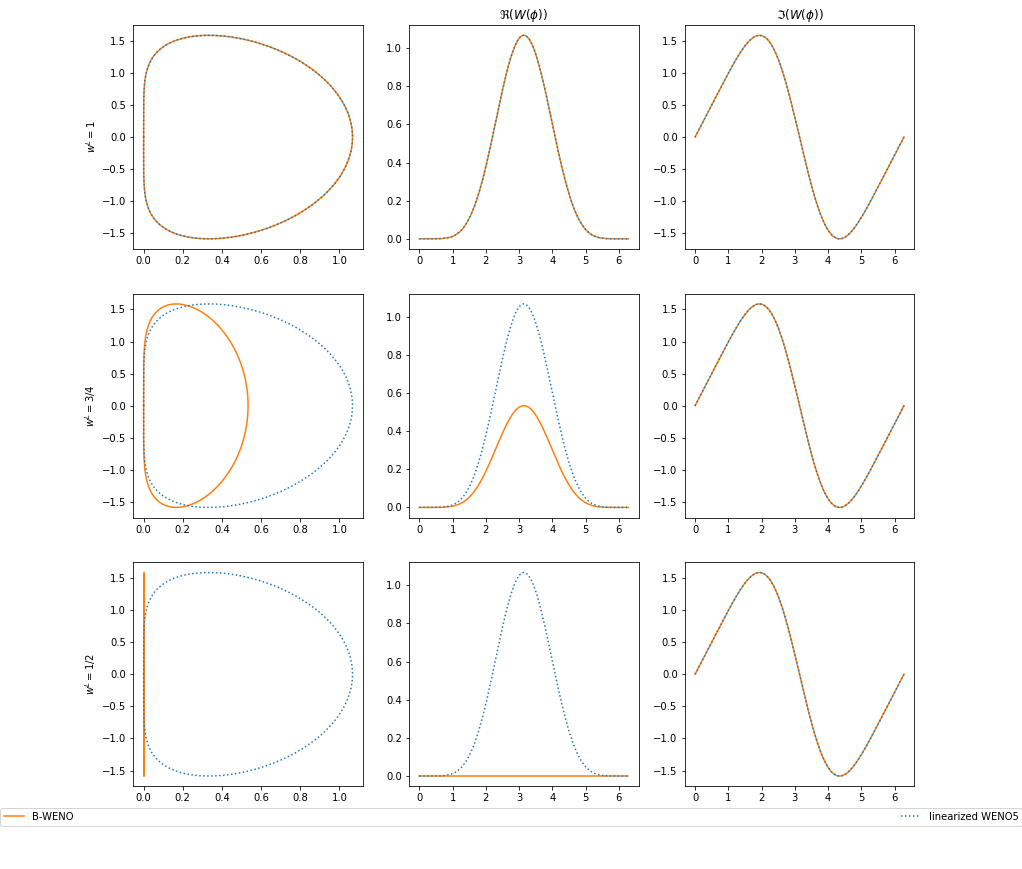

In [38]:
bweno5.wl = Data()
bweno5.wl.values = (1,sp.Rational(3,4),sp.Rational(1,2))
bweno5.wl.func = [ sp.lambdify(phi,bweno5.flux(wl).subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-8)),'numpy') for wl in bweno5.wl.values ]
bweno5.wl.data = [ f(data.phi) for f in bweno5.wl.func ]

fig, ax = plt.subplots(nrows=len(bweno5.wl.values),ncols=3,figsize=(14,14))

weno5l.ztilde.re,weno5l.ztilde.im = reim(weno5l.ztilde.data)

for i,wl in enumerate(bweno5.wl.values) :
  tmp_re,tmp_im = reim(bweno5.wl.data[i])
  ax[i][0].plot(tmp_re,tmp_im,label=bweno5.name,color=default.palette[1])
  ax[i][0].plot(weno5l.ztilde.re,weno5l.ztilde.im,':',label=weno5l.name,color=default.palette[0])
  ax[i][0].set_ylabel("$w^L = {}$".format(wl))
  
  ax[i][1].plot(data.phi,tmp_re,label=bweno5.name,color=default.palette[1])
  ax[i][1].plot(data.phi,weno5l.ztilde.re,':',label=weno5l.name,color=default.palette[0])
  
  ax[i][2].plot(data.phi,tmp_im,label=bweno5.name,color=default.palette[1])
  ax[i][2].plot(data.phi,weno5l.ztilde.im,':',label=weno5l.name,color=default.palette[0])

ax[0][1].title.set_text("$\\Re(W(\phi))$")
ax[0][2].title.set_text("$\\Im(W(\phi))$")
handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc=(0.,0.05),ncol=2,mode="expand",borderaxespad=0.)
plt.show()

del fig,ax,i,wl,handles,labels,tmp_re,tmp_im

En linéarisant les poids ($w^L=1,\frac{3}{4},\frac{1}{2}$), on remarque un comportement similaire à celui du schéma WENO linéarisé (qui coïncide parfaitement pour $w^L=1$, $w^R=0$), avec un comportement dégénéré dans le cas centré $w^L = w^R = \frac{1}{2}$ (transport pur sans diffusion). La partie imaginaire, même dans le cas non linéarisé, la méthode BWENO reproduit le même comportement que la méthode WENO linéarisée.

In [39]:
def _bweno5(u_i,dx):
  """
    _bweno5
    return the B-WENO approximation of $\partial_x u$
  """
  #u_ip3 = np.array([*u_i[3:],*u_i[:3]])
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  u_im3 = np.array([*u_i[-3:],*u_i[:-3]])

  def _beta(uim2,uim1,ui,uip1,uip2):
    d14u = 1./12.*(-uip2 -  8.*uip1 - 8.*uim1 + uim2)
    d24u = 1./12.*(-uip2 + 16.*uip1 - 30.*ui + 16.*uim1 - uim2)
    d32u = 0.5*(uip1 - 2.*uip1 + 2.*ui - uim2)
    d42u = uip2 - 4.*uip1 + 6.*ui - 4.*uim1 + uim2
    return ( d14u*(d14u + d24u + 1./3.*d32u + 1./12.*d42u)
           + d24u*(4./3.*d24u + 1.25*d32u + 0.4*d42u)
           + d32u*(83./60.*d32u + 23./18.*d42u)
           + 437./315.*d42u*d42u)

  betaL = _beta(u_im3,u_im2,u_im1,u_i  ,u_ip1)
  betaR = _beta(u_im2,u_im1,u_i  ,u_ip1,u_ip2)
  alphaL,alphaR = [ 0.5/(1e-16 + b) for b in (betaL,betaR) ]
  sum_alpha = alphaL+alphaR
  wtL,wtR = [ a/sum_alpha for a in (alphaL,alphaR) ]
  wL = np.maximum(wtL,wtR)
  wR = np.minimum(wtL,wtR)

  uL = 1./60.*( -3.*u_ip1 + 27.*u_i   + 47.*u_im1 - 13.*u_im2 + 2.*u_im3 )
  uR = 1./60.*(  2.*u_ip2 - 13.*u_ip1 + 47.*u_i   + 27.*u_im1 - 3.*u_im2 )
  uB = wL*uL + wR*uR

  uBp1 = np.array([*uB[1:],*uB[:1]])
  return (uBp1-uB)/dx
  
bweno5.func = _bweno5
del _bweno5

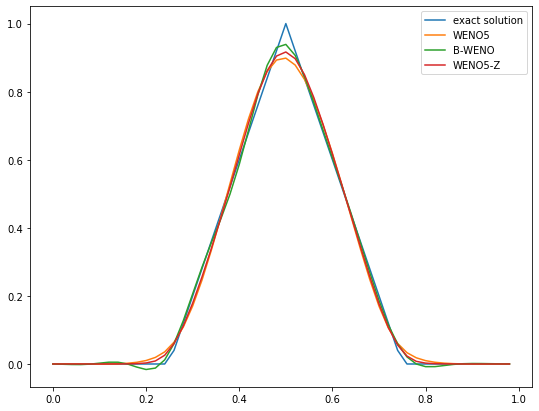

In [40]:
num_param = Data()
num_param.N = 50
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = (4.*num_param.X-1)*(num_param.X*(num_param.X<=0.5)>0.25) + (-4.*num_param.X+3)*(num_param.X*(num_param.X<0.75)>0.5)

num_param.Tf = 10
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,bweno5,weno5z):
  schemes_u[scheme] = transport(u_0,rk33_iter,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u,scheme,u

On obtient un schéma qui diffuse moins que le schéma WENO-Z, il trouve ainsi son intérêt pour approximer au mieux des pics. Cela se fait au détriment du caractère oscillant.

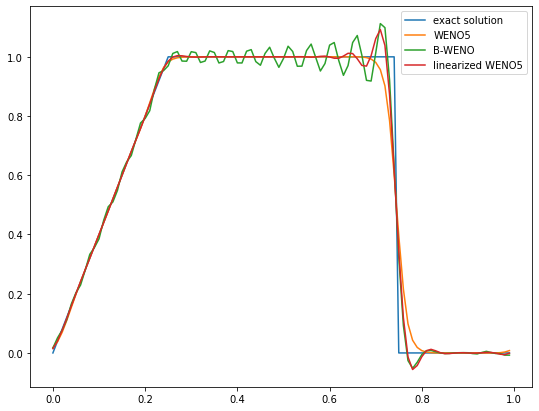

In [41]:
num_param = Data()
num_param.N = 100
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 4.*num_param.X*(num_param.X<=0.25) + 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,bweno5,weno5l):
  schemes_u[scheme] = transport(u_0,rk33_iter,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u,scheme,u

On peut vérifier l'ordre du schéma. Pour cela on calcule l'erreur sur une advection à vitesse 1 :

$$
  \begin{cases}
    u_t + u_x = 0 \\
    u^0(x) = u(t=0,x) = \cos(2\pi x)
  \end{cases}
$$

On peut maintenant calculer l'ordre de la méthode sur ce problème de transport, en calculant la solution pour différents $\Delta x$ (on choisit différentes tailles de vecteur en entré), jusqu'au temps $T_f=1$ avec un pas de temps $\Delta t = \frac{1}{400}$ qui correspond environ à $\Delta t \leq \frac{1}{2}\Delta x_{\text{min}}$, pour minimiser l'erreur en temps.


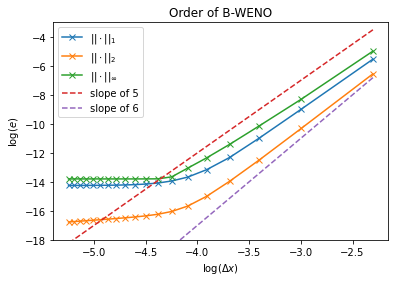

In [42]:
num_param = Data()
num_param.dt = 1./400
num_param.Tf = 1.

errors_bweno = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_f = transport(u_0,rk33_iter,lambda u,dx:-bweno5.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_bweno.append( (N,error(u_f,u_e)) )

space_steps = np.array([ 1./e[0] for e in errors_bweno ])

plt.title("Order of "+bweno5.name)
plt.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_bweno ] , "x-" , label = r"$||\cdot||_{1}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_bweno ] , "x-" , label = r"$||\cdot||_{2}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_bweno ] , "x-" , label = r"$||\cdot||_{\infty}$" )
plt.plot( np.log(space_steps) , 5*np.log(space_steps)+8 , "--" , label = "slope of 5")
plt.plot( np.log(space_steps) , 6*np.log(space_steps)+7 , "--" , label = "slope of 6")
plt.xlabel(r"$\log(\Delta x)$")
plt.ylabel(r"$\log(e)$")
plt.legend()
plt.ylim([-18,-3])
plt.show()

del N,num_param,u_0,u_e,u_f,space_steps,errors_bweno

[[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) annonce un ordre 6, mais ce n'est pas flagrant numériquement. Est-ce juste une définition différente de l'ordre ?

## 1.5 WENO3

Après avoir présenté les méthodes WENO dites *classiques* que sont la méthode WENO d'ordre 5 et ses dérivées, attardons nous un peu sur la méthode WENO3, étrangement moins étudiée. La méthode est beaucoup plus succinte mais se présente de manière similaire avec un calcul d'indicateurs de continuité, puis de poids que l'on normalise, et enfin le calcul du flux.

Les indicateurs de continuités $\beta_0$ et $\beta_1$ se calculent comme suit :

$$
  \begin{aligned}
    \beta_0^+ &= \left(-f_{i-1}^+ + f_{i}^+\right)^2\\
    \beta_1^+ &= \left(-f_{i}^+ + f_{i+1}^+\right)^2
  \end{aligned}
$$

$$
  \begin{aligned}
    \beta_0^- &= \left(-f_{i+2}^- + f_{i+1}^-\right)^2\\
    \beta_1^- &= \left(-f_{i+1}^- + f_{i}^-\right)^2
  \end{aligned}
$$

Ensuite les poids :

$$
  \alpha_i^\pm = \frac{\gamma_i}{(\epsilon+\beta_i^\pm)^2}
$$

avec $\gamma_0 = \frac{1}{3}$ et $\gamma_1=\frac{2}{3}$ ; poids que l'on normalisent :

$$
  w_i^\pm = \frac{w_i}{w_0+w_1}
$$

Enfin le flux, définit par :

$$
  f_{i+\frac{1}{2}}^+ = w_0^+\left(-\frac{1}{2}f_{i-1}^+ + \frac{3}{2}f_i^+\right) + w_1^+\left(\frac{1}{2}f_i^++\frac{1}{2}f_{i+1}^+\right)
$$

$$
  f_{i+\frac{1}{2}}^- = w_0^-\left(-\frac{1}{2}f_{i+2}^- + \frac{3}{2}f_{i+1}^-\right) + w_1^-\left(\frac{1}{2}f_{i+1}^-+\frac{1}{2}f_{i}^-\right)
$$

La méthode WENO3 prend la forme finale :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}\left[ \left(f_{j+\frac{1}{2}}^+ - f_{j-\frac{1}{2}}^+ \right) + \left(f_{j+\frac{1}{2}}^- - f_{j-\frac{1}{2}}^- \right) \right]
$$

Pour l'étude de la stabilité nous ne prendrons que le cas $f^+(u) = u$ et $f^-(u) =0$

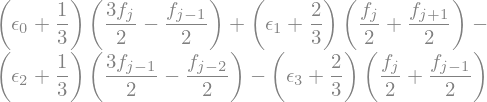

In [43]:
"""
linearized WENO method
"""
weno3l = Data()
weno3l.name = "linearized WENO3"

def weno3l_flux () :
  w0 = sp.Rational(1,3) + ei[0]
  w1 = sp.Rational(2,3) + ei[1]
  
  w2 = sp.Rational(1,3) + ei[2]
  w3 = sp.Rational(2,3) + ei[3]
  
  fjp12 = ( w0*( -sp.Rational(1,2)*f(-1) + sp.Rational(3,2)*f(+0) )
          + w1*(  sp.Rational(1,2)*f(+0) + sp.Rational(1,2)*f(+1) ) )
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({ei[0]:ei[2],ei[1]:ei[3]})
  
  return fjp12 - fjm12

weno3l.flux = weno3l_flux()
del weno3l_flux
display(weno3l.flux)

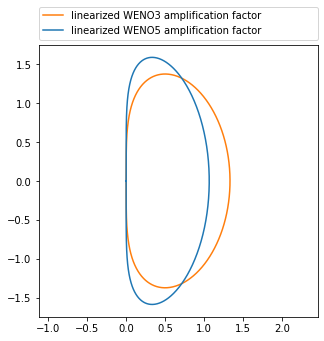

In [44]:
weno3l.ztilde = Data()

weno3l.ztilde.flux = weno3l.flux.expand().subs([(e,0) for e in ei])
weno3l.ztilde.func = sp.lambdify(phi,weno3l.ztilde.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
weno3l.ztilde.data = weno3l.ztilde.func(data.phi)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(*reim(weno3l.ztilde.data),label=weno3l.name+" amplification factor",color=default.palette[1])
plt.plot(*reim(weno5l.ztilde.data),label=weno5l.name+" amplification factor",color=default.palette[0])
plt.axis('equal')
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Comme indiqué dans la littérature, la méthode WENO3 diffuse plus que son équivalent d'ordre 5, cela se remarque par une plus grande partie imaginaire.

In [45]:
def _weno3(u_i,dx):
  """
    _weno3
    return the WENO3 approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])

  b0 = np.square( -u_im1 + u_i   )
  b1 = np.square( -u_i   + u_ip1 )

  alpha  = [ g_i/np.square(b_i+1e-6) for b_i,g_i in zip((b0,b1),(1./3.,2./3.)) ]
  sum_alpha = sum(alpha)
  w0,w1 = [ a_i/sum_alpha for a_i in alpha ]

  fip12 = w0*( -0.5*u_im1 + 1.5*u_i ) + w1*( 0.5*u_i + 0.5*u_ip1 )
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

def _weno3l(u_i,dx):
  """
    _weno3l
    return the linearized WENO3 approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])

  w0,w1 = (1./3.,2./3.)

  fip12 = w0*( -0.5*u_im1 + 1.5*u_i ) + w1*( 0.5*u_i + 0.5*u_ip1 )
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

weno3l.func = _weno3l

weno3 = Data()
weno3.name = "WENO3"
weno3.func = _weno3
del _weno3,_weno3l

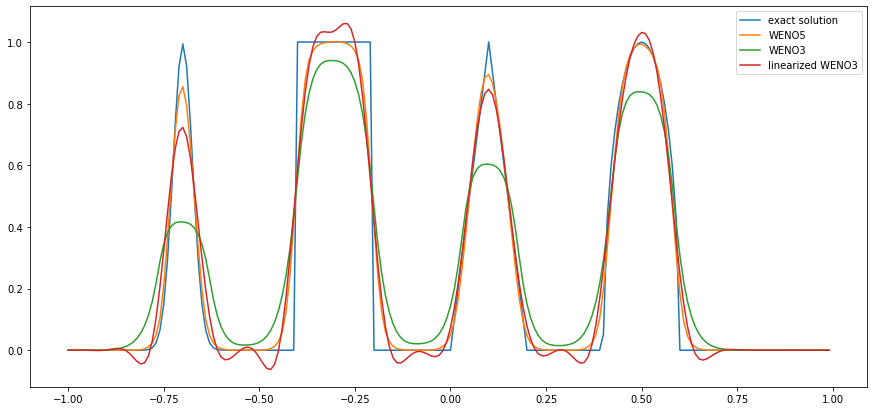

In [46]:
num_param = Data()
num_param.N = 200
num_param.X = np.linspace(-1.,1.,num_param.N,endpoint=False)
u_0 = np.array([ u0_shu(x) for x in num_param.X ])

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno3,weno3l):
  schemes_u[scheme] = transport(u_0,rk33_iter,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [15,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0,scheme,num_param,schemes_u,u

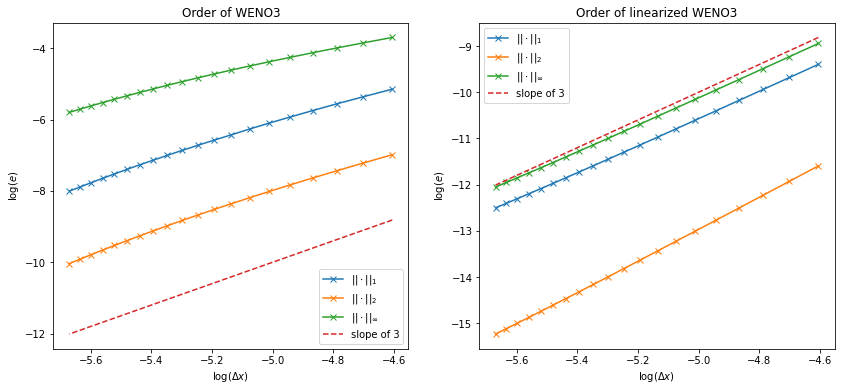

In [47]:
num_param = Data()
num_param.dt = 1./500
num_param.Tf = 1.

errors_weno3l = []
errors_weno3  = []

for N in range(100,300,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_fl = transport(u_0,rk33_iter,lambda u,dx:-weno3l.func(u,dx),num_param.Tf,num_param.dt)
    u_f  = transport(u_0,rk33_iter,lambda u,dx:-weno3.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_weno3l.append( (N,error(u_fl,u_e)) )
    errors_weno3.append( (N,error(u_f,u_e)) )

del N,num_param,u_0,u_e,u_fl,u_f

space_steps = np.array([ 1./e[0] for e in errors_weno3 ])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.set_title("Order of "+weno3.name)
ax1.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_weno3 ] , "x-" , label = r"$||\cdot||_{1}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_weno3 ] , "x-" , label = r"$||\cdot||_{2}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_weno3 ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax1.plot( np.log(space_steps) , 3*np.log(space_steps)+5 , "--" , label = "slope of 3")
ax1.set_xlabel(r"$\log(\Delta x)$")
ax1.set_ylabel(r"$\log(e)$")
ax1.legend()

ax2.set_title("Order of "+weno3l.name)
ax2.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_weno3l ] , "x-" , label = r"$||\cdot||_{1}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_weno3l ] , "x-" , label = r"$||\cdot||_{2}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_weno3l ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax2.plot( np.log(space_steps) , 3*np.log(space_steps)+5 , "--" , label = "slope of 3")
ax2.set_xlabel(r"$\log(\Delta x)$")
ax2.set_ylabel(r"$\log(e)$")
ax2.legend()

plt.show()

del fig,ax1,ax2,space_steps,errors_weno3l,errors_weno3

Voilà qui conclu l'étude des schémas en espace.

# 2. Discrétisation en temps

## 2.1 Méthodes Runge-Kutta explicites

Les schémas Runge-Kutta sont souvent utilisés dans le domaine des EDP pour résoudre la discrétisation en temps, conforme à cette tradition c'est ce que nous allons effectuer. Nous cherchons quel est l'ordre minimale $n$ ainsi que le nombre d'étages $s$ pour stabiliser le couple RK($s$,$n$)-WENO5, ou celui qui permettra d'obtenir la plus grande CFL avec le minimum de coût numérique.

On s'intéresse ici à la fonction de stabilité d'un schéma RK. On sait que le polynôme caractéristique d'un schéma RK($n$,$n$) est une troncature de la série entière de l'exponentielle (auquel peut s'ajouter des termes de degré plus élevé si le nombre d'étage $s$ est supérieur à l'ordre de la méthode $n$), donc de la forme :

$$
  p_{(n,n)}(z) = \sum_{k=0}^n \frac{z^k}{k!}
$$

Il est ensuite nécessaire de tracer la courbe d'équation $|p_{(n,n)}(z)| = 1$, pour cela Miguel m'a proposé de résoudre dans un premier temps l'équation :

$$
  p_{(n,n)}(z) = e^{i\theta}
$$

à $\theta$ fixé, on a ainsi $n$ solutions $(b_0(\theta),\dots,b_n(\theta))$. Puis ensuite faire varier $\theta \in [0,2\pi[$. On obtient ainsi $n$ courbes paramétriques que l'on peut tracer sans trop de problèmes.

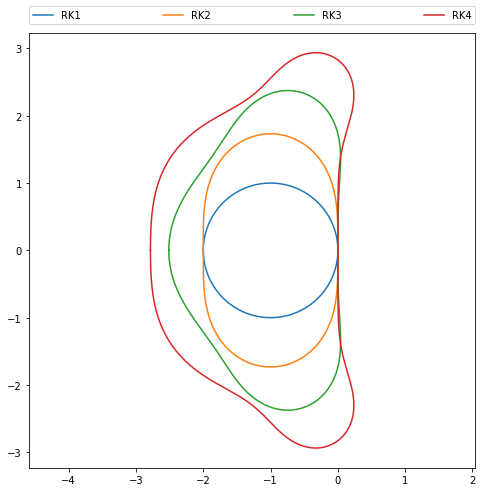

In [48]:
import math

def poly_carac(N):
  """
    return trunc developpement of exponential function to the order `N`
  """
  return sum([ sp.Rational(1,(math.factorial(n)))*z**n for n in range(N+1) ])

def rk_set(N):
  """
    return a list of points where modulus of caracteristic polynomial is equal to 1
    this function compute this set of points with a polynomial solver in C, so it
    doesn't work for `N > 4`.
  """
  theta = sp.symbols("\\theta",real=True)
  p = poly_carac(N)
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  
  bcurve = []
  for b in [ sp.lambdify(theta,b,'numpy') for b in bset ] :
    tmp = b(data.phi)
    bcurve.extend(tmp.tolist())
  return np.array(sorted(bcurve,key=lambda z:np.angle(z+1)))

plt.rcParams['figure.figsize'] = [8,8]
plt.plot(*reim(rk_set(1)),label="RK1")
plt.plot(*reim(rk_set(2)),label="RK2")
plt.plot(*reim(rk_set(3)),label="RK3")
plt.plot(*reim(rk_set(4)),label="RK4")
plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Ces fonctions de stabilités ne sont que celles d'une méthode RK($n$,$n$), avec $n<5$ pour pouvoir résoudre de façon exacte les racines du polynôme. Il est possible de tracer directement un contour avec `matplotlib` à l'aide de la fonction `plt.contour`. On peut ainsi obtenir, en un temps relativement court, un ensemble de points. En plus de tracer cet ensemble de points, il est également possible de récupérer la liste des points tracés, à l'aide de l'attribut `allsegs` de la classe `matplotlib.contour.QuadContourSet`.

> **Attention :** `matplotlib` permet de récupérer la liste des points tracés, si le domaine d'étude est trop resteint, seuls les points se trouvant dans ce domaine seront listés. Comme son nom l'indique l'attribut `allsegs` renvoie des listes de points qui forment les segements tracés, par conséquent il est possible de récupérer chaque sous ensemble connexe (ce qui permet d'exclure l'étude des non-connexités des méthodes Runge-Kutta avec plus d'étages.

In [49]:
def contour ( expr , z , Ir=(-6.,3.,500) , Ii=(-6.,6.,500) , **kwargs):
  """
    draw a contour of a C expression `expr` on `z` parameter on `Ir`x`Ii` domain
  """
  x,y = sp.symbols("x y",real=True)
  f = sp.lambdify((x, y), expr.subs(z,x+I*y),'numpy')
  
  a = np.linspace(*Ir)
  b = np.linspace(*Ii)
  X, Y = np.meshgrid(a, b)
  try:
    lab = kwargs.pop("label")
  except:
    lab = ""
  try:
    c = kwargs["colors"]
  except:
    c = default.palette[0]
  if len(lab) > 0 :
    plt.plot([0],[0],label=lab,color=c)
  return plt.contour(X,Y, np.real(f(X,Y)),**kwargs)

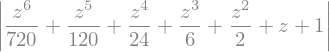

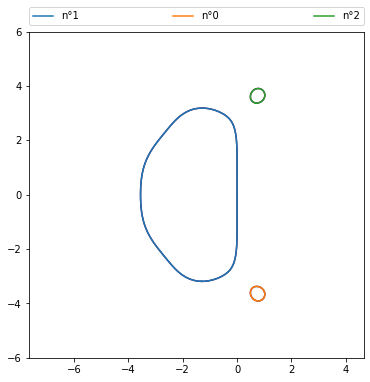

nombre de points dans chaque sous-domaine :
105 927 105


In [50]:
R = sp.Abs(poly_carac(6))

plt.rcParams['figure.figsize'] = [6,6]

dat = contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.]).allsegs

display(R)
plt.plot(dat[0][1][:,0],dat[0][1][:,1],label="n°{}".format(1))
plt.plot(dat[0][0][:,0],dat[0][0][:,1],label="n°{}".format(0))
plt.plot(dat[0][2][:,0],dat[0][2][:,1],label="n°{}".format(2))
plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

# comparaison du nombre de point dans la frontière de chaque sous domaine
print("nombre de points dans chaque sous-domaine :")
print(len(dat[0][0][:]),len(dat[0][1][:]),len(dat[0][2][:]))

del R,dat

> L'astuce trouvé pour obtenir le domaine principal et qui sera utilisé par la suite, est de liste les sous domaine `allsegs` et de les trier par nombre de points. Le domaine *principal* qui permettra de stabiliser un schéma type WENO, ou méthode centré par exemple, est (quasi-systématiquement) celui ayant le plus de points.
> 
> **Cette méthode n'a rien de mathématique, juste une constatation empirique**.

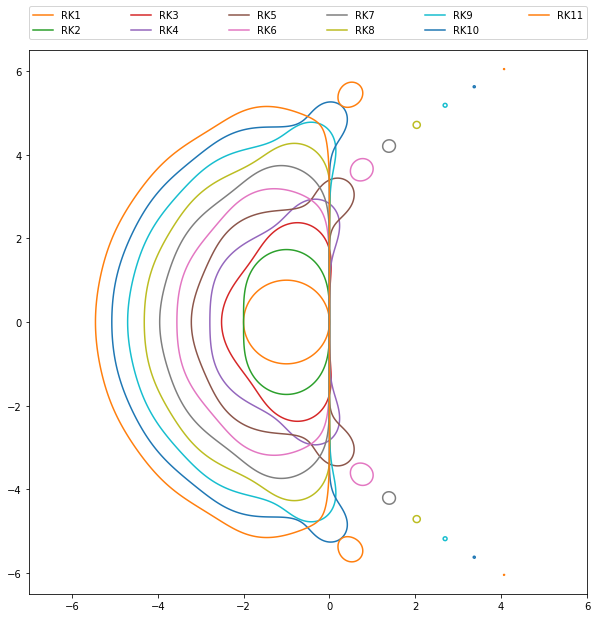

In [51]:
plt.rcParams['figure.figsize'] = [10,10]

for n in range(1,12):
  print(n,end="\r")
  R = sp.Abs(poly_carac(n))
  contour(R,z,(-7,6,1000),(-6.5,6.5,1000), levels=[1.],colors=default.palette[n%len(default.palette)],label="RK{}".format(n))
print(" "*len(str(n)))
plt.legend(loc=(0.,1.02),ncol=6,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del n,R

> Joackim m'a fait remarquer que les *bras* contiennent une infinité de *bulles* de plus en plus petites (on voit ceci pour la petite *bulle* orange à l'extrémité du *bras* qui apparait seulement lorsque on raffine le domaine). On peut même conjecturer que la forme des bras sont des paraboles. On voit la naissance de la deuxième paire de *bras* avec les grosses *bulles* oranges.
>
> L'étude de ces non-connexités des domaines de stabilités ne semblent pas présenter d'intérêt pour ce que l'on fait. De plus ces domaines ne correspondent pas à la stabilité d'une méthode connue. En effet il n'y a pas de méthode Runge-Kutta d'ordre $n$ à $n$ étages connues pour $n\geq 5$.

L'étude de ces méthodes RK($n$,$n$) avec $n>4$ n'est pas pertinante puisqu'il n'existe pas de méthode Runge-Kutta d'ordre 5 à 5 étages, le problème est similaire pour les méthodes d'ordre supérieur. À partir de maintenant nous allons étudier ces méthodes à partir de leur écriture sous forme de schéma ou de tableau de Butcher. Par la suite, le tableau de Butcher sera plus pratique pour tirer plus d'information comme le schéma de Lawson induit.

### 2.1.1 Obtention de la fonction de stabilité depuis un schéma numérique

Les calculs effectués pour l'instant ne s'appliquent que pour un RK($n$,$n$) à $n$ étages. Considérons maintenant un RK($s$,$n$) à $s$ étages ($s\geq n$ car la méthode est explicite). Il est nécessaire de calculer sa fonction de stabilité (qui est un polynôme dans le cadre des méthodes explicites).

L'obtention de la fonction de stabilité s'effectue avec une fonction $L$ linéaire, ainsi pour un problème du type :

$$
  \frac{\mathrm{d}u}{\mathrm{d}t} = L(t,u)
$$

on effectue la substitution :

* $L(t,u) \rightarrow \lambda u$ (on linéarise $L$ sur le plan complexe à l'aide d'une variable $\lambda$, dans notre cas $\lambda$ représente le coefficient d'amplification de notre discrétisation en espace)
* $\lambda \Delta t \rightarrow z$ (on veut étudier le coefficient d'amplification donné par le produit $\lambda \Delta t$)

Nous étudions ainsi un schéma RK(4,3) :

$$
  \begin{aligned}
    u^{(1)} &= u^n + \frac{1}{2}\Delta t L(t^n,u^n) \\
    u^{(2)} &= u^{(1)} + \frac{1}{2}\Delta t L(t^n+\frac{1}{2}\Delta t,u^{(1)}) \\
    u^{(3)} &= \frac{2}{3}u^n + \frac{1}{3}u^{(2)} + \frac{1}{6}\Delta t L(t^n+\Delta t,u^{(2)}) \\
    u^{n+1} &= u^{(3)} + \frac{1}{2}\Delta t L(t^n+\frac{1}{2}\Delta t,u^{(3)})
  \end{aligned}
$$

La méthode sera dite de *Shu-Osher* si elle n'effectue qu'un seul appel à la fonction $L$ par étage, on verra plus tard que pour un tableau de Butcher donné, il est facilement possible de *shuosheriser* la méthode.

In [52]:
un = sp.symbols("u_n")

lamb = sp.symbols("\\lambda",complex=True)
L = sp.Function("L")

def name_stages ( v_s , s ) :
  """
    return a list of symbols for each stages of a RK(`s`,$n$) method on a `v_s (str)` name function
    for example :
    ```
      name_stages("u",3) #-> should return list of symbols "[u^n, u^{(1)}, u^{(2)}, u^{n+1}]"
    ```
  """
  vs = [ sp.symbols(v_s+"^n") ]
  vs.extend([ sp.symbols(v_s+"^{(%i)}"%j) for j in range(1,s) ])
  vs.append(sp.symbols(v_s+"^{n+1}"))
  return vs

class rk_scheme (object) :
  ui = name_stages("u",42)
  def __init__ (self,s,label="") :
    self.s = s
    self.stages = [0 for x in range(s)]
    self.ui = rk_scheme.ui[:s]; self.ui.append(rk_scheme.ui[-1])
    self.label = label

  def __getitem__ (self,s) :
    return self.stages[s]
  def __setitem__ (self,key,value) :
    self.stages[key]=value
    
  def scheme (self) :
    return [ sp.Eq(self.ui[s],stage) for s,stage in enumerate(self.stages,1) ]

  def stability_function (self) :
    expr = self.stages[-1]
    for i,us in enumerate(reversed(self.stages[:-1])) :
      expr = expr.subs(self.ui[self.s-1-i],us)
    return expr.replace(L,lambda x:lamb*x).subs(lamb*dt,z).expand().subs(self.ui[0],1).collect(z)
  
  def stability_domain (self,Ir=(-4.,2.,100),Ii=(-3.,3.,100),**kwargs) :
    return contour(sp.Abs(self.stability_function()),z,Ir,Ii,levels=[1.],label=self.label,**kwargs)

un,u1,u2,u3,u4,u5,u6,u7 = rk_scheme.ui[0:8]

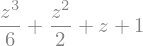

In [53]:
"""
test process on RK3 Shu-Osher
"""
rk33so = rk_scheme(3,label="RK(3,3) Shu-Osher")
rk33so[0] = un + dt*L(un)
rk33so[1] = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*L(u1)
rk33so[2] = sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*L(u2)

rk33so.stability_function()

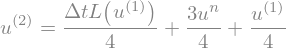

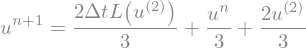

In [54]:
[ display(stage) for stage in rk33so.scheme()];

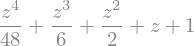

In [55]:
""" RK3 à 4 étages """
rk43 = rk_scheme(4,label="RK(4,3)")
rk43[0] = un + sp.Rational(1,2)*dt*L(un)
rk43[1] = u1 + sp.Rational(1,2)*dt*L(u1)
rk43[2] = sp.Rational(2,3)*un + sp.Rational(1,3)*u2 + sp.Rational(1,6)*dt*L(u2)
rk43[3] = u3 + sp.Rational(1,2)*dt*L(u3)

rk43.stability_function()

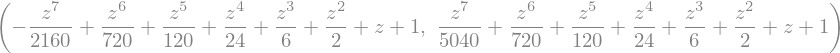

In [56]:
""" RK6 à 7 étages [Luther H. A. (1968)] """
nu = sp.symbols("\\nu")
s21 = sp.sqrt(21)

rk76 = rk_scheme(8,label="RK(7,6)")
rk76.ui = name_stages("k",8)
rk76.ui[0] = rk_scheme.ui[0]
rk76.ui[-1] = rk_scheme.ui[-1]
k1,k2,k3,k4,k5,k6,k7 = rk76.ui[1:-1]

rk76[0] = dt*L(un)
rk76[1] = dt*L(un+nu*k1)
rk76[2] = dt*L(un+ ((4*nu-1)*k1+k2)/(8*nu) )
rk76[3] = dt*L(un+ ((10*nu-2)*k1 + 2*k2 + 8*nu*k3)/(27*nu) )
rk76[4] = dt*L(un+ (-((77*nu-56)+(17*nu-8)*s21)*k1
                -8*(7+s21)*k2 + 48*(7+s21)*nu*k3
                -3*(21+s21)*nu*k4)/(392*nu) )
rk76[5] = dt*L(un+ (-5*((287*nu-56)-(59*nu-8)*s21)*k1
                - 40*(7-s21)*k2 + 320*s21*nu*k3 + 3*(21-121*s21)*nu*k4
                + 392*(6-s21)*nu*k5)/(1960*nu) )
rk76[6] = dt*L(un+ ( 15*((30*nu-8)-(7*nu*s21))*k1 + 120*k2
                - 40*(5+7*s21)*nu*k3 + 63*(2+3*s21)*nu*k4
                - 14*(49-9*s21)*nu*k5 + 70*(7+s21)*nu*k6)/(180*nu) )
rk76[7] = un + (9*k1 + 64*k3 + 49*k5 + 49*k6 + 9*k7)/180

display((rk76.stability_function(),poly_carac(7)))
del s21,nu,k1,k2,k3,k4,k5,k6,k7

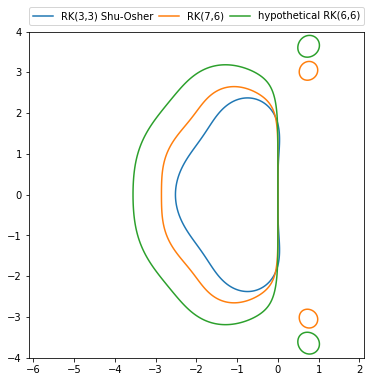

In [57]:
plt.rcParams['figure.figsize'] = [6,6]

rk33so.stability_domain(colors=default.palette[0],Ir=(-6.,2.,500),Ii=(-4.,4.,500))
rk76.stability_domain(colors=default.palette[1],Ir=(-6.,2.,500),Ii=(-4.,4.,500))
contour(sp.Abs(poly_carac(6)),z,(-6.,2.,500),(-4.,4.,500), levels=[1.],colors=default.palette[2],label="hypothetical RK(6,6)")

plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

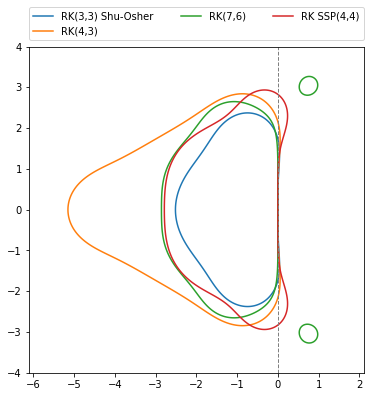

In [58]:
plt.rcParams['figure.figsize'] = [6,6]

for i,rk in enumerate((rk33so,rk43,rk76)) :
  rk.stability_domain((-6.,2.,500),(-4.,4.,500),colors=default.palette[i])
contour(sp.Abs(poly_carac(4)),z,(-6.,2.,500),(-4.,4.,500), levels=[1.],colors=default.palette[i+1],label="RK SSP(4,4)")

plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)

plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del i,rk

### 2.1.2 Obtention de la fonction de stabilité depuis un tableau de Butcher

Il est souvent plus simple de ne donner qu'un tableau de Butcher d'une méthode, et cela permet en réalité d'extraire plus d'informations. Dans un premier temps, l'implémentation, se limitera aux méthodes eRK (*explicit Runge-Kutta method*), par la suite cette implémentation sera généralisé au cadre des méthodes DIRK (*Diagonal Implicit Runge-Kutta method*), le cadre général étant plus embêtant pour l'obtention algorithmique de la fonction de stabilité.

La fonction `poly_butcher` fonctionne pour un tableau de Butcher écrit comme suit :

$$
  \begin{array}{c|c}
    \begin{matrix}
      a_{11} & \cdots & a_{1s} \\
      \vdots & \ddots & \vdots \\
      a_{s1} & \cdots & a_{ss}
    \end{matrix} & \begin{matrix} b_1 \\ \vdots \\ b_s \end{matrix} \\ \hline
    \begin{matrix}c_1 & \cdots & c_s \end{matrix} & \\
  \end{array}
$$

Le schéma qui en résulte est de la forme :

$$
  \begin{aligned}
    u^{(i)} &= u^n + \Delta t \sum_j a_{ij} L(t^n+b_j\Delta t , u^{(j)}) \\
    u^{n+1} &= u^n + \Delta t \sum_i c_i L(t^n+b_i\Delta t , u^{(i)})
  \end{aligned}
$$

Ce schéma est explicite si et seulement si la matrice $A$ est triangulaire strictement inférieure (pour un schéma DIRK la matrice $A$ est triangulaire inférieure, le caractère implicite est donnée par la diagonale). On ne précisera pas ici les propriétés liant $A$, $b$ et $c$ pour déterminer l'ordre de la méthode, son caractère SSP ou autre.

Dans l'obtention du polynôme caractéristique du schéma, le vecteur $b$ n'est pas nécessaire puisqu'on linéarise l'opération $L(t^n+b_j\Delta t , u^{(j)})$ par $\lambda u^{(j)}$.

In [59]:
def poly_butcher( A , c , b=None ):
  """
    /!\ fonction ne fonctionnant que pour des schémas explicites
    pour des méthodes DIRK, revoir cette fonction en créeant un tableau
    de symbols u_s et en cherchant comment expliciter la diagonale implicite
  """
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_s[i] = 1 + dt*sum([ A[i][j]*lamb*u_s[j] for j in r ])
  un1 = 1 + dt*sum([ c[j]*lamb*u_s[j] for j in r ])
  return un1.expand().collect(z).subs(dt*lamb,z).collect(z)

class rk_butcher(object):
  def __init__ (self,A,c,b=None,label=None):
    self.A = A
    self.b = b
    self.c = c
    self.label = label
    self._data = None
    if b == None:
      self.b = [ sum(A[i][:]) for i in range(len(c)) ]
  
  def stages(self):
    return len(self.c)
  
  def stability_function(self):
    return poly_butcher(A=self.A,b=self.b,c=self.c)
  
  def order(self):
    rest = sum([ sp.Rational(1,(math.factorial(n)))*z**n for n in range(len(self.A)+2) ]) - self.poly()
    return next(i for i,j in enumerate(reversed(sp.Poly(rest).as_list())) if j)-1
  
  def stability_domain (self,Ir=(-4.,2.,100),Ii=(-3.,3.,100),**kwargs) :
    return contour(sp.Abs(self.stability_function()),z,Ir,Ii,levels=[1.],label=self.label,**kwargs)

In [60]:
A = [[0]]
b = [0]
c = [1]

rk1 = rk_butcher(A=A,b=b,c=c,label="Euler")
del A,b,c
rk1.stability_function()

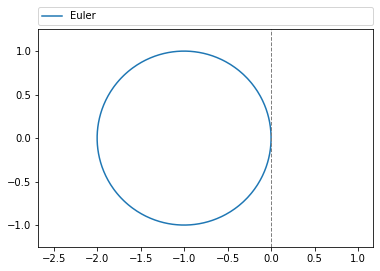

In [61]:
rk1.stability_domain(Ir=(-2,0.5),Ii=(-1.25,1.25),colors=default.palette[0])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

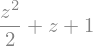

In [62]:
A = [[0,0],
     [1,0]]
b = [0,1]
c = [sp.Rational(1,2),sp.Rational(1,2)]

rk2 = rk_butcher(A=A,b=b,c=c,label="RK SSP (2,2)")
del A,b,c
rk2.stability_function()

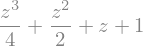

In [63]:
A = [[0,0,0],
     [sp.Rational(1,2),0,0],
     [0,sp.Rational(1,2),0]]
b = [0,sp.Rational(1,2),sp.Rational(1,2)]
c = [0,0,1]

rk32best = rk_butcher(A=A,b=b,c=c,label="RK (3,2) best")
del A,b,c
rk32best.stability_function()

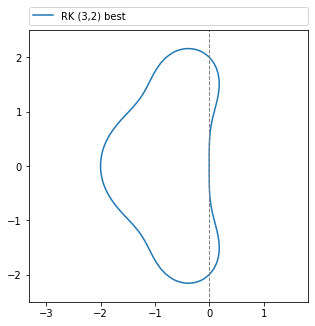

In [64]:
plt.rcParams['figure.figsize'] = [5,5]
rk32best.stability_domain(Ir=(-2,0.5),Ii=(-2.5,2.5),colors=default.palette[0])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

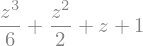

In [65]:
""" vérification sur RK3 """
A = [[0,0,0],
     [1,0,0],
     [sp.Rational(1,4),sp.Rational(1,4),0]]
b = [0,1,sp.Rational(1,2)]
c = [sp.Rational(1,6),sp.Rational(1,6),sp.Rational(2,3)]

rk33 = rk_butcher(A=A,b=b,c=c,label="RK (3,3)")
del A,b,c
rk33.stability_function()

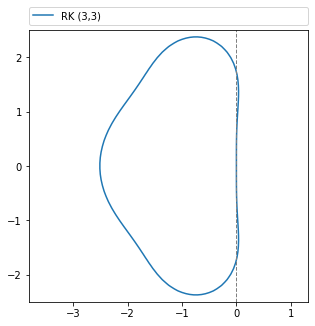

In [66]:
plt.rcParams['figure.figsize'] = [5,5]
rk33.stability_domain(Ir=(-3,0.5),Ii=(-2.5,2.5),colors=default.palette[0])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

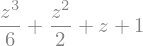

In [67]:
A = [[0,0,0],
     [sp.Rational(1,2),0,0],
     [-1,2,0]]
c = [sp.Rational(1,6),sp.Rational(4,6),sp.Rational(1,6)]
b = [0,sp.Rational(1,2),1]

rk33bis = rk_butcher(A=A,b=b,c=c,label="RK (3,3) bis")
del A,b,c
rk33bis.stability_function()

Les 2 méthodes Runge-Kutta d'ordre 3 à 3 étages ont la même fonction de stabilité, par conséquent les CFL obtenues seront les mêmes et toutes les autres propriétés issues de cette fonction aussi (order-star). En revanche le schéma reste différent et l'erreur aussi (mais la convergence de l'erreur est bien la même, seule la constante diffère).

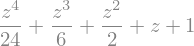

In [68]:
""" vérification sur RK4 """
A = [[ 0               , 0               , 0 , 0 ] ,
     [ sp.Rational(1,2), 0               , 0 , 0 ] ,
     [ 0               , sp.Rational(1,2), 0 , 0 ] ,
     [ 0               , 0               , 1 , 0 ]]
b = [0,sp.Rational(1,2),sp.Rational(1,2),1]
c = [sp.Rational(1,6),sp.Rational(1,3),sp.Rational(1,3),sp.Rational(1,6)]

rk44 = rk_butcher(A=A,b=b,c=c,label="RK (4,4)")
del A,b,c
rk44.stability_function()

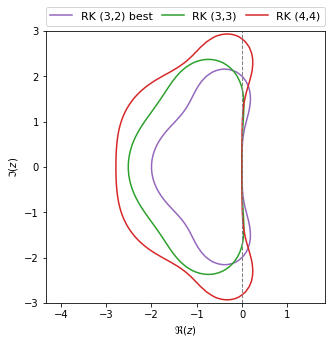

In [69]:
plt.rcParams['figure.figsize'] = [5,5]
rk32best.stability_domain(Ir=(-2,0.5),Ii=(-2.5,2.5),colors=default.palette[4])
rk33.stability_domain(Ir=(-3,0.5),Ii=(-2.5,2.5),colors=default.palette[2])
rk44.stability_domain(Ir=(-3,0.5),Ii=(-3.,3.),colors=default.palette[3])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,prop={'size': 11})
plt.xlabel(r"$\Re(z)$")
plt.ylabel(r"$\Im(z)$")

plt.show()
plt.rcParams['figure.figsize'] = default.figsize

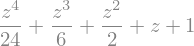

In [70]:
""" test sur RK4 3/8-rule """
A = [[ 0               , 0 , 0 , 0 ],
     [ sp.Rational(1,3), 0 , 0 , 0 ],
     [-sp.Rational(1,3), 1 , 0 , 0 ],
     [ 1               ,-1 , 1 , 0 ]]
b = [0,sp.Rational(1,3),sp.Rational(2,3),1]
c = [sp.Rational(1,8),sp.Rational(3,8),sp.Rational(3,8),sp.Rational(1,8)]

rk44_38 = rk_butcher(A=A,b=b,c=c,label="RK (4,4) 3/8 rule")
del A,b,c
rk44_38.stability_function()

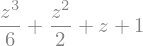

In [71]:
""" test sur RK NSSP(3,3) [Wang R. and Spiteri R. J. (2007)] """
A = [[0,0,0],
     [-sp.Rational(4,9),0,0],
     [sp.Rational(7,6),-sp.Rational(1,2),0]]
b = [0,-sp.Rational(4,9),sp.Rational(2,3)]
c = [sp.Rational(1,4),0,sp.Rational(3,4)]

rknssp33 = rk_butcher(A=A,b=b,c=c,label="RK NSSP (3,3)")
del A,b,c
rknssp33.stability_function()

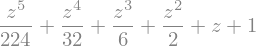

In [72]:
""" test sur RK NSSP(5,3) [Wang R. and Spiteri R. J. (2007)] """
A = [[ 0 , 0 , 0 , 0 , 0 ]                 ,
     [ sp.Rational(1,7)  , 0 , 0 , 0 , 0 ] ,
     [ 0 , sp.Rational(3,16) , 0 , 0 , 0 ] ,
     [ 0 , 0 , sp.Rational(1,3)  , 0 , 0 ] ,
     [ 0 , 0 , 0 , sp.Rational(2,3)  , 0 ]]
b = [0,sp.Rational(1,7),sp.Rational(3,16),sp.Rational(1,3),sp.Rational(2,3)]
c = [sp.Rational(1,4),0,0,0,sp.Rational(3,4)]

rk53 = rk_butcher(A=A,b=b,c=c,label="RK NSSP (5,3)")
del A,b,c
rk53.stability_function()

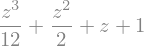

In [73]:
""" test sur RK SSP(3,2) [Wang R. and Spiteri R. J. (2007)] """
A = [[ 0                , 0                , 0 ],
     [ sp.Rational(1,2) , 0                , 0 ],
     [ sp.Rational(1,2) , sp.Rational(1,2) , 0 ]]
b =  [ 0 , sp.Rational(1,2) , 1 ]
c =  [ sp.Rational(1,3) , sp.Rational(1,3) , sp.Rational(1,3) ]

rk32 = rk_butcher(A=A,b=b,c=c,label="RK SSP (3,2)")
del A,b,c
rk32.stability_function()

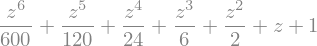

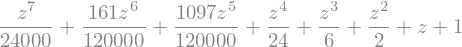

In [74]:
""" test sur DP 5 (Dormand-Prince) [Motamed M. and Macdonald C. and Ruuth S. (2010)] """
A = [[ 0                       , 0                       , 0                       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(1,5)        , 0                       , 0                       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(3,40)       , sp.Rational(9,40)       , 0                       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(44,45)      ,-sp.Rational(56,15)      , sp.Rational(32,9)       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(19372,6561) ,-sp.Rational(25360,2187) , sp.Rational(64448,6561) ,-sp.Rational(212,729) , 0                       , 0                  , 0 ],
     [ sp.Rational(9017,3168)  ,-sp.Rational(355,33)     , sp.Rational(46732,5247) , sp.Rational(49,176)  ,-sp.Rational(5103,18656) , 0                  , 0 ],
     [ sp.Rational(35,384)     , 0                       , sp.Rational(500,1113)   , sp.Rational(125,192) ,-sp.Rational(2187,6784)  , sp.Rational(11,84) , 0 ]]
c1 = [ sp.Rational(35,384)     , 0                       , sp.Rational(500,1113)   , sp.Rational(125,192) ,-sp.Rational(2187,6784)  , sp.Rational(11,84) , 0 ]
c2 = [ sp.Rational(5179,57600) , 0                       , sp.Rational(7571,16695) , sp.Rational(393,640) ,-sp.Rational(92097,339200) , sp.Rational(187,2100) , sp.Rational(1,40) ]
b = [0,sp.Rational(1,5),sp.Rational(3,10),sp.Rational(4,5),sp.Rational(8,9),1,1]

dp5 = rk_butcher(A=A,b=b,c=c1,label="DP5 RK(6,5)")
dp5_4 = rk_butcher(A=A,b=b,c=c2,label="DP5(4) RK(7,4)")
del A,b,c1,c2
display(dp5.stability_function())
display(dp5_4.stability_function())

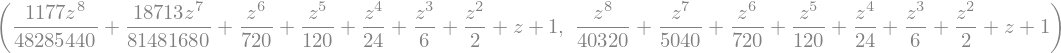

In [75]:
""" test sur RK (8,6) [Banks J. W. et all (2019)] """
A = [[  0 ,  0 , 0 , 0 , 0 , 0 , 0 , 0 ] ,
     [  sp.Rational(1,9)             ,  0                         ,  0                          ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(1,24)            ,  sp.Rational(1,8)          ,  0                          ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(1,6)             , -sp.Rational(1,2)          ,  sp.Rational(2,3)           ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(935,2536)        , -sp.Rational(2781,2536)    ,  sp.Rational(309,317)       ,  sp.Rational(321,1268)       ,  0                      , 0                     , 0                  , 0 ] ,
     [ -sp.Rational(12710,951)       ,  sp.Rational(8287,317)     , -sp.Rational(40,317)        , -sp.Rational(6335,317)       ,  8                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(5840285,3104064) , -sp.Rational(7019,2536)    , -sp.Rational(52213,86224)   ,  sp.Rational(1278709,517344) , -sp.Rational(433,2448)  , sp.Rational(33,1088)  , 0                  , 0 ] , 
     [ -sp.Rational(5101675,1767592) ,  sp.Rational(112077,25994) ,  sp.Rational(334875,441898) , -sp.Rational(973617,883796)  , -sp.Rational(1421,1394) , sp.Rational(333,5576) , sp.Rational(36,41) , 0 ]]

c =  [  sp.Rational(41,840)          ,  0                         ,  sp.Rational(9,35)          ,  sp.Rational(9,280)          ,  sp.Rational(34,105)    , sp.Rational(9,280)    , sp.Rational(9,35)  , sp.Rational(41,840) ]
b =  [ 0 , sp.Rational(1,9) , sp.Rational(1,6) , sp.Rational(1,3) , sp.Rational(1,2) , sp.Rational(2,3) , sp.Rational(5,6) , 1 ]

rk86 = rk_butcher(A=A,b=b,c=c,label="RK (8,6)")
del A,b,c
(rk86.stability_function(),poly_carac(8))

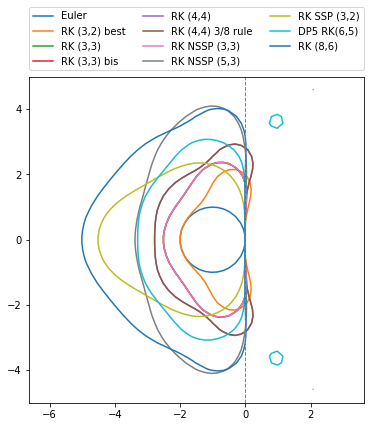

In [76]:
plt.rcParams['figure.figsize'] = [6,6]

for i,rk in enumerate((rk1,rk32best,rk33,rk33bis,rk44,rk44_38,rknssp33,rk53,rk32,dp5,rk86)):
  rk.stability_domain(Ir=(-6,3),Ii=(-5,5), colors=default.palette[i%len(default.palette)])

plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del i,rk

On peut souhaiter effectuer l'opération inverse, à partir d'une fonction de stabilité polynômiale (maximisant par exemple la stabilité sur l'axe imaginaire) retrouver le tableau de Butcher (et donc le schéma). Pour cela on calcule la fonction de stabilité d'une matrice $A=(a_{ij})_{ij}$ et un vecteur $c = (c_j)_j$, et on cherche à obtenir les relations d'ordre.

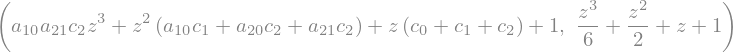

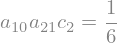

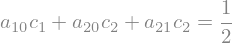

In [77]:
s=3
rk_coef = rk_butcher(A=np.array(sp.symbols('a_:%i:%i'%(s,s))).reshape((s,s)),
                  b=sp.symbols('b:%i'%s),
                  c=sp.symbols('c:%i'%s))

pb = sp.Poly(rk_coef.stability_function(),z)
pc = sp.Poly(poly_carac(s),z)

# égalités entre le polynôme caractéristique et les coefficients de Butcher
display((pb.as_expr(),pc.as_expr()))
[display(sp.Eq(cb,cc)) for (cb,cc) in zip( pb.coeffs() , pc.coeffs() )];
del s,rk_coef,pb,pc

Maintenant il faut savoir quoi faire de ces relations d'ordre. On peut par exemple contraindre la forme de la matrice $A$ (par exemple diagonale inférieure, comme dans RK NSSP(5,3)), la positivité de certains coefficients, d'autres relations pour assurer un caractère SSP ou non, etc.

> Il est normal que le résultat donné ici ne donne qu'une relation faisant intervenir $a_{10}$, $a_{20}$ et $a_{21}$ puisque pour le moment la fonction `poly_butcher` ne fonctionne qu'avec une méthode RK explicite. L'étude de DIRK2 par exemple nécessiterait une amélioration de la fonction.

On peut vouloir aussi écrire le schéma issu d'un tableau de Butcher. Par défaut le schéma obtenu directement à l'aide d'un tableau de Butcher n'est pas optimal d'un point de vue numérique dans le sens où il sous entend plus que $s$ (le nombre d'étages de la méthode) évaluations de la fonction $L$. Une amélioration du schéma est possible à l'aide d'un jeu de substituion des étapes précédentes.

In [78]:
tn = sp.symbols("t^n",real=True)

def butcher_scheme ( A , b , c , shu_osher=False ):
  us = name_stages("u",len(c))
  scheme_stages = []
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_si = us[0] + dt*sum([ A[i][j]*L(tn+b[j]*dt,us[j]) for j in r ])
    scheme_stages.append(sp.Eq(us[i],u_si))
  un1 = us[0] + dt*sum([ c[i]*L(tn+b[i]*dt,us[i]) for i in r ])
  scheme_stages.append(sp.Eq(us[-1],un1))
  
  scheme_stages = scheme_stages[1:]
  if shu_osher :
    L_subs = []
    for i,eq in enumerate(scheme_stages[:-1]):
      scheme_stages[i] = eq.subs(L_subs).simplify().expand()
      L_subs.append(( L(tn+b[i]*dt,us[i]) , sp.solve(scheme_stages[i],L(tn+b[i]*dt,us[i]))[0] ))
    scheme_stages[-1] = scheme_stages[-1].subs(L_subs).expand()
                    
  return scheme_stages

rk_butcher.scheme = lambda self,shu_osher=False:butcher_scheme(self.A,self.b,self.c,shu_osher)

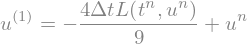

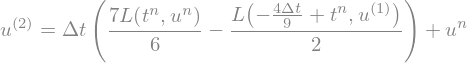

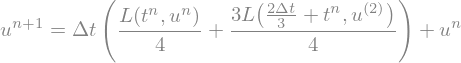

In [79]:
[ display(eq) for eq in rknssp33.scheme(shu_osher=False) ];

### 2.1.3 Récapitulatif des domaines des différentes méthodes en temps

On peut résumer tous les schémas en temps présentés par la figure ci-dessous.

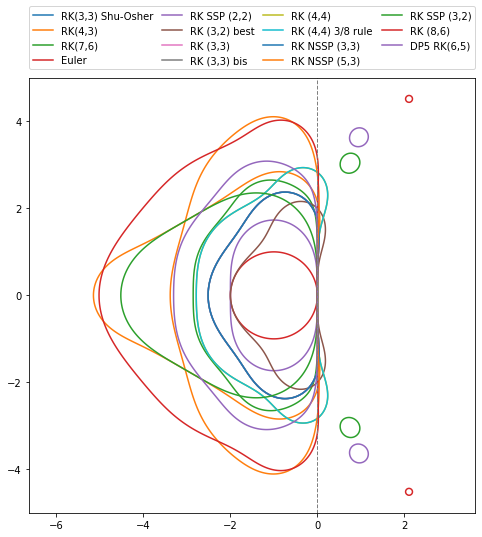

In [80]:
plt.rcParams['figure.figsize'] = [8,8]

for i,rk in enumerate((rk33so,rk43,rk76,rk1,rk2,rk32best,rk33,rk33bis,rk44,rk44_38,rknssp33,rk53,rk32,rk86,dp5)):
  rk.stability_domain(Ir=(-6,3,500),Ii=(-5,5,500),colors=default.palette[i%len(default.palette)])
  
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del i,rk

### 2.1.4 Recherche du meilleur domaine de stabilité

Nicolas est intéressé par effectuer une étude un peu inverse, c'est-à-dire trouver le meilleur coefficient $\alpha$ tel que le polynôme caractéristique :

$$
  \alpha z^4 + \frac{z^3}{6} + \frac{z^2}{2} + z + 1
$$

ait le plus grand domaine de stabilité (en particulier sur l'axe imaginaire, pour exprimer la stabilité d'un schéma non diffusif). C'est à dire ajouter un étage sur une méthode RK3 existante, telle que celle-ci obtienne une meilleure stabilité.

In [81]:
alpha = sp.symbols("\\alpha",real=True,positive=True)

def poly_RKn1n(n):
  """ return stability function of explicit RK(n+1,n) scheme with alpha coefficient for the last coeff """
  return alpha*z**(n+1) + poly_carac(n)

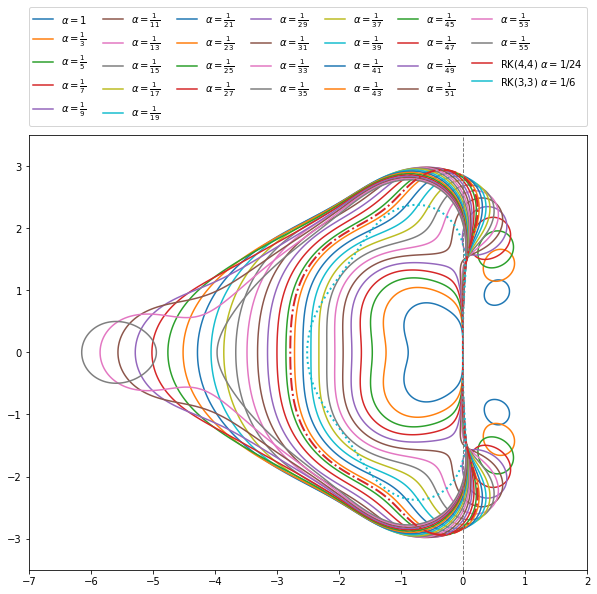

In [82]:
n = 3

plt.rcParams['figure.figsize'] = [10,8]
for k in range(1,57,2):
  print(k,end="\r")
  contour(sp.Abs(poly_RKn1n(n)).subs(alpha,sp.Rational(1,k)),z,(-7.,2.,500),(-3.5,3.5,500), levels=[1.],colors=default.palette[int((k-1)/2)%len(default.palette)],label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,k))))
print(" "*len(str(k)))
contour(sp.Abs(poly_carac(n+1)),z,(-7.,2.,500),(-3.5,3.5,500),linewidths=2,linestyles=['-.'],levels=[1.],colors=default.palette[3],label="RK({},{}) $\\alpha = {}$".format(n+1,n+1,sp.Rational(1,sp.factorial(n+1))))
contour(sp.Abs(poly_carac(n)),z,(-7.,2.,500),(-3.5,3.5,500),linewidths=2,linestyles=[':'],levels=[1.],colors=default.palette[9],label="RK({},{}) $\\alpha = {}$".format(n,n,sp.Rational(1,sp.factorial(n))))

plt.legend(loc=(0.,1.02),ncol=7,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del n,k

Ce qui nous intéresse ici est de maximiser le domaine de stabilité sur l'axe imaginaire. Il est très compliqué de chercher à maximiser le domaine de stabilité d'une méthode RK($s$,$n$) pour WENO. En plus de cela il est nécessaire de trouver par la suite une solution aux relations d'ordre dans la fonction de stabilité.

La maximisation du domaine sur l'axe imaginaire permet de stabiliser avec la plus grande CFL possible un transport pur. Le coefficient $\alpha$ maximisant le domaine sur l'axe imaginaire avec un RK2 à 3 étages est $\alpha = \frac{1}{4}$.

> **Preuve :** considérons le polynôme caractéristique $R_{\alpha}$ d'un schéma RK2 à 3 étages avec un coefficient $\alpha$ :
> 
> $$ R_{\alpha}(z) = 1 + z + \frac{z^2}{2} + \alpha z^3 $$
> 
> On cherche à évaluer le polynôme en $z=i\beta$, correspondant à l'intersection de l'ensemble $\{ z\ /\  |R_\alpha(z)|=1 \}$ avec l'axe imaginaire.
> 
> $$ R_\alpha(i\beta) = 1 + i\beta - \frac{\beta^2}{2} - i\beta^3\alpha $$
> 
> on souhaite un module égale à 1 :
> 
> $$ 1 = |R_\alpha(i\beta)|^2 = \left(1-\frac{\beta^2}{2}\right)^2 + \left(\beta - \beta^3\alpha \right)^2 $$
> 
> ce qui peut se simplifier par :
> 
> $$ \alpha^2\beta^6 + (\frac{1}{4}-2\alpha)\beta^4 = 0 $$
>
>En supposant $\beta \neq 0$ :
>
>$$ \alpha^2\beta^2 -2\alpha + \frac{1}{4} = 0 $$
>
>soit :
>
>$$ \beta^2 = \frac{2\alpha - \frac{1}{4}}{\alpha^2} $$
>
>on obtient ainsi une fonction $\beta^2:\alpha\mapsto \frac{2\alpha - \frac{1}{4}}{\alpha^2}$ dont on souhaite trouver le maximum (ou plus exactement le coefficient $\alpha$ où est atteint le maximum, ce qui explique que l'on ne s'intéresse qu'au coefficient $\beta^2$ et non explicitement $\beta$).
>
>$$ \left(\beta^2\right)'(\alpha) = \frac{-2\alpha^2 + \frac{\alpha}{2}}{\alpha^4} $$
>
>la dérivée s'annule en $\alpha = \frac{1}{4}$ □


La maximisation du domaine sur l'axe imaginaire ne permet pas rigoureusement de maximiser la CFL du couple de schéma RK$^\alpha N$-WENO mais permet de se donner une idée ; prenons par exemple le cas de RK2 à 3 étages, comme dit précédemment le coefficient $\alpha$ maximisant le domaine de stabilité sur l'axe imaginaire est $\alpha = \frac{1}{4}$, représenté par le courbe orange sur la figure, or il est possible d'obtenir une CFL plus importante avec le coefficient $\alpha=\frac{1}{5}$, pour lequel on représente le coefficient d'amplification en rose de WENO$\times$1.4 (sans aller chercher $\alpha=\frac{1}{6}$ qui correspond à RK3).

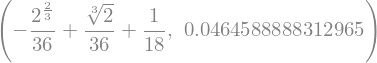

In [83]:
"""
  automatic compute for the best alpha coeficient to maximize stability domain on imaginary axis
"""
n=3 # avec n=2 on retrouve bien 1/4
beta = sp.symbols("\\beta",real=True,positive=True)
p = poly_RKn1n(n)

alphas = []
# on cherche à résoudre $|p(ib)|^2 -1 = 0$, solutions auxquels on soustrait le singleton {0}
# puis on dérive les solutions (qui dépendent de alpha) pour savoir où la dérivée s'annule et donc où beta
# est maximisé
for a in sp.solveset((sp.Abs(p.subs(z,beta*I))**2-1).collect(beta),beta**2)-sp.FiniteSet(0):
  betaset = sp.solveset(a.diff(alpha),alpha,domain=sp.S.Reals)
  if betaset != sp.EmptySet :
    alphas.extend(betaset)
display((alphas[0],alphas[0].evalf()))

del beta,p,a,betaset

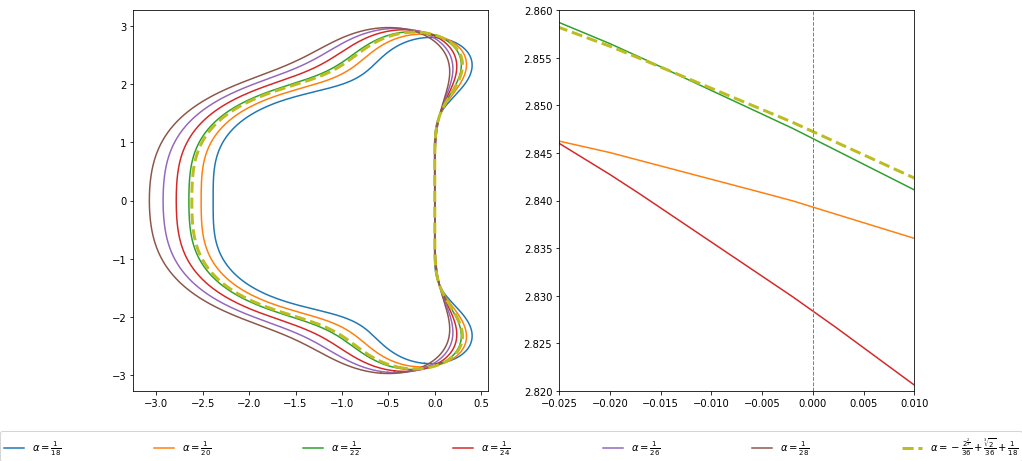

In [84]:
""" visualisation of this result """

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7))
p = poly_RKn1n(n)

for i,k in enumerate(range(int(1./alphas[0].evalf())-3,int(1./alphas[0].evalf())+9,2)):
  print(k,end="\r")
  tmp_fig = plt.figure()
  tmp = contour(sp.Abs(poly_RKn1n(n)).subs(alpha,sp.Rational(1,k)),z,(-7.,2.,500),(-3.5,3.5,500), levels=[1.]).allsegs[0]
  m_data = max(tmp,key=lambda dat:len(dat))
  plt.close(tmp_fig); del tmp_fig,tmp
  ax1.plot(m_data[:,0],m_data[:,1],color=default.palette[i%len(default.palette)],label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,k))))
  ax2.plot(m_data[:,0],m_data[:,1],color=default.palette[i%len(default.palette)])
  
print(alphas[0],end="\r")
tmp_fig = plt.figure()
tmp = contour(sp.Abs(poly_RKn1n(n)).subs(alpha,alphas[0]),z,(-7.,2.,500),(-3.5,3.5,500), levels=[1.],colors=default.palette[int((k-1)/2)%len(default.palette)],label="$\\alpha = {}$".format(alphas[0])).allsegs[0]
m_data = max(tmp,key=lambda dat:len(dat))
plt.close(tmp_fig); del tmp_fig,tmp
ax1.plot(m_data[:,0],m_data[:,1],'--',color=default.palette[(i+3)%len(default.palette)],linewidth=3,label="$\\alpha = {}$".format(sp.latex(alphas[0])))
ax2.plot(m_data[:,0],m_data[:,1],'--',color=default.palette[(i+3)%len(default.palette)],linewidth=3)
ax2.axvline(0, color='gray',linestyle='--',linewidth=1.)
print(" "*len(str(alphas[0])))

fig.legend(loc=(0.,0.),ncol=7,mode="expand",borderaxespad=0.,markerscale=10)
ax2.set_xlim([-0.025,0.01]) ; ax2.set_ylim([2.82,2.86])
plt.show()

del fig,ax1,ax2,p,i,k,m_data

### 2.1.5 Order star

Il est possible assez facilement, pour étudier certaines propriétés de nos schémas en temps, de tracer l'*order star* (n'ayant vu aucun article francophone en parler j'utlise le terme en anglais). L'*order star* est définie comme : $\{\mathcal{A}_+,\mathcal{A}_0,\mathcal{A}_-\}$ avec :

* $\mathcal{A}_+ = \left\{ z\in\mathbb{C}\,:\, |e^{-z}R(z)|>1 \right\}$
* $\mathcal{A}_0 = \left\{ z\in\mathbb{C}\,:\, |e^{-z}R(z)|=1 \right\}$
* $\mathcal{A}_- = \left\{ z\in\mathbb{C}\,:\, |e^{-z}R(z)|<1 \right\}$

où $R$ est le polynôme caractéristique, ou approximation de Padé de la fonction à étudier.

> Pour des raisons techniques, il est plus simple de colorier l'ensemble des points du plan dont la valeur d'une fonction est comprise entre 2 bornes finies, par conséquent, en bleu, nous alons afficher $ \mathcal{A}_-$.

In [85]:
def contourf ( expr , z , Ir , Ii , **kwargs):
  x,y = sp.symbols("x y",real=True)
  f = sp.lambdify((x, y), expr.subs(z,x+I*y),'numpy')
  
  a = np.linspace(*Ir)
  b = np.linspace(*Ii)
  X, Y = np.meshgrid(a, b)
  try:
    lab = kwargs.pop("label")
  except:
    lab = ""
  try:
    c = kwargs["colors"]
  except:
    c = palette[0]
  if len(lab) > 0 :
    plt.plot([0],[0],'s',markersize=1,label=lab,color=c)
  return plt.contourf(X,Y, f(X,Y).real,**kwargs)

Substituting symbol A from STIXNonUnicode
Substituting symbol A from STIXNonUnicode


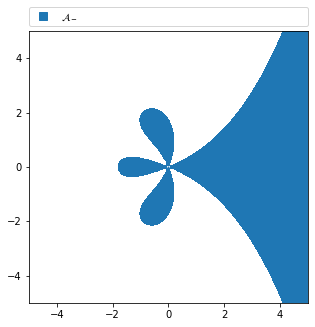

In [86]:
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(sp.exp(-z)*rk33.stability_function()),z,(-5,5,100),(-5,5,100),levels=[0.,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

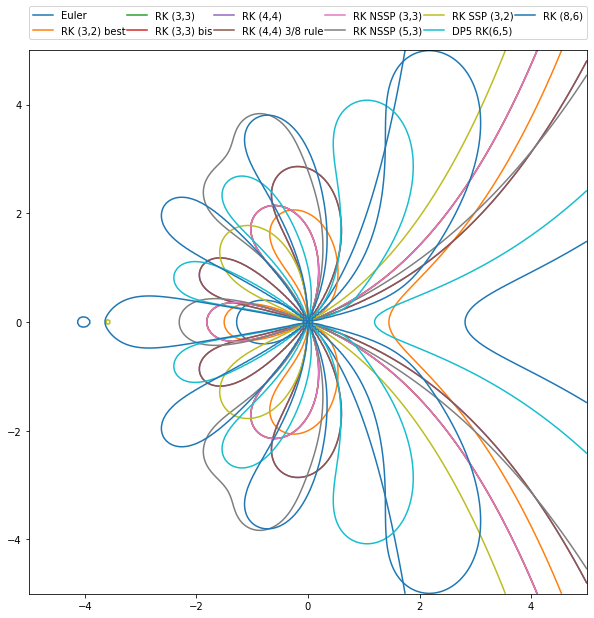

In [87]:
plt.rcParams['figure.figsize'] = [10,10]

for i,rk in enumerate((rk1,rk32best,rk33,rk33bis,rk44,rk44_38,rknssp33,rk53,rk32,dp5,rk86)):
  contour(sp.Abs(sp.exp(-z)*rk.stability_function()),z,(-5,5,200),(-5,5,200),levels=[1.],colors=default.palette[i%len(default.palette)],label=rk.label )

plt.legend(loc=(0.,1.02),ncol=6,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

## 2.2 Méthode diagonal implicit Runge-Kutta

Nous n'avons étudier jusqu'à présent que des schémas de type Runge-Kutta explicite (ou eRK), et cela se traduit par un tableau de Butcher triangulaire strictement inférieur. Le cas général d'un tableau de Butcher plein est envisageable, le schéma est alors implicite, ce qui permet souvent d'améliorer sa stabilité au détriment du coût de calcul (à cause de l'inversion d'un système). Le compromis de DIRK est de ne rendre que la diagonale implicite. Nous allons étudier ici ce genre de schéma.

In [88]:
def poly_dirk( A , c , b=0 ):
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_si = un + dt*sum([ A[i][j]*lamb*sp.symbols("u^{}".format(j)) for j in r ])
    for j in range(i) :
      u_si = u_si.subs(sp.symbols("u^{}".format(j)),u_s[j])
    ui = sp.symbols("u^{}".format(i))
    eq = sp.Eq(ui,u_si)
    u_s[i] = sp.solve(eq,ui)[0]
  un1 = un + dt*sum([ c[j]*lamb*u_s[j] for j in r ])
  return un1.subs(sp.symbols("u^0"),u_s[0]).expand().subs(lamb*dt,z).subs(un,1)

def to_gnuplot ( R , z , dic=None ):
  x,y = sp.symbols("x y",real=True)
  r = R.subs(z,x+I*y)
  if dic :
    r = r.subs(dic)
  return str(r)

Commençons par le premier schéma DIRK présenté dans [[Alexander R. (1976)]](https://doi.org/10.1137/0714068), dont voici le tableau de Butcher :

$$
  \begin{array}{c c | c}
    \frac{1}{2}+\frac{1}{2\sqrt{3}} & 0                               & \frac{1}{2} + \frac{1}{2\sqrt{3}} \\
    -\frac{1}{\sqrt{3}}             & \frac{1}{2}+\frac{1}{2\sqrt{3}} & \frac{1}{2} - \frac{1}{2\sqrt{3}} \\
    \hline
    \frac{1}{2}                     & \frac{1}{2} &
  \end{array}
$$

est une méthode DIRK(2,3). Le polynôme caractéristique des méthodes DIRK est une fonction rationnelle.

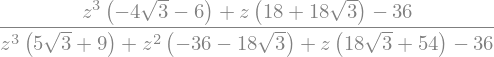

((-4*sqrt(3) - 6)*(x + I*y)**3 + (18 + 18*sqrt(3))*(x + I*y) - 36)/((5*sqrt(3) + 9)*(x + I*y)**3 + (-36 - 18*sqrt(3))*(x + I*y)**2 + (18*sqrt(3) + 54)*(x + I*y) - 36)


In [89]:
A = [[sp.Rational(1,2)+1/(2*sp.sqrt(3)),0                                ],
     [-1/sp.sqrt(3)                    ,sp.Rational(1,2)+1/(2*sp.sqrt(3))]]
c = [ sp.Rational(1,2)                 ,sp.Rational(1,2)                  ]
dirk23 = poly_dirk(A=A,c=c).simplify().collect(z)
display(dirk23)
print(to_gnuplot(dirk23,z))
del A,c

In [90]:
%matplotlib widget

In [91]:
# run `%matplotlib widget` before to get an interactive visualization (but not in vs-code) and `%matplotlib inline` after
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.rcParams['figure.figsize'] = [10,10]
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-10,10,0.01)
Y = np.arange(-10,10,0.01)
X, Y = np.meshgrid(X, Y)
R = sp.lambdify(z,dirk23,'numpy')
Z = np.abs(R(X+1j*Y))
Z = np.where(Z>1,1.1,Z)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none',linewidth=0,antialiased=True)

# Customize the z axis.
ax.set_zlim(0,1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf,shrink=0.5,aspect=5)

plt.show()
plt.rcParams['figure.figsize'] = default.figsize

del X,Y,Z,R,surf,ax,fig

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
%matplotlib inline

Par la suite, on ne présentera que les domaines de stabilité.

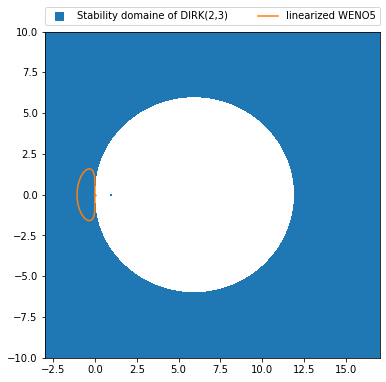

In [93]:
plt.rcParams['figure.figsize'] = [6,6]
contourf(sp.Abs(dirk23),z,(-3,17,500),(-10,10,500),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(2,3)")
plt.plot(*reim(-weno5l.ztilde.data),color=default.palette[1],label=weno5l.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Il est intéressant de remarquer que :
1. On trace l'opposé du coefficient d'amplification que nous avions précédemment car avec une méthode RK on résout $u_x = -u_x$, or on traçait le coefficient de $+u_x$.
2. Il est important, surtout pour des méthodes implicites, de ne pas tracer que la bordure du domaine de stabilité car (on le verra par la suite) il est difficile de prédire de quel côté de la bordure est le domaine.

Substituting symbol A from STIXNonUnicode
Substituting symbol A from STIXNonUnicode


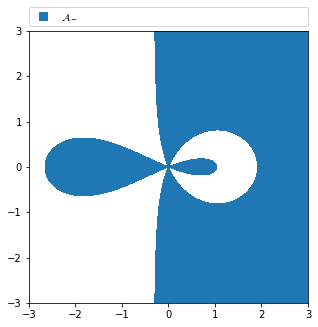

In [94]:
""" order star of DIRK(2,3) """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(sp.exp(-z)*dirk23),z,(-3,3,500),(-3,3,500),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Posons $\alpha = \frac{2\cos\left(\frac{\pi}{18}\right)}{\sqrt{3}}$ :
$$
  \begin{array}{c c c | c}
  \frac{1+\alpha}{2}  & 0                     & 0                   & \frac{1+\alpha}{2} \\
  -\frac{\alpha}{2}   & \frac{1+\alpha}{2}    & 0                   & \frac{1}{2}        \\
  1+\alpha            & -(1+2\alpha)          & \frac{1+\alpha}{2}  & \frac{1-\alpha}{2} \\
  \hline
  \frac{1}{6\alpha^2} & 1-\frac{1}{3\alpha^2} & \frac{1}{6\alpha^2} &
  \end{array}
$$
est une méthode DIRK(3,4).

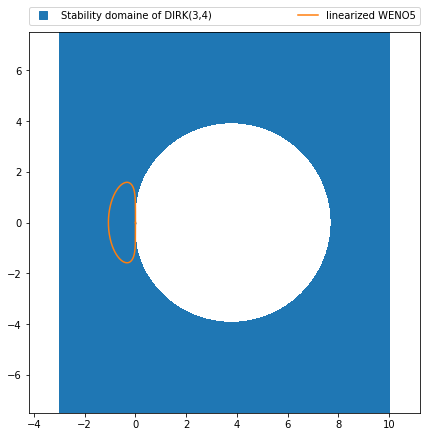

In [95]:
n_alpha = 2*sp.cos(sp.pi/18)/sp.sqrt(3)
A = [[(1+n_alpha)/2   ,0               ,0            ],
     [-n_alpha/2      ,(1+n_alpha)/2     ,0            ],
     [1+n_alpha       ,-(1+2*n_alpha)    ,(1+n_alpha)/2  ]]
c = [ 1/(6*n_alpha**2),1-1/(3*n_alpha**2),1/(6*n_alpha**2)]
dirk34 = poly_dirk(A=A,c=c)

dirk34 = dirk34.subs(n_alpha,n_alpha.evalf()).collect(z)
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(dirk34),z,(-3,10,100),(-7.5,7.5,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(3,4)")
plt.plot(*reim(-weno5l.ztilde.data),color=default.palette[1],label=weno5l.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del n_alpha,A,c

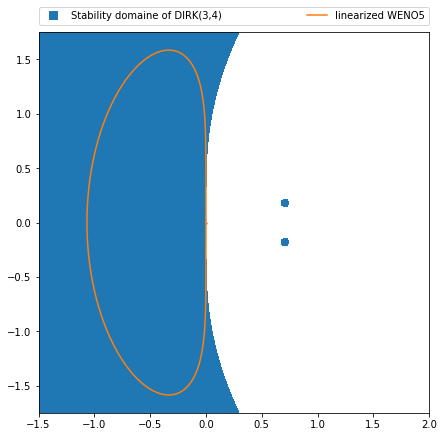

In [96]:
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(dirk34),z,(-1.5,2.,100),(-1.75,1.75,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(3,4)")
plt.plot(*reim(-weno5l.ztilde.data),color=default.palette[1],label=weno5l.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Substituting symbol A from STIXNonUnicode
Substituting symbol A from STIXNonUnicode


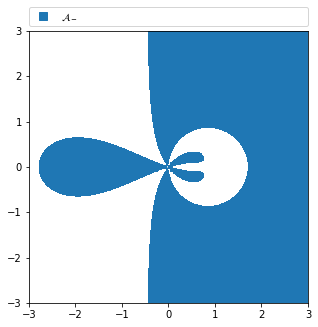

In [97]:
""" order star """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(sp.exp(-z)*dirk34),z,(-3,3,100),(-3,3,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Maintenant deux méthodes *strong S-stable* d'ordre 2 à 2 étages.
$$
  \begin{array}{c c  | c }
    \alpha   & 0      & \alpha \\
    1-\alpha & \alpha & 1 \\
    \hline
    1-\alpha & \alpha &
  \end{array}
$$
avec $\alpha = 1\pm\frac{1}{2}\sqrt{2}$. Les propritétés de stabilités de la méthode changent significativement en fonction de la valeur du coefficient $\alpha$.

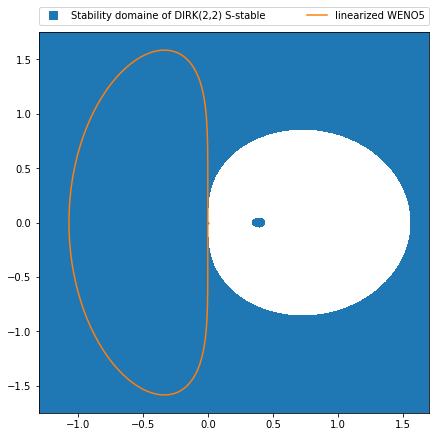

In [98]:
n_alpha = 1+sp.Rational(1,2)*sp.sqrt(2)
A = [[n_alpha  ,0    ],
     [1-n_alpha,n_alpha]]
c = [ 1-n_alpha,n_alpha ]
dirk22ss = poly_dirk(A=A,c=c).collect(z)

plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(dirk22ss),z,(-1.3,1.7,100),(-1.75,1.75,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(2,2) S-stable")
plt.plot(*reim(-weno5l.ztilde.data),color=default.palette[1],label=weno5l.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del n_alpha,A,c

Substituting symbol A from STIXNonUnicode
Substituting symbol A from STIXNonUnicode


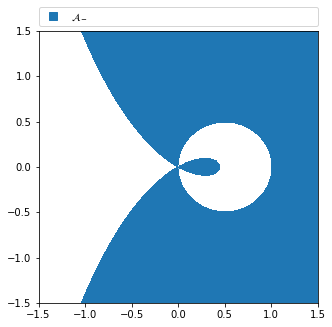

In [99]:
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(dirk22ss*sp.exp(-z)),z,(-1.5,1.5,100),(-1.5,1.5,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

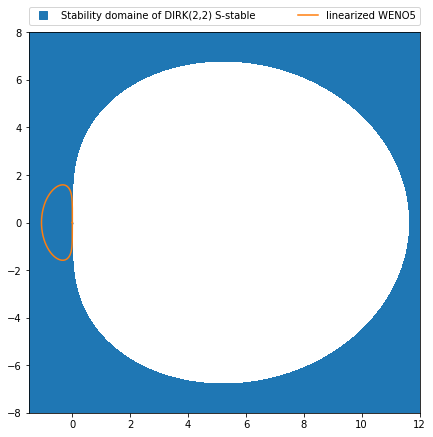

In [100]:
n_alpha = 1-sp.Rational(1,2)*sp.sqrt(2)
A = [[n_alpha  ,0    ],
     [1-n_alpha,n_alpha]]
c = [ 1-n_alpha,n_alpha ]
dirk22ss_m = poly_dirk(A=A,c=c).collect(z)

plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(dirk22ss_m),z,(-1.5,12.,100),(-8,8,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(2,2) S-stable")
plt.plot(*reim(-weno5l.ztilde.data),color=default.palette[1],label=weno5l.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del n_alpha,A,c

Substituting symbol A from STIXNonUnicode
Substituting symbol A from STIXNonUnicode


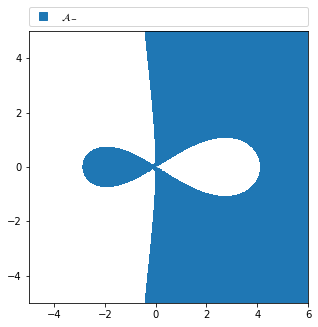

In [101]:
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(dirk22ss_m*sp.exp(-z)),z,(-5,6.,100),(-5,5,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Maintenant une méthode *strong S-stable* d'ordre 3 à 3 étages :

$$
  \begin{array}{c c c | c}
    \alpha        & 0      & 0      & \alpha \\
    \tau_2-\alpha & \alpha & 0      & \tau_2 \\
    b_1           & b_2    & \alpha & 1      \\
    \hline
    b_1           & b_2    & \alpha &
  \end{array}
$$

avec $\alpha$ la racine de $x^3-3x+\frac{3}{2}x-\frac{1}{6}=0$ vivant dans $[\frac{1}{6},\frac{1}{2}]$, $\alpha \approx 0.43586652$

* $\tau = \frac{1+\alpha}{2}$
* $b_1 = -\frac{6\alpha^2-16\alpha+1}{4}$
* $b_2 = \frac{6\alpha^2-20\alpha+5}{4}$

In [102]:
p = x**3 - 3*x**2 + sp.Rational(3,2)*x - sp.Rational(1,6)
subset = sp.solve(sp.Poly(x**3-3*x**2+sp.Rational(3,2)*x-sp.Rational(1,6)),x)
n_alpha = sp.re(subset[0].evalf())
tau2 = (1+n_alpha)/2
b1 = -(6*n_alpha**2-16*n_alpha+1)/4
b2 = (6*n_alpha**2-20*n_alpha+5)/4

A = [[n_alpha     ,0      ,0      ],
     [tau2-n_alpha,n_alpha,0      ],
     [b1          ,b2     ,n_alpha]]
c = [ b1          ,b2     ,n_alpha ]
dirk33ss = poly_dirk(A=A,c=c)

del p,subset,n_alpha,tau2,b1,b2,A,c

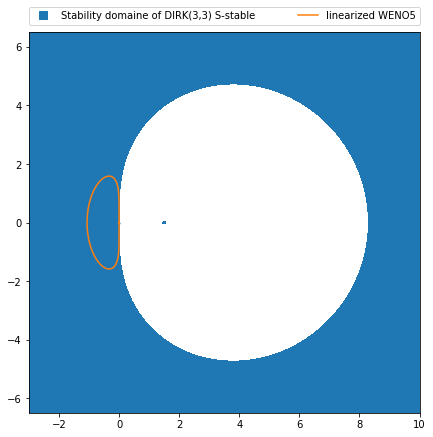

In [103]:
""" stability domain """
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(dirk33ss),z,(-3,10,400),(-6.5,6.5,400),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(3,3) S-stable")
plt.plot(*reim(-weno5l.ztilde.data),color=default.palette[1],label=weno5l.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Substituting symbol A from STIXNonUnicode
Substituting symbol A from STIXNonUnicode


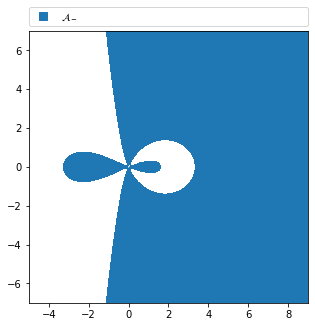

In [104]:
""" order star """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(dirk33ss*sp.exp(-z)),z,(-5,9,100),(-7,7,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Un autre test issu de [numipedia](http://ketch.github.io/numipedia/methods/SSPIRK33.html), où Ketcheson présente la méthode SSPIRK(3,3). Il est à noté que je ne me suis jamais intéressé au caractère SSP d'un schéma, donc je n'ai pas lu ou vérifié cet aspect sur les précédentes méthodes DIRK présentées.

Le tableau de Butcher de la méthode SSPIRK(3,3) est :

$$
  \begin{array}{c c c | c}
    -\frac{\sqrt{2}}{4}+\frac{1}{2} & 0                               & 0                               & -\frac{\sqrt{2}}{4}+\frac{1}{2} \\
    \frac{\sqrt{2}}{4}              & -\frac{\sqrt{2}}{4}+\frac{1}{2} & 0                               & \frac{1}{2} \\
    \frac{\sqrt{2}}{4}              & \frac{\sqrt{2}}{4}             & -\frac{\sqrt{2}}{4}+\frac{1}{2} & \frac{\sqrt{2}}{4}+\frac{1}{2} \\
    \hline
    \frac{1}{3} & \frac{1}{3} & \frac{1}{3}  &
  \end{array}
$$

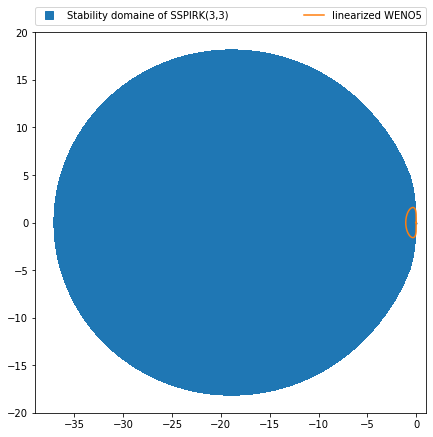

Substituting symbol A from STIXNonUnicode
Substituting symbol A from STIXNonUnicode


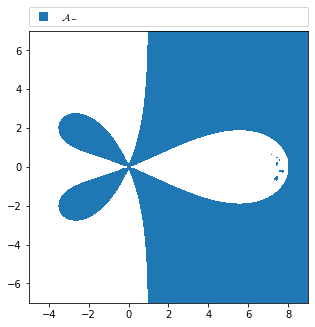

In [105]:
""" test sur SSPIRK33 (http://ketch.github.io/numipedia/methods/SSPIRK33.html) """
A = [[-sp.sqrt(2)/4+sp.Rational(1,2) , 0                             , 0                             ],
     [ sp.sqrt(2)/4                  ,-sp.sqrt(2)/4+sp.Rational(1,2) , 0                             ],
     [ sp.sqrt(2)/4                  , sp.sqrt(2)/4                  ,-sp.sqrt(2)/4+sp.Rational(1,2) ]]
b = [-sp.sqrt(2)/4+sp.Rational(1,2),sp.Rational(1,2),sp.sqrt(2)/4+sp.Rational(1,2)]
c = [sp.Rational(1,3),sp.Rational(1,3),sp.Rational(1,3)]
sspirk33 = poly_dirk(A=A,c=c)
del A,b,c

""" stability domain """
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(sspirk33),z,(-39,1,50),(-20,20,50),levels=[0,1.],colors=default.palette[0],label="Stability domaine of SSPIRK(3,3)")
plt.plot(*reim(-weno5l.ztilde.data),color=default.palette[1],label=weno5l.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()

""" order star """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(sspirk33*sp.exp(-z)),z,(-5,9,100),(-7,7,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

L'objectif ici est de travailler avec un couple d'une méthode Runge-Kutta en temps et une méthode WENO en espace. Les méthodes implicites (ici uniquement sur la diagonale) nécessitent d'inverser la méthode WENO, ceci a fait l'objet d'une publication : [[S. Gottlieb, J. Mullen et S. Ruuth]](http://doi.org/10.1007/s10915-005-9034-z)), il s'agit d'un problème compliqué et ces résultats ne semblent pas suffisamment convainquant pour poursuivre l'étude.

# 3. Étude de couples RK($s$,$n$)-WENO5

On regarde maintenant la stabilité de WENO avec les différents schémas RK($s$,$n$). Pour cela on trace le domaine de stabilité du schéma RK choisi, et on compare ce domaine avec celui du coefficient d'amplification du schéma WENO5. Le schéma est linéairement stable s'il existe un coefficient $\sigma$, appelé CFL, permettant de faire *rentrer* la courbe du schéma WENO dans le domaine de stabilité de RK($s$,$n$).

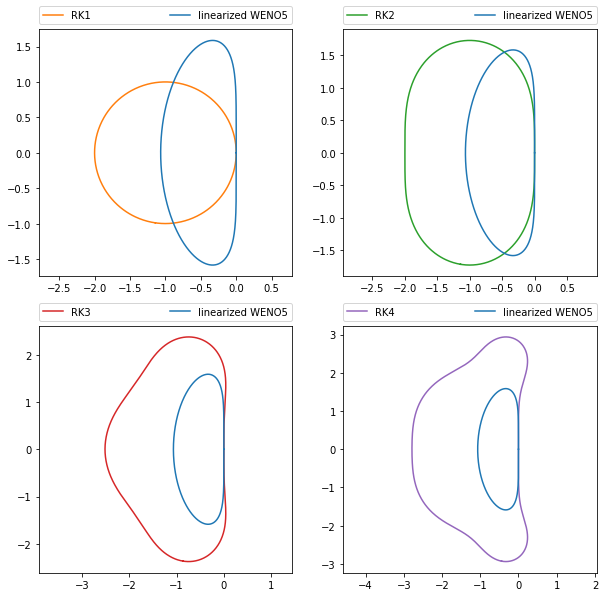

In [106]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
coords = [(x,y) for x in range(2) for y in range(2)]

for i in range(1,5):
  tmp_fig = plt.figure()
  tmp = contour(sp.Abs(poly_carac(i)),z,(-5.,2.,500),(-3.5,3.5,500), levels=[1.]).allsegs[0]
  m_data = max(tmp,key=lambda dat:len(dat))
  plt.close(tmp_fig); del tmp_fig,tmp
  ax[coords[i-1]].plot(m_data[:,0],m_data[:,1],label="RK%i"%i,color=default.palette[i])
  ax[coords[i-1]].plot(*reim(-weno5l.ztilde.data),label=weno5l.name,color=default.palette[0])
  ax[coords[i-1]].axis('equal')
  ax[coords[i-1]].legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.show()

del fig,ax,m_data

## 3.1 Automatisation du calcul de CFL

Il est maintenant intéressant d'étudier quel est le rapport d'homothétie liant le mieux RK($s$,$n$) à WENO, ce rapport d'homothétie est $\sigma$ le nombre de CFL. Dans l'article [[Wang R. and Spiteri R. J. (2007)]](https://doi.org/10.1137/050637868) une approximation grossière est faite en supposant que RK($s$,$n$), pour $n\geq 3$ contient un rectangle contenant la courbe de WENO linéarisé. Une estimation est ainsi faite d'un $\sigma_0 \leq \sigma$. Il est possible dans un premier temps d'estimer numériquement un coefficient $\sigma_{\texttt{num}}$ tel que :

$$
  \sigma_0 \leq \sigma_{\texttt{num}} \leq \sigma
$$

travail effectué dans [[Motamed M. and Macdonald C. B. (2010)]](https://doi.org/10.1007/s10915-010-9423-9). Il est aussi possible de travailler sur la version complète du schéma WENO, en prenant en compte dans l'analyse de von Neumann de la partie non linéaire.

Pour estimer une CFL entre un couple RK($s$,$n$)-WENO(lin) :

1. On discrétise la frontière du domaine de stabilité de la méthode RK($s$,$n$), chose déjà effectuée par Python, on obtient ainsi un tableau de $\{r(\theta_k)\}_k$.
2. On discrétise le coefficient d'amplification en fonction de $\phi$ en discrétisant l'intervalle $[0,2\pi[$, on obtient ainsi un tableau des coefficients d'amplification $\{w(\phi_i)\}_i$. Il est à noter qu'il n'y a pas de raison que la discrétisation $\theta_k$ coïncide avec les $\phi_i$.
3. On trie ces 2 tableaux de données par ordre d'argument, cela sera plus simple pour les parcourir de manière similaire.
4. Pour un couple $(\varphi_i,w(\phi_i)$ donné issu de la discrétisation, on recherche l'élément $\rho(\phi)$ défini comme : $$\rho(\phi_i) = \arg\!\min_{r(\theta_k)}\left(arg(r(\theta_k)-w(\phi_i)\right)$$
5. On calcule le facteur d'homothétie locale : $$\sigma_i = \left| \frac{\rho(\phi_i)}{w(\phi_i)}\right|$$
6. On définit la CFL comme : $$\sigma = \min_i \sigma_i$$

L'étape 4 de l'alorithme peut se représenter comme suit, ici avec la méthode RK(4,4).

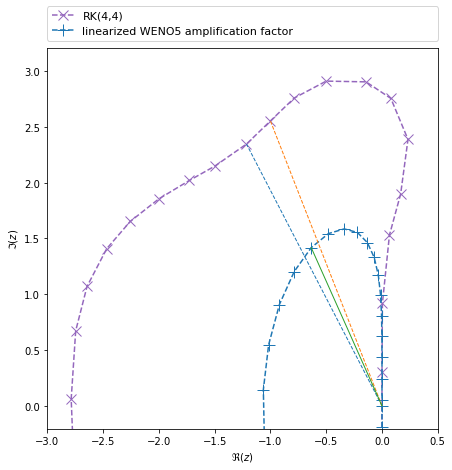

In [107]:
rk = rk44
fig = plt.figure()
reduce_data = rk.stability_domain(Ir=(-3,0.5),Ii=(-3.,3.),colors=default.palette[3]).allsegs[0][0]
plt.close(fig)
del fig

plt.rcParams['figure.figsize'] = [7,7]
plt.plot(*zip(*reduce_data[0::5]),"x--",color=default.palette[4],label="RK(4,4)",markersize=10.)
plt.plot(*reim(-weno5l.ztilde.data[0::30]),"+--",color=default.palette[0],label=weno5l.name+" amplification factor",markersize=12.)

plt.plot([0,reduce_data[95][0]],[0,reduce_data[95][1]],"--",linewidth=1.)
plt.plot([0,reduce_data[100][0]],[0,reduce_data[100][1]],"--",linewidth=1.)
plt.plot([0,-np.real(weno5l.ztilde.data[0::30][21])],[0,np.imag(-weno5l.ztilde.data[0::30][21])],linewidth=1.)

plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=1,mode="expand",borderaxespad=0.,prop={'size': 11})
plt.xlabel(r"$\Re(z)$")
plt.ylabel(r"$\Im(z)$")

plt.xlim([-3,0.5])
plt.ylim([-0.001,3])
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Pour chaque point $w(\phi_i)$ du coefficient d'amplification de WENO linéarisé, on souhaite trouver l'élément sur la bordure du domaine de stabilité de la méthode Runge-Kutta avec l'argument le plus proche de $\arg(w(\phi_i))$. Ici par exemple on trouve deux éléments $r(\theta_k)$ et $r(\theta_{k+1})$ avec un argument semblable, on choisit celui avec l'argument le plus proche.

Si on souhaite avec un résultat plus précis, il est nécessaire d'effectuer une interpolation entre les 2 éléments de la bordure du domaine de stabilité de RK(4,4) que l'on trouve. On se limite ici à une interpolation constante par morceau, la précision ne sera approtée que par le rafinement du maillage angulaire.

In [108]:
def cfl( z_rk , z_weno , display=True , data_rk=None , rk_name=None , weno_name=None ):
  sigs = np.array([ np.array([np.angle(z),np.abs((b_)/(z))]) for (z,b_) in zip(z_weno,z_rk) if np.abs(z)>1e-1 and np.abs((b_)/(z)) > 0.1 ])
  l = len(sigs)
  cfl = min(sigs[int(0.1*l):-int(0.1*l),1])
  #cfl = min(sigs[:,1])
  if cfl < 0.2:
    cfl = 0.
  if display :
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(sigs[int(0.1*l):-int(0.1*l),0],sigs[int(0.1*l):-int(0.1*l),1])
    ax[0].set_xlabel("$\\varphi$");ax[0].set_ylabel("$\\sigma_\\varphi$")
    if rk_name == None:
      rk_name = "time method"
    if weno_name == None:
      weno_name = "space method"
    if data_rk != None :
      ax[1].plot(*reim(data_rk),label=rk_name)
    else :
      ax[1].plot(*reim(z_rk),",",label=rk_name)
    ax[1].plot(*reim(-z_weno),label=weno_name)
    ax[1].plot(*reim(-z_weno*cfl),"--",label=weno_name+" $\\times\\,\\sigma = {0:.3f}$".format(cfl))
    ax[1].axis('equal')
    plt.legend(loc=(0.,1.02),ncol=2,mode="expand",borderaxespad=0.)
    plt.show()
  return cfl

def cfl_expr ( expr , z , z_weno , Ir , Ii , display=True , rk_name=None,weno_name=None ) :
  tmp_fig = plt.figure()
  dat0 = contour(expr,z,Ir,Ii, levels=[1.]).allsegs[0] # get stability domain
  plt.close(tmp_fig); del tmp_fig
  m_data = max(dat0,key=lambda l:len(l)) # get main domain
  data_c = [ re+im*1j for (re,im) in zip(m_data[:,0],m_data[:,1]) ] # convert into complex
  del dat0,m_data
  
  # sort rk data in the same way than weno
  z_rk = np.array([ min(data_c,key=lambda zb:np.abs(np.angle(zb)-np.angle(-zw)) ) for zw in z_weno ])
  return cfl(z_rk,z_weno,display,data_c,rk_name,weno_name)

### 3.1.1 CFL RK($s$,$n$) - WENO linéarisé

On commence par expérimenter notre méthode algorithmique sur le cas WENO linéarisé et retrouver les CFL proposées dans [[Motamed M. and Macdonald C. B. (2010)]](https://doi.org/10.1007/s10915-010-9423-9) ou [[Thibaut L. et al.]](https://doi.org/10.1175/MWR-D-16-0343.1).

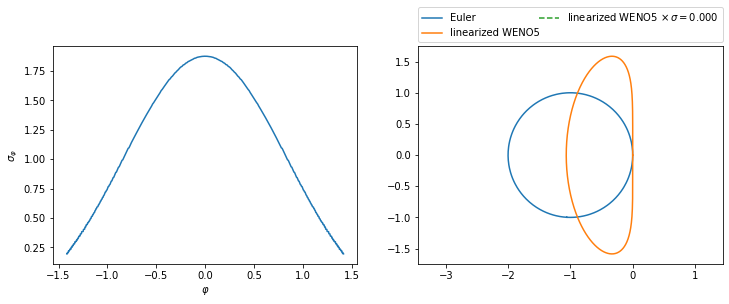

In [109]:
rk1.cfl = {}
rk1.cfl[weno5l.name] = cfl_expr( sp.Abs(rk1.stability_function()),z,weno5l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk1.label,weno5l.name)
display(rk1.cfl[weno5l.name])

On confirme bien avec ce résultat l'aspect instable du couple EE-WENO5 démontré par dans [[R. Wang and R. J. Spiteri (2007)]](https://doi.org/10.1137/050637868).

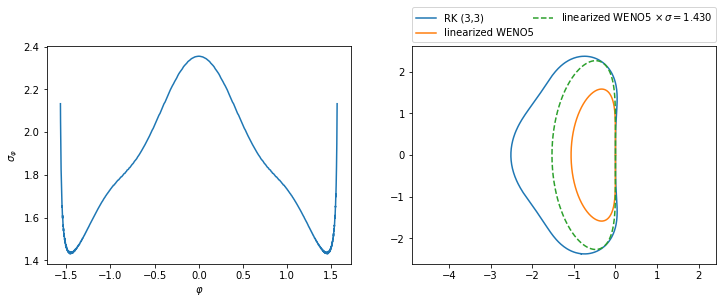

In [110]:
rk33.cfl = {}
rk33.cfl[weno5l.name] = cfl_expr( sp.Abs(rk33.stability_function()),z,weno5l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk33.label,weno5l.name)
display(rk33.cfl[weno5l.name])

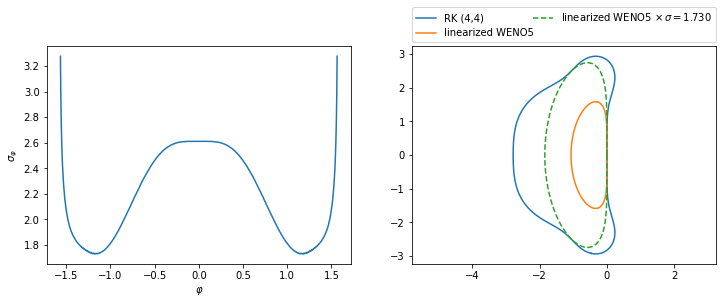

In [111]:
rk44.cfl = {}
rk44.cfl[weno5l.name] = cfl_expr( sp.Abs(rk44.stability_function()),z,weno5l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk44.label,weno5l.name)
display(rk44.cfl[weno5l.name])

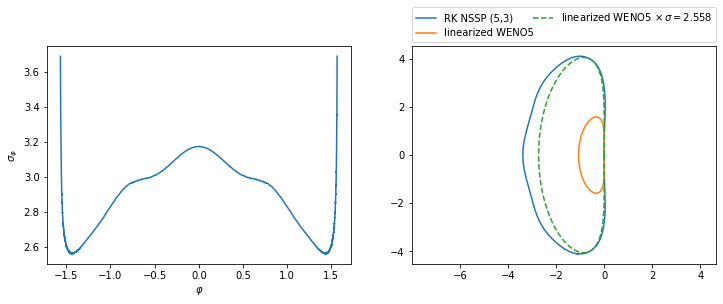

In [112]:
rk53.cfl = {}
rk53.cfl[weno5l.name] = cfl_expr( sp.Abs(rk53.stability_function()),z,weno5l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk53.label,weno5l.name)
display(rk53.cfl[weno5l.name])

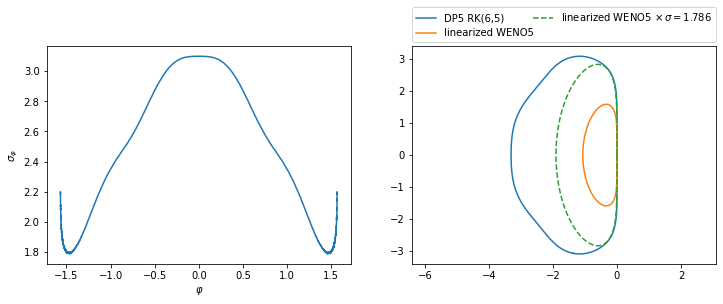

In [113]:
dp5.cfl = {}
dp5.cfl[weno5l.name] = cfl_expr( sp.Abs(dp5.stability_function()),z,weno5l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,dp5.label,weno5l.name)
display(dp5.cfl[weno5l.name])

On peut aussi calculer des CFL avec des couples RK($s$,$n$)-WENO3.

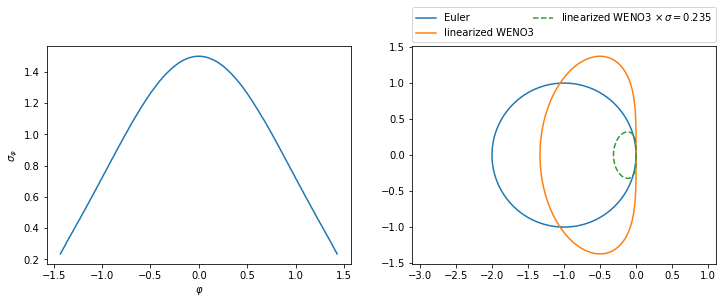

In [114]:
rk1.cfl[weno3l.name] = cfl_expr( sp.Abs(rk1.stability_function()),z,weno3l.ztilde.data,(-2.,2.,1000),(-2.,2.,1000),
         True,rk1.label,weno3l.name)
display(rk1.cfl[weno3l.name])

L'obtention d'une CFL non nulle avec la méthode d'Euler explicite demande peut-être quelques vérification. La discrétisation a été augmenté juste pour ce cas pour vérifier cette prétendue stabilité, mais le script semble indiquer une certaine stabilité. Une étude approfondie à l'aide du vecteur directeur en $(0,0)$ (calculée à partir d'un développement limité des schémas) est peut-être nécessaire.

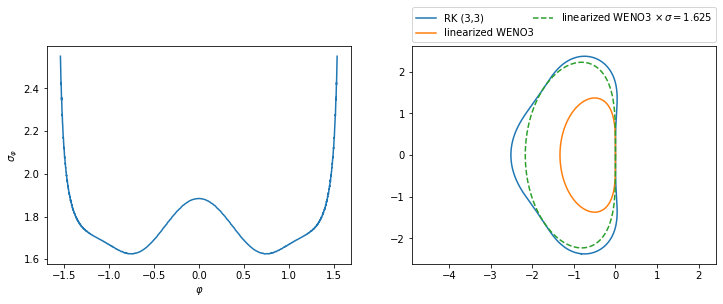

In [115]:
rk33.cfl[weno3l.name] = cfl_expr( sp.Abs(rk33.stability_function()),z,weno3l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk33.label,weno3l.name)
display(rk33.cfl[weno3l.name])

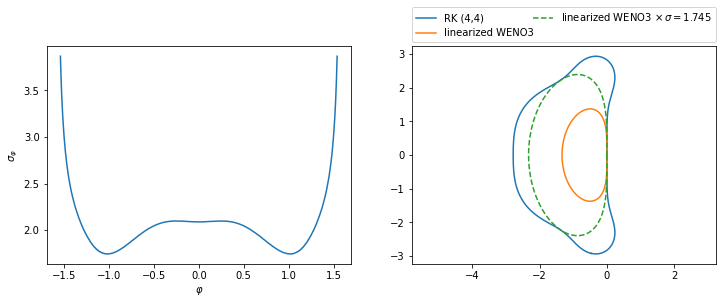

In [116]:
rk44.cfl[weno3l.name] = cfl_expr( sp.Abs(rk44.stability_function()),z,weno3l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk44.label,weno3l.name)
display(rk44.cfl[weno3l.name])

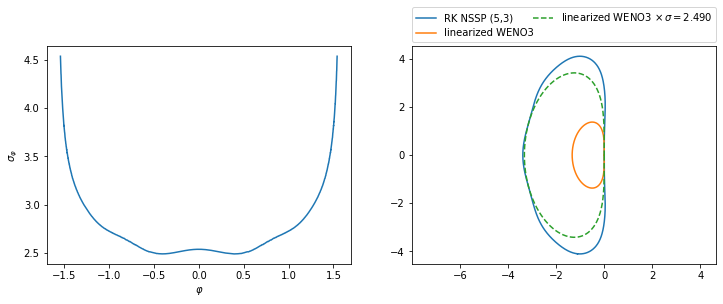

In [117]:
rk53.cfl[weno3l.name] = cfl_expr( sp.Abs(rk53.stability_function()),z,weno3l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk53.label,weno3l.name)
display(rk53.cfl[weno3l.name])

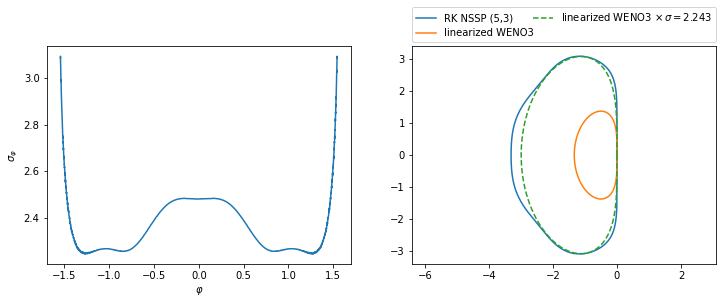

In [118]:
dp5.cfl[weno3l.name] = cfl_expr( sp.Abs(dp5.stability_function()),z,weno3l.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk53.label,weno3l.name)
display(dp5.cfl[weno3l.name])

### 3.1.2 CFL RK($s$,$n$) - *up-wind*

On peut aussi effectuer ce travail pour le schéma *up-wind*. La méthode est exactement la même, mais à partir du cercle de valeurs propres de *up-wind*.

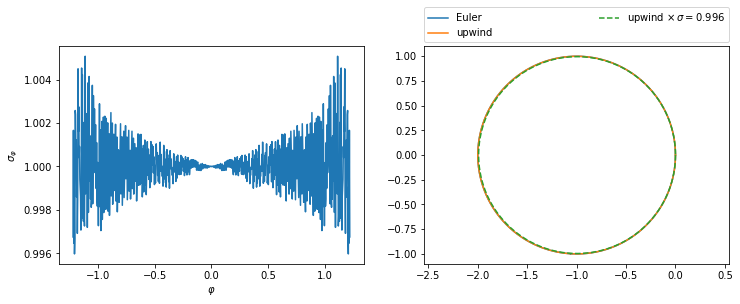

In [119]:
rk1.cfl[upwind.name] = cfl_expr( sp.Abs(rk1.stability_function()),z,upwind.data,(-2.,2.,500),(-2.,2.,500),
         True,rk1.label,upwind.name)
display(rk1.cfl[upwind.name])

Étrangement, même en touchant aux paramètres numériques, on ne trouve pas 1. Cela doit provenir de la discrétisation en amont de *upwind* dans la première partie de ce document.

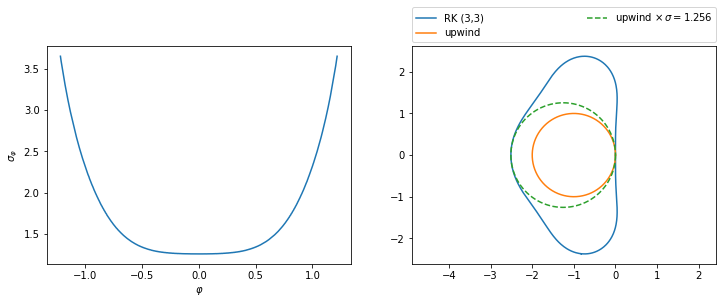

In [120]:
rk33.cfl[upwind.name] = cfl_expr( sp.Abs(rk33.stability_function()),z,upwind.data,(-6.,3.,500),(-6.,6.,500),
         True,rk33.label,upwind.name)
display(rk33.cfl[upwind.name])

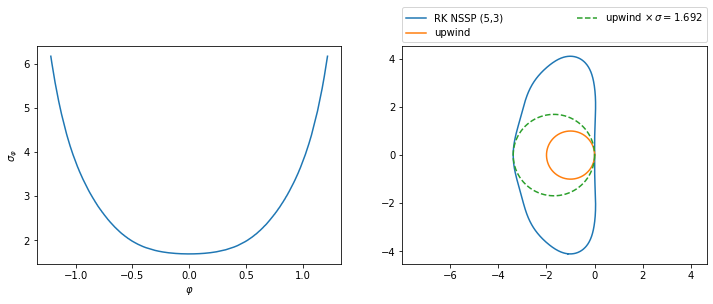

In [121]:
rk53.cfl[upwind.name] = cfl_expr( sp.Abs(rk53.stability_function()),z,upwind.data,(-6.,3.,500),(-6.,6.,500),
         True,rk53.label,upwind.name)
display(rk53.cfl[upwind.name])

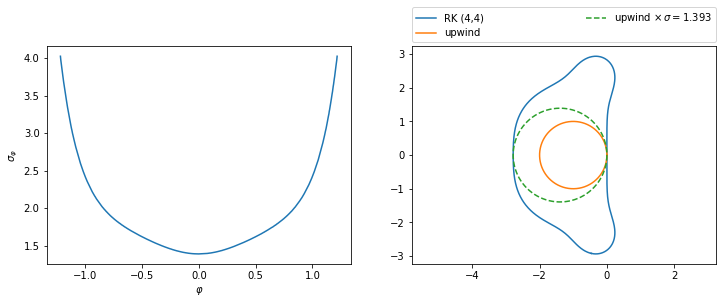

In [122]:
rk44.cfl[upwind.name] = cfl_expr( sp.Abs(rk44.stability_function()),z,upwind.data,(-6.,3.,500),(-6.,6.,500),
         True,rk44.label,upwind.name)
display(rk44.cfl[upwind.name])

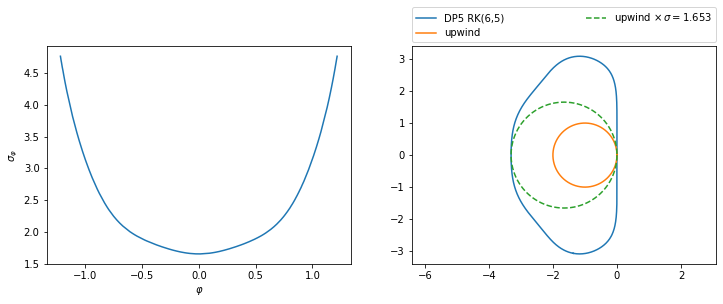

In [123]:
dp5.cfl[upwind.name] = cfl_expr( sp.Abs(dp5.stability_function()),z,upwind.data,(-6.,3.,500),(-6.,6.,500),
         True,dp5.label,upwind.name)
display(dp5.cfl[upwind.name])

### 3.1.3 CFL RK($s$,$n$) - CD2

Pour le schéma CD2, la méthode précédente ne fonctionne pas. La méthode se concentre sur l'étude sur l'axe imaginaire des différents intégrateurs en temps et de trouver la valeur $y_\text{max}$ sur l'axe imaginaire telle que :
$$
  \forall y\in[-y_\text{max},y_\text{max}], |p_{RK(s,n)}(iy)| \leq 1
$$
où $p_{RK(s,n)}$ est la fonction de stabilité de la méthode de Runge-Kutta considérée.

In [124]:
def ymax(rk):
  return min([ x for x in sp.solveset(sp.Abs(rk.stability_function().subs(z,sp.I*y))**2-1,y,domain=sp.S.Reals) if x > 0 ],default=0)

In [125]:
rk1.cfl[cd2.name] = ymax(rk1)
display(rk1.cfl[cd2.name])

In [126]:
rk33.cfl[cd2.name] = ymax(rk33)
display(rk33.cfl[cd2.name])

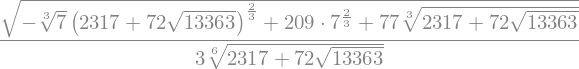

In [127]:
rk53.cfl[cd2.name] = ymax(rk53)
display(rk53.cfl[cd2.name])

In [128]:
rk44.cfl[cd2.name] = ymax(rk44)
display(rk44.cfl[cd2.name])

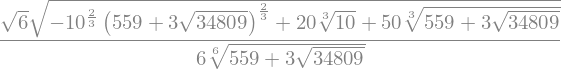

In [129]:
dp5.cfl[cd2.name] = ymax(dp5)
display(dp5.cfl[cd2.name])

### 3.1.4 Récapitulatif des CFL obtenues

In [130]:
print("| {:>13} | {:^7} | {:^7} | {:^7} | {:^7} |".format("RK method","WENO5","WENO3","upwind","CD2"))
print("|-"+"-"*13+"-|-"+"-"*7+"-|-"+"-"*7+"-|-"+"-"*7+"-|-"+"-"*7+"-|")
for rk in [rk1,rk33,rk53,rk44,dp5]:
    print("| {:>13} | {:6.5f} | {:6.5f} | {:6.5f} | {:6.5f} |".format(rk.label,
                                                                      rk.cfl[weno5l.name],
                                                                      rk.cfl[weno3l.name],
                                                                      rk.cfl[upwind.name],
                                                                      float(sp.N(rk.cfl[cd2.name]))
                                                                     ))

|     RK method |  WENO5  |  WENO3  | upwind  |   CD2   |
|---------------|---------|---------|---------|---------|
|         Euler | 0.00000 | 0.23510 | 0.99598 | 0.00000 |
|      RK (3,3) | 1.43009 | 1.62519 | 1.25632 | 1.73205 |
| RK NSSP (5,3) | 2.55768 | 2.48996 | 1.69200 | 2.78284 |
|      RK (4,4) | 1.73024 | 1.74519 | 1.39264 | 2.82843 |
|   DP5 RK(6,5) | 1.78582 | 2.24350 | 1.65326 | 0.99719 |


On récapitule les CFL obtenues pour le schéma WENO5 en les comparant à la littérature :

|         -           | Euler | RK(3,3) | RK(5,3) | RK(4,4) |
|:-------------------:|------:|--------:|--------:|--------:|
| [[Thibaut L. et al.]](https://doi.org/10.1175/MWR-D-16-0343.1) | 0.00 | 1.44 | 2.14 | 1.73 |
| **WENO5 linéarisé** | 0.00  | 1.430   | 2.558   | 1.730   |

Je n'arrive pas à expliquer la différence sur le schéma RK(5,3) entre [[Thibaut L. et al.]](https://doi.org/10.1175/MWR-D-16-0343.1) et ma méthode de calcul de CFL avec WENO linéarisé.

Ces CFL s'appliquent à une équation de transport 1D du type :

$$
  u_t + au_x = 0
$$

La CFL d'un couple de schéma RK($s$,$n$)-WENO5 pour résoudre une telle équation est de la forme :

$$
  \Delta t \leq \frac{\sigma \Delta x}{a}
$$

avec $\sigma$ donné par le tableau précédent.

## 3.2 Constante d'erreur, couple idéal

Il est possible de remarquer une constante d'erreur lors que l'on trace les courbes d'ordre entre une méthode RK($s$,$n$) et une méthode d'intégration en espace. Nous nous proposons dans cette section de l'étudier numériquement. Pour cela dans un premier temps nous allons écrire une fonction qui prend une méthode Runge-Kutta (son tableau de Butcher) et retourne une fonction `python` appelable pour résoudre (sur une itération) une équation du type $\dot{u} = L(t,u)$, dans la pratique on prendra $L:t,u\mapsto -a\partial_xu$ avec $a\in\mathbb{R}$ la vitesse d'advection.

In [131]:
def scheme_func ( rk,L_,un_,tn_,dt_ ,shu_osher=True):
  """
    function to conert a RK mathematic scheme into a computer function
  """
  if hasattr(rk,'_func') :
    return rk._func(L_,un_,tn_,dt_)

  f_scheme = []
  for stage in rk.scheme(shu_osher=shu_osher):
    f_scheme.append(sp.lambdify((*rk_scheme.ui[:rk.stages()],tn,dt,L),stage.rhs,'numpy'))

  def rk_func(L__,un__,tn__,dt__):
    u_s = [ np.empty_like(un__) for _ in range(rk.stages()-1) ]
    for i,f in enumerate(f_scheme[:-1]):
      u_s[i] = f(un__,*u_s,tn__,dt__,L__)
    return f_scheme[-1](un__,*u_s,tn__,dt__,L__)
  rk._func = rk_func
  return rk._func(L_,un_,tn_,dt_)

rk_butcher.func = lambda self,L,un,tn,dt:scheme_func(self,L,un,tn,dt)

In [132]:
def _transport(u0,rk,L,num_param):
  r"""
    _transport
    use `rk` method with `L` discretisation in space to solve :
    $u_t = L(u,t),\ u(t=0)=\texttt{u0}$,
    to the time `num_param.Tf`, with time step `num_param.dt`, $x\in[0,1]$ so length
    of `u0` gives the space step.
  """
  u=np.array(u0,copy=True)
  
  dt = num_param.dt
  current_t = 0.0
  while current_t < num_param.Tf :
    u = rk.func(L,u,current_t,dt)
    current_t += dt
    if current_t+dt > num_param.Tf:
      dt = num_param.Tf-current_t
  
  return u

On effectue maintenant un test sur une équation de transport :

$$
  u_t + u_x = 0
$$
avec $u(t=0,x)=u_0(x) = \cos(2\pi x)$, avec 20 points de discrétisation en $x$ sur le segement $[0,1]$, $\Delta t = \Delta x$, jusqu'au temps $T_f=1.2$. Comme discrétisation en temps nous utiliserons les méthodes données par `rk33`, `rk33bis` et `rknssp33`, en espace on utilisera la méthode WENO5.

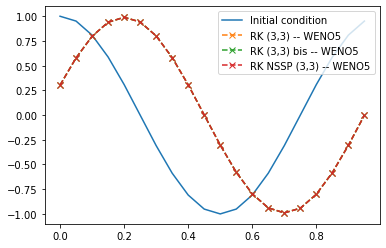

In [133]:
num_param = Data()

num_param.N  = 20
num_param.X  = np.linspace(0.,1.,num_param.N,endpoint=False)
num_param.dx = 1./num_param.N

num_param.u_0 = np.cos(2.*np.pi*num_param.X)

num_param.Tf = 1.2
num_param.dt = 1./num_param.N # = dx; a classical CFL

plt.plot(num_param.X,num_param.u_0,label="Initial condition")
for rk in [rk33,rk33bis,rknssp33]:
  print(rk.label,end="\r")
  u = _transport(num_param.u_0,rk,lambda _,u:-weno5.func(u,num_param.dx),num_param)
  plt.plot(num_param.X,u,"x--",label=rk.label+" -- "+weno5.name)
  
plt.legend()
del num_param,u,rk

Sur ce cas test les résultats sont confondus. Cette condition initiale est trop régulière, nous allons donc effectuer un test, en temps plus long avec comme condition initiale un test de Shu. Nous savons que l'erreur est en $\mathcal{O}(\Delta x^p)+\mathcal{O}(\Delta t^q)$ avec $p$ l'ordre du schéma en espace (ici $p=5$) et $q$ l'ordre du schéma en temps ($q=3$ sur ce premier exemple). Nous souhaitons maximiser l'erreur en temps pour que celle-ci soit la plus visible, nous nous placerons un peu en dessous de la CFL, pour un couple RK(3,3)-WENO5 celle-ci est de $\sigma=1.43$. Nous allons aussi effectuer une simulation en temps plus long $T_f=10$.

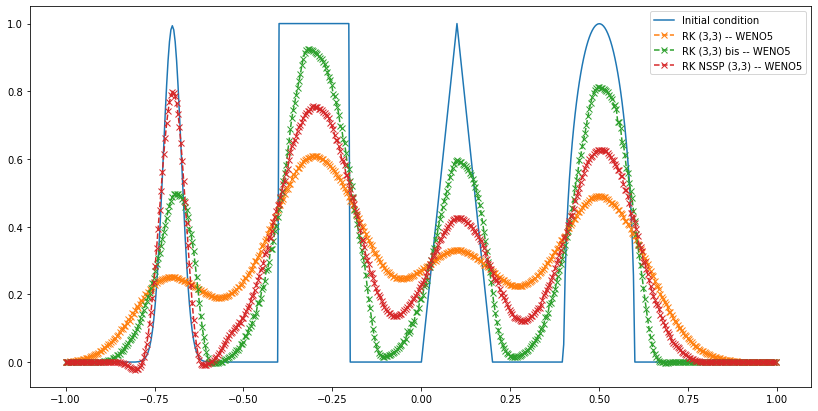

In [140]:
num_param = Data()

num_param.N  = 500
num_param.X  = np.linspace(-1.,1.,num_param.N,endpoint=False)
num_param.dx = 2./num_param.N

num_param.u_0 = np.array([u0_shu(x) for x in num_param.X])

num_param.Tf = 10.0
num_param.dt = 1.43*num_param.dx

plt.rcParams['figure.figsize'] = [14,7]
plt.plot(num_param.X,num_param.u_0,label="Initial condition")
for rk in [rk33,rk33bis,rknssp33]:
  print(rk.label,end="\r")
  u = _transport(num_param.u_0,rk,lambda _,u:-weno5.func(u,num_param.dx),num_param)
  plt.plot(num_param.X,u,"x--",label=rk.label+" -- "+weno5.name)

plt.legend()
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del num_param,u,rk

Maintenant que l'on voit cette constante d'erreur sur un cas test présentant de fortes discontinuités (de la fonction et de sa dérivée), essayons de mesurer l'ordre sur ce cas.

<ipython-input-226-fd2c05fb0a4c>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


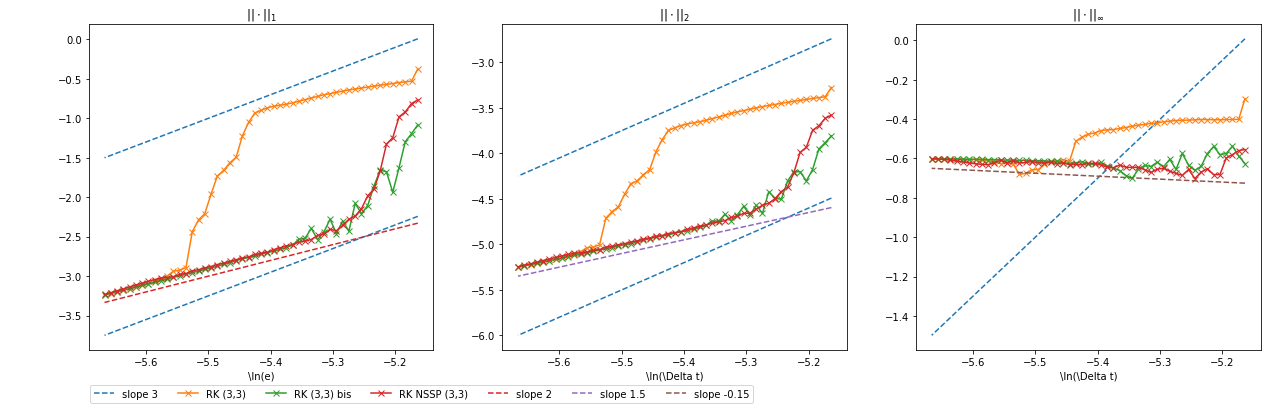

In [226]:
num_param = Data()
num_param.N  = 500
num_param.X  = np.linspace(-1.,1.,num_param.N,endpoint=False)
num_param.dx = 2./num_param.N
num_param.dt0 = 1.43*num_param.dx
num_param.dt = num_param.dt0
num_param.Tf = 10.0 #2000*num_param.dt0

num_param.u_0 = np.array([u0_shu(x) for x in num_param.X])
num_param.u_e = np.array([u0_shu(x-num_param.Tf) for x in num_param.X])

num_param.time_schemes = [rk33,rk33bis,rknssp33]
errors_rk = { rk.label:[] for rk in num_param.time_schemes }

n=0
while num_param.dt > 0.6*num_param.dt0:
  for rk in [rk33,rk33bis,rknssp33]:
    print("{:02d} {:0.6f} {:>20}".format(n,num_param.dt,rk.label),end="\r")
    u = _transport(num_param.u_0,rk,lambda _,u:-weno5.func(u,num_param.dx),num_param)
    errors_rk[rk.label].append( (num_param.dt,error(u,num_param.u_e,num_param.dt)) )
  num_param.dt *= 0.99
  n+=1

del num_param

time_steps = np.array([ e[0] for e in errors_rk[rk33.label] ])

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,6))
ax1.plot(np.log(time_steps),3.*np.log(time_steps)+15.5,"--",color=default.palette[0],label="slope 3")
ax1.plot(np.log(time_steps),3.*np.log(time_steps)+13.25,"--",color=default.palette[0])
ax2.plot(np.log(time_steps),3.*np.log(time_steps)+12.75,"--",color=default.palette[0])
ax2.plot(np.log(time_steps),3.*np.log(time_steps)+11,"--",color=default.palette[0])
ax3.plot(np.log(time_steps),3.*np.log(time_steps)+15.5,"--",color=default.palette[0])

ax1.set_title(r"$||\cdot||_{1}$")
ax2.set_title(r"$||\cdot||_{2}$")
ax3.set_title(r"$||\cdot||_{\infty}$")
ax1.set_xlabel(r"\ln(\Delta t)"); ax1.set_xlabel(r"\ln(e)")
ax2.set_xlabel(r"\ln(\Delta t)")
ax3.set_xlabel(r"\ln(\Delta t)")

for i,(rk,errors) in enumerate(errors_rk.items()):
  ax1.plot( np.log(time_steps) , [ np.log(e[1].n1)  for e in errors ] , "x-" ,
           label=rk , color=default.palette[(i+1)%len(default.palette)] )
  ax2.plot( np.log(time_steps) , [ np.log(e[1].n2)  for e in errors ] , "x-" ,
           color=default.palette[(i+1)%len(default.palette)] )
  ax3.plot( np.log(time_steps) , [ np.log(e[1].noo) for e in errors ] , "x-" ,
           color=default.palette[(i+1)%len(default.palette)] )

ax1.plot(np.log(time_steps),2.*np.log(time_steps)+8.,"--",color=default.palette[3],label="slope 2")
ax2.plot(np.log(time_steps),1.5*np.log(time_steps)+3.15,"--",color=default.palette[4],label="slope 1.5")
ax3.plot(np.log(time_steps),-0.15*np.log(time_steps)-1.5,"--",color=default.palette[5],label="slope -0.15")
  
fig.legend(loc=(0.071,0.01),ncol=len(errors_rk)+4)
fig.show()

del time_steps,fig,ax1,ax2,ax3,i,rk,errors

On peut remarquer cette constante d'erreur entre les schémas pour les plus grands $\Delta t$. Ces simulations s'effectuant en temps long sur le transport d'une condition initiale non régulière il est normal de ne pas retrouver l'ordre 3 de ces méthodes. Pour de plus petits pas de temps on remarques que l'erreur des 3 méthodes convergent vers la même valeur, avec la même pente.

# 4. Équation avec un terme linéaire et un non linéaire

Regardons le problème :

$$
  \dot{u} = Lu + N(u)
$$

où $N$ est une fonction, non linéaire, de $u$. On peut vouloir construire une formule de Duhamel à partir de cette équation, en remarquant que :

$$
  \partial_t\left(e^{-Lt}u\right) = e^{-Lt}N(u(t))
$$

Pour construire un schéma en temps à partir de cette équation il faut intégrer sur $[t^n,t^{n+1})$ :

$$
  \int_{t^n}^{t^{n+1}} \partial_t\left(e^{-Lt}u\right)\,\mathrm{d}t = 
    \int_{t^n}^{t^{n+1}} e^{-Lt}N(u(t))\,\mathrm{d}t
$$

On évalue de manière exacte le terme de gauche :

$$
  e^{-Lt^n}\left( e^{-L\Delta t}u(t^{n+1}) - u(t^n) \right) = \int_{t^n}^{t^{n+1}} e^{-Lt}N(u(t))\,\mathrm{d}t
$$

soit :

$$
  e^{-L\Delta t}u(t^{n+1}) - u(t^n) = \int_{t^n}^{t^{n+1}} e^{-L(t-t^n)}N(u(t))\,\mathrm{d}t
$$

> En effectuant le changement de variable $\tau = t-t^n$ on retrouve une intégrale sur le seul pas de temps $\Delta t$, ce qui est rassurant quant à la stabilié numérique en temps long (à propos des possibles erreurs d'*overflow* ou d'*underflow* produites par la fonction exponentielle).

On souhaite construire un schéma en temps, donc on réécrit le problème sous la forme :

$$
  u(t^{n+1}) = e^{L\Delta t}u(t^n) + \int_{0}^{\Delta t} e^{-L(s-\Delta t)}N(u(t^n+s))\,\mathrm{d}s
$$

Nous allons ici présenter deux classes de schéams dit exponentiels, pour résoudre cette intégrale.

## 4.1 Schéma de Lawson

On effectue le changement de variable $v(t) = e^{-Lt}u(t)$, ce qui permet de réécrire l'équation $\dot{u} = Lu+N(u)$ en :

$$
  \dot{v} = e^{-Lt}N(e^{Lt}v(t))
$$

en posant $\tilde{N}:(t,v)\mapsto e^{-Lt}N(e^{Lt}v(t))$, on obtient :

$$
  \dot{v} = \tilde{N}(t,v)
$$

qui peut se résoudre avec une méthode de Runge-Kutta, que l'on réécrira en fonction de $u$ et $L$ pour obtenir un schéma dit de Lawson. Prenons par exemple le schéma RK SSP(3,3) dit de Shu-Osher :

$$
  \begin{aligned}
    v^{(1)} &= v^n + \Delta t \tilde{N}(t^n,v^n) \\
    v^{(2)} &= \frac{3}{4}v^n + \frac{1}{4}v^{(1)} + \frac{1}{4}\Delta t \tilde{N}(t^n+\Delta t,v^{(1)}) \\
    v^{n+1} &= \frac{1}{3}v^n + \frac{2}{3}v^{(2)} + \frac{2}{3}\Delta t \tilde{N}(t^n+\frac{1}{2}\Delta t,v^{(2)}) \\
  \end{aligned}
$$

Ce qui nous donne en fonction de $u$ :

$$
  \begin{aligned}
    v^{(1)} &= e^{-L t^n}u^n + \Delta t e^{-L t^n}N(u^n) \\
    v^{(2)} &= \frac{3}{4}e^{-L t^n}u^n + \frac{1}{2}v^{(1)} + \frac{1}{4}\Delta t e^{-Lt^n}e^{-L\Delta t}N(e^{Lt^n}e^{L\Delta t}v^{(1)}) \\
    e^{-L t^n}e^{-L\Delta t}u^{n+1} &= \frac{1}{3}e^{-L t^n}u^n + \frac{2}{3}v^{(2)} + \frac{2}{3}\Delta t e^{-Lt^n}e^{-\frac{1}{2}L\Delta t}N(e^{Lt^n}e^{\frac{1}{2}L\Delta t}v^{(2)})
  \end{aligned}
$$